Episode 0 completed with 366 steps, average loss 0.13232809137247625 and total reward -178.5
Episode 1 completed with 571 steps, average loss 13.355445158304141 and total reward -407.5
Episode 2 completed with 259 steps, average loss 27.12927176133086 and total reward -134.5
Episode 3 completed with 1286 steps, average loss 7.5049647035810105 and total reward -989.5
Episode 4 completed with 141 steps, average loss 3.969274385178343 and total reward -4.5
Episode 5 completed with 118 steps, average loss 3.69212168960248 and total reward 13.5
Episode 6 completed with 71 steps, average loss 4.292854342662113 and total reward 48.5
Episode 7 completed with 76 steps, average loss 5.978182626397986 and total reward 47.5
Episode 8 completed with 79 steps, average loss 6.582392920421649 and total reward 45.5
Episode 9 completed with 126 steps, average loss 5.676370349195269 and total reward 16.5
Episode 10 completed with 111 steps, average loss 5.428427815437317 and total reward 25.5
Episode 11 

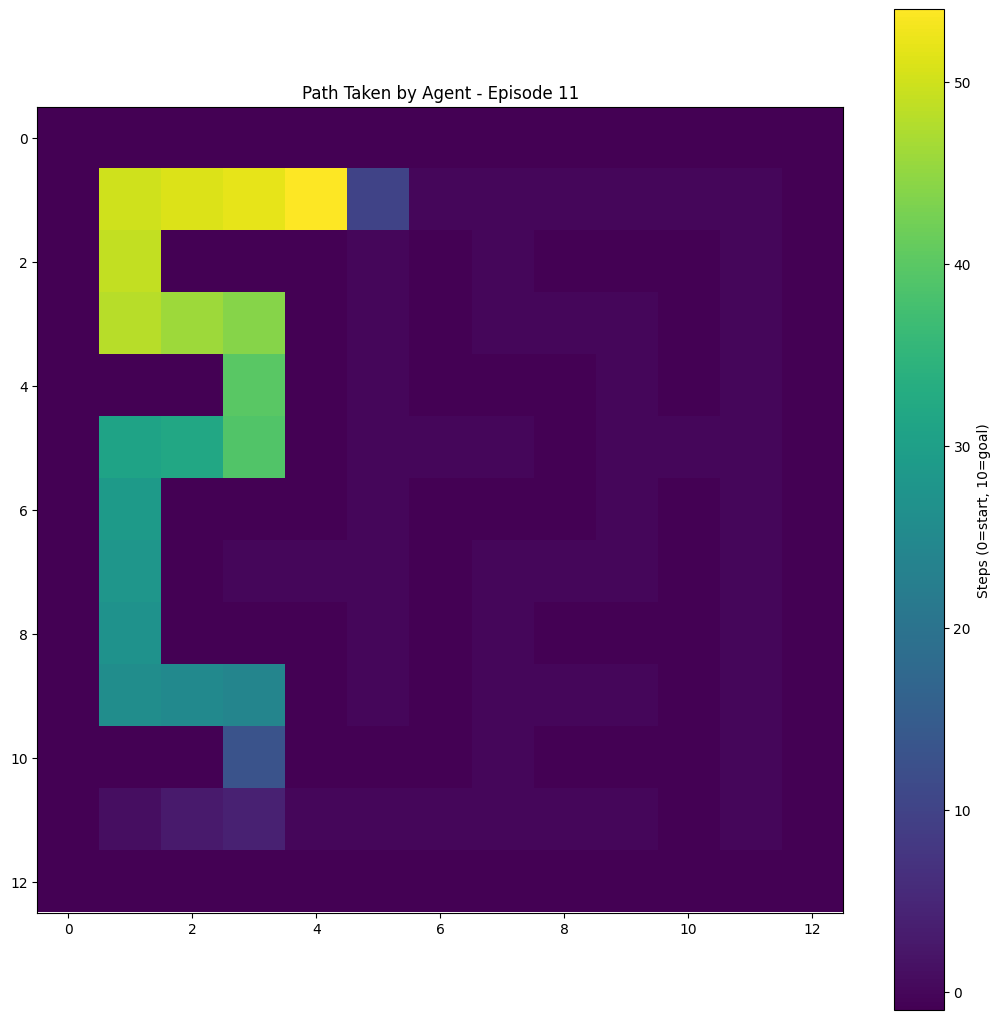

Episode 12 completed with 100 steps, average loss 5.154509272575378 and total reward 27.5
Episode 13 completed with 54 steps, average loss 4.479546851581997 and total reward 63.5


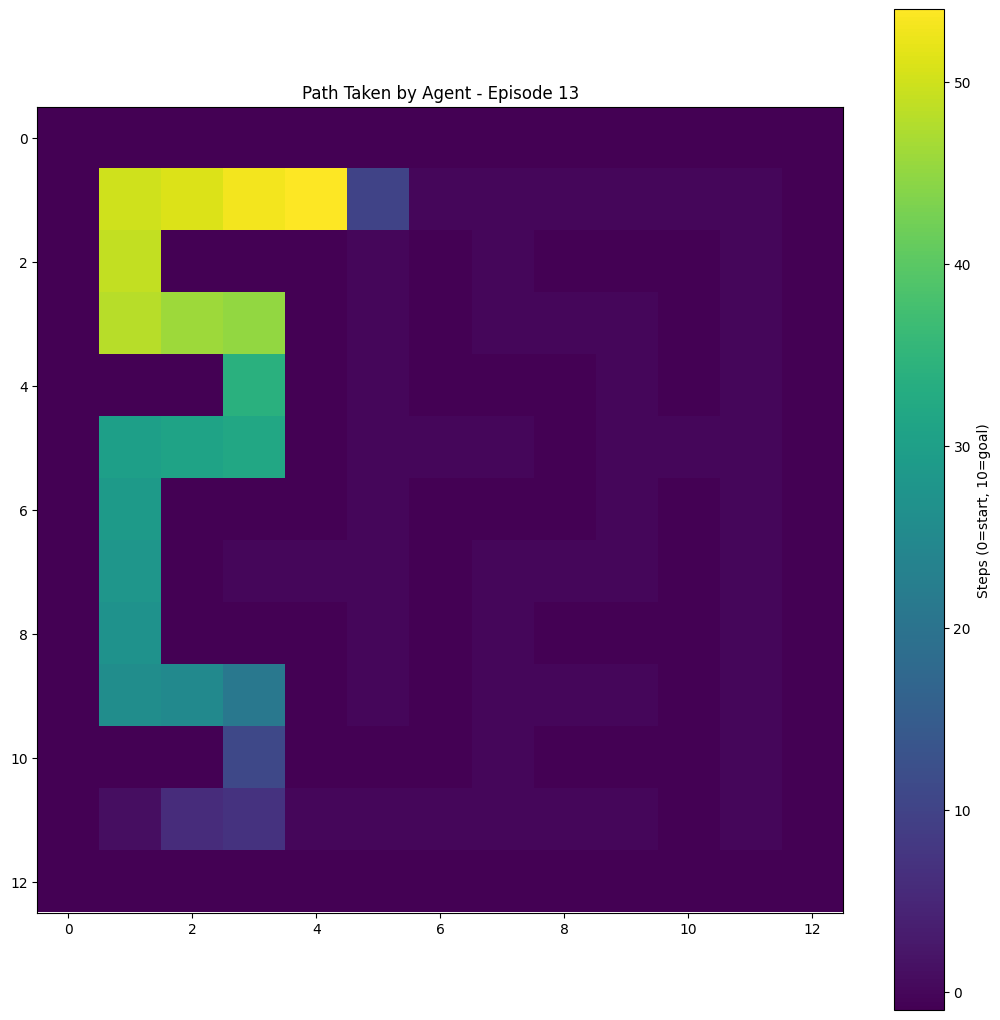

Episode 14 completed with 72 steps, average loss 4.635186306304401 and total reward 46.5
Episode 15 completed with 33 steps, average loss 4.9507660576791475 and total reward 79.5


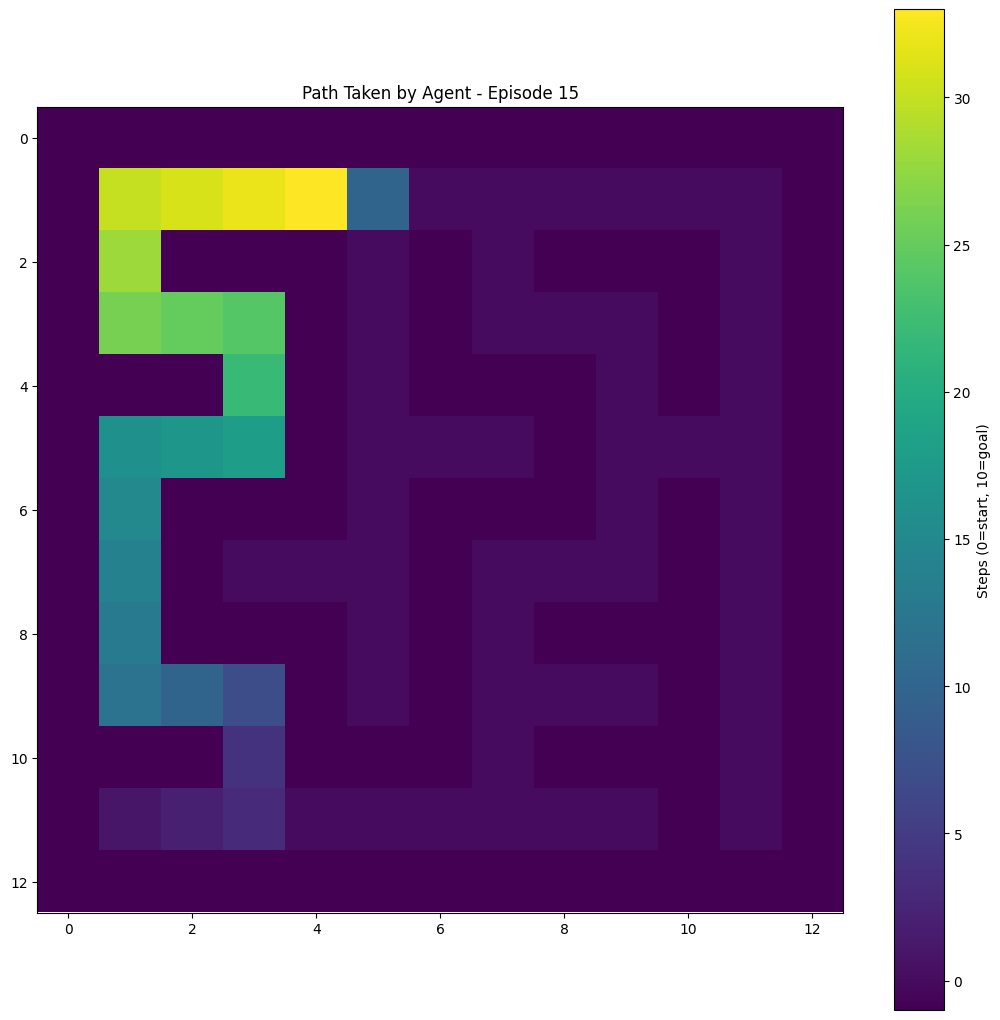

Episode 16 completed with 69 steps, average loss 5.319020101989525 and total reward 47.5
Episode 17 completed with 122 steps, average loss 4.910751553832507 and total reward 21.5
Episode 18 completed with 102 steps, average loss 4.091653777103798 and total reward 18.5
Episode 19 completed with 61 steps, average loss 3.28723816598048 and total reward 59.5
Episode 20 completed with 54 steps, average loss 3.2255986597802906 and total reward 62.5


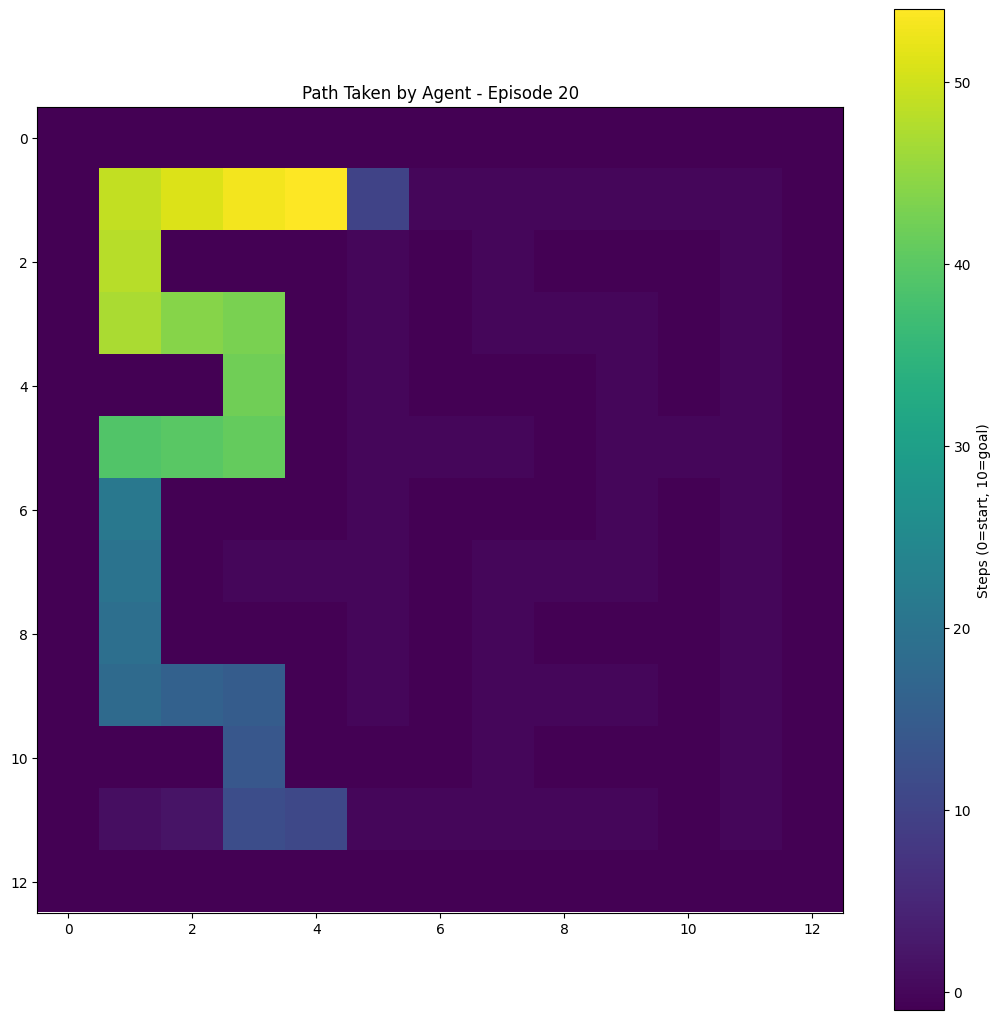

Episode 21 completed with 83 steps, average loss 3.0732185223016395 and total reward 39.5
Episode 22 completed with 52 steps, average loss 2.85511621259726 and total reward 63.5


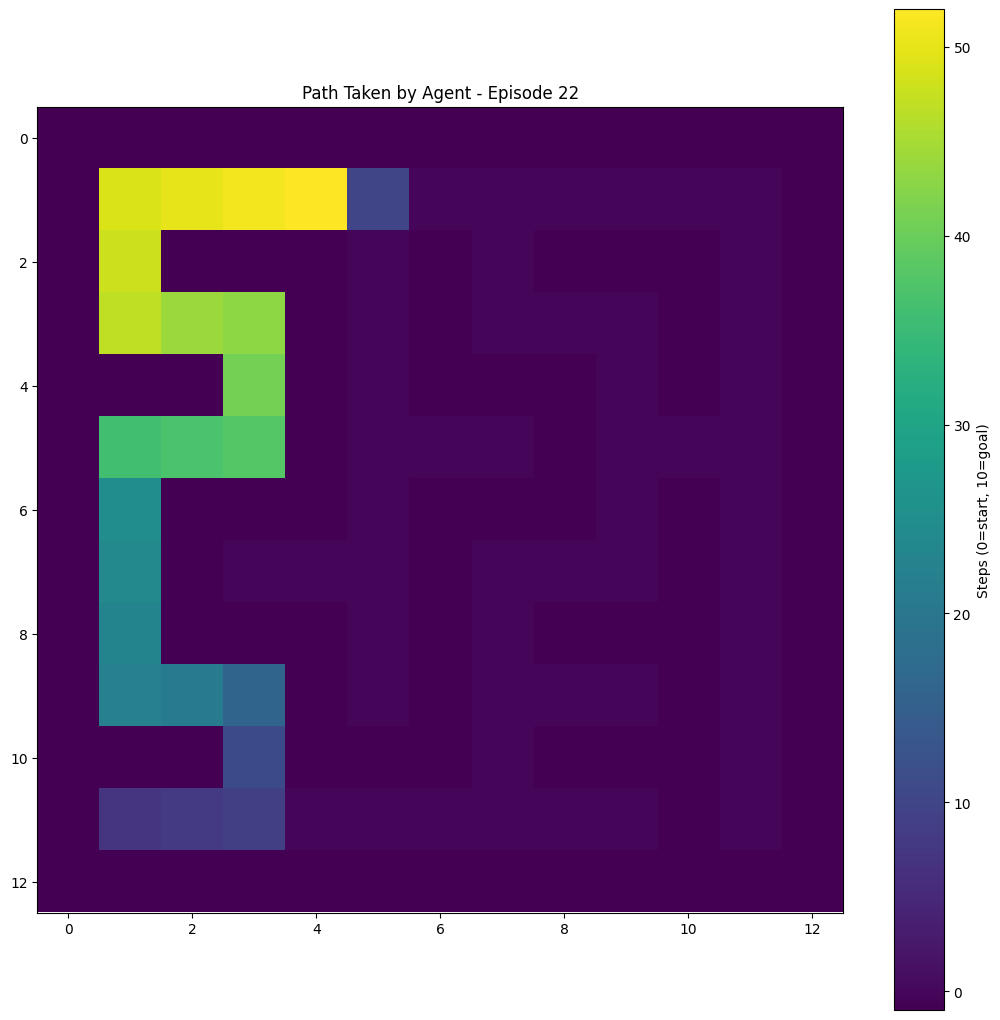

Episode 23 completed with 50 steps, average loss 2.6085888648033144 and total reward 64.5


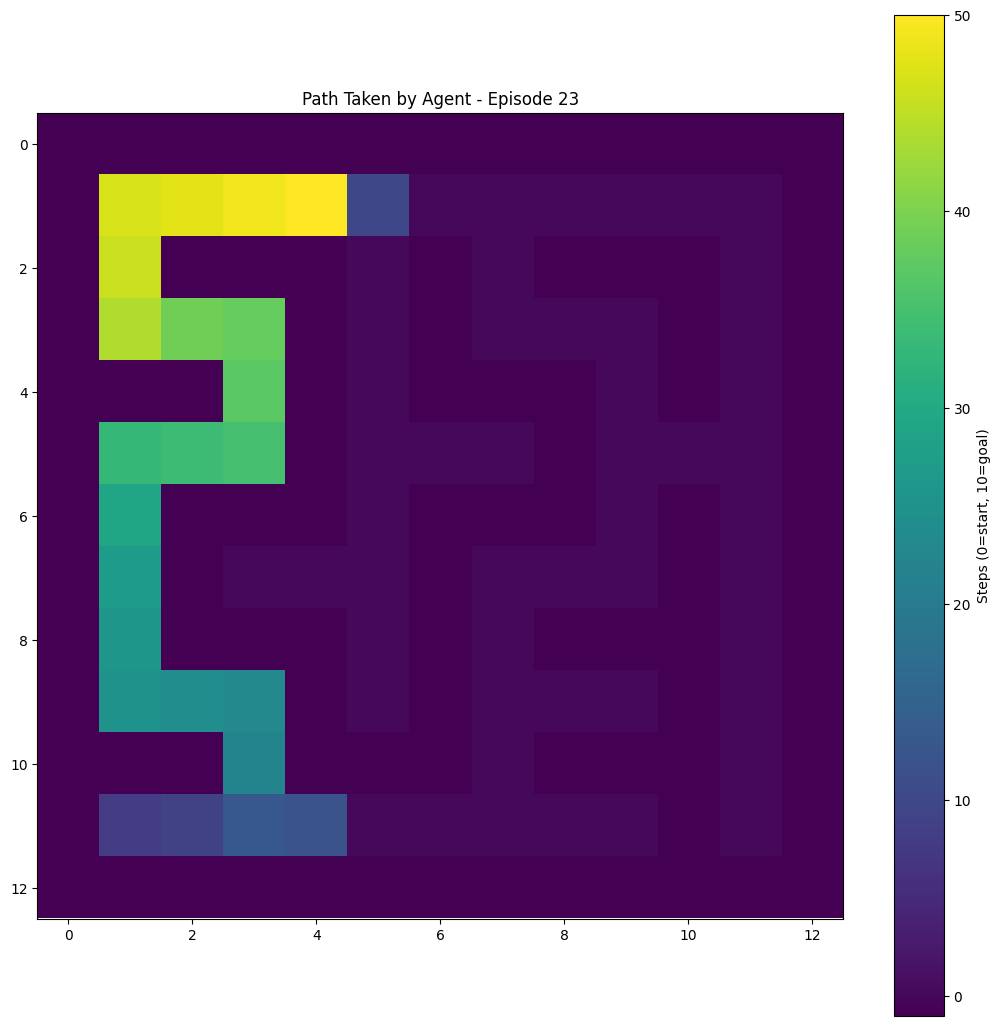

Episode 24 completed with 55 steps, average loss 2.2558422912250866 and total reward 59.5
Episode 25 completed with 2962 steps, average loss 2.0190170223068176 and total reward -2399.5
Episode 26 completed with 52 steps, average loss 1.8319002057497318 and total reward 61.5


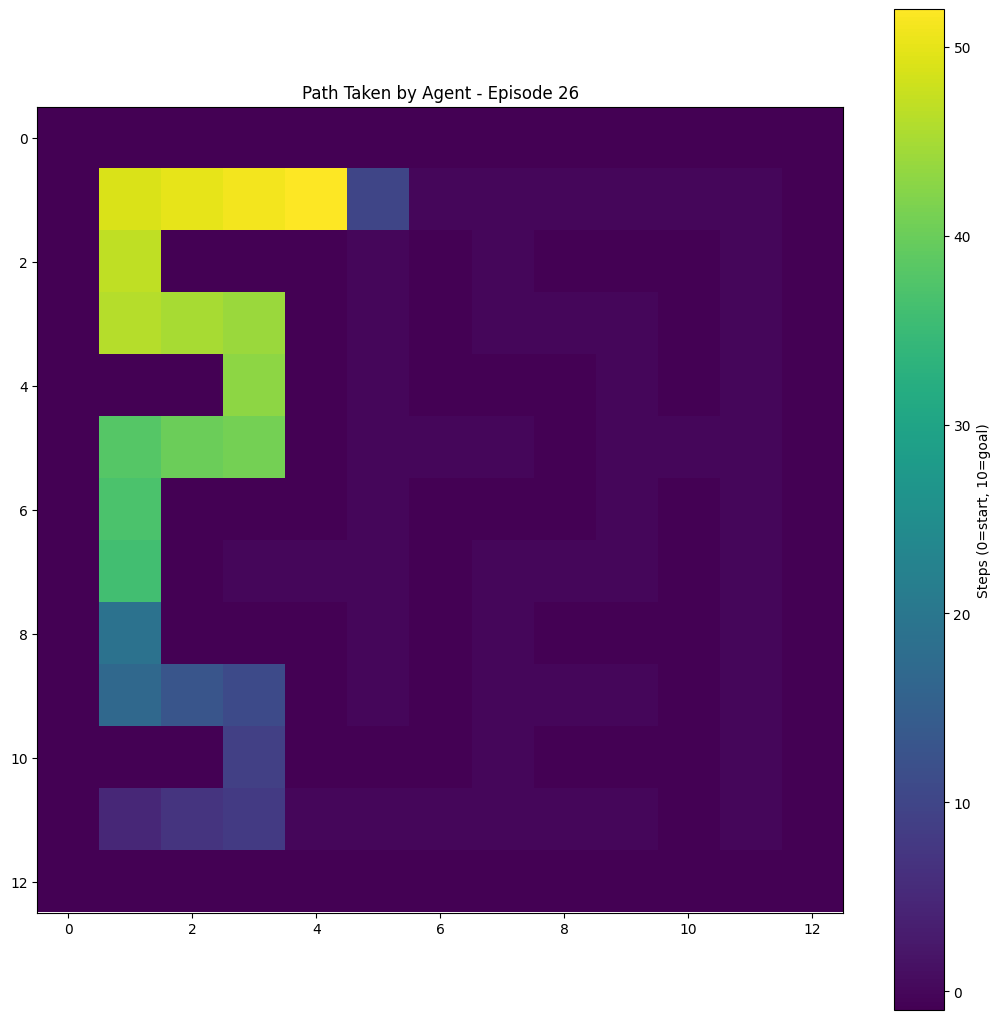

Episode 27 completed with 77 steps, average loss 1.6061769034955409 and total reward 43.5
Episode 28 completed with 34 steps, average loss 2.2151473462581635 and total reward 78.5


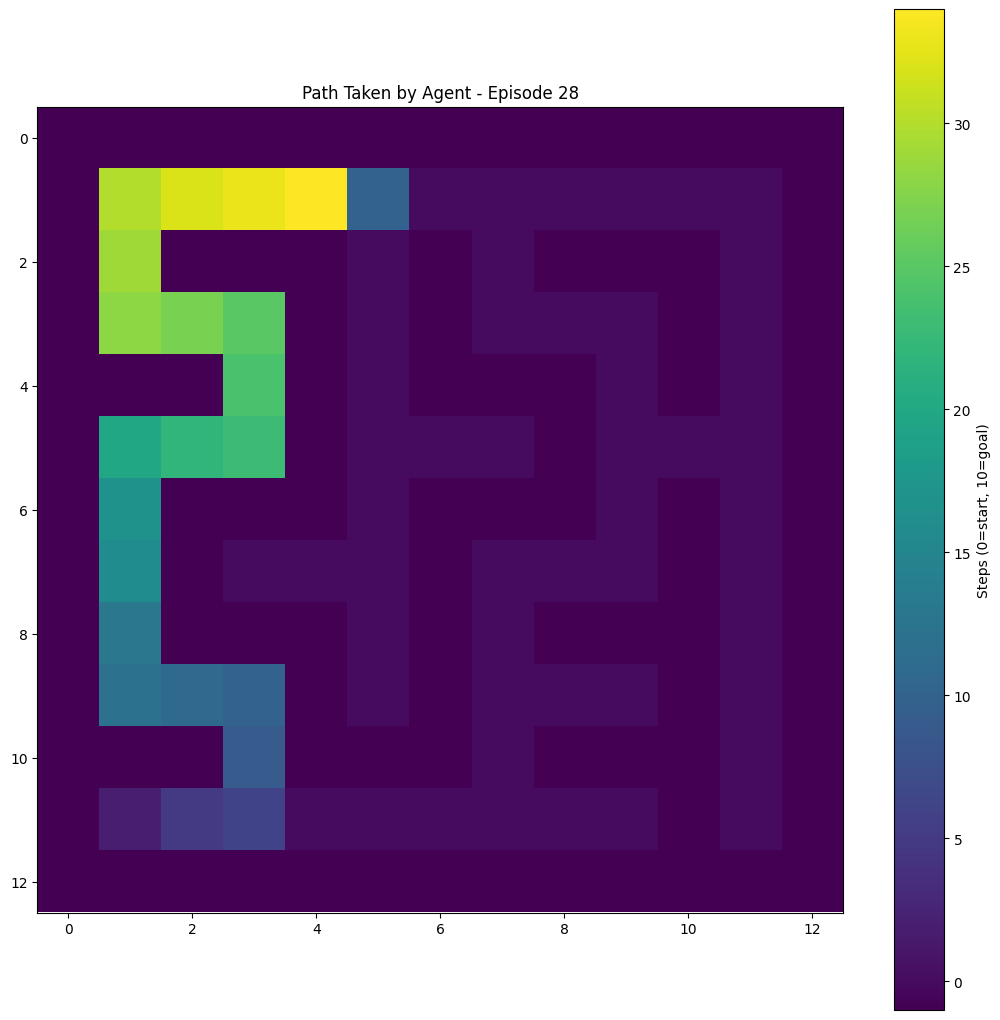

Episode 29 completed with 50 steps, average loss 1.9180952906608582 and total reward 66.5


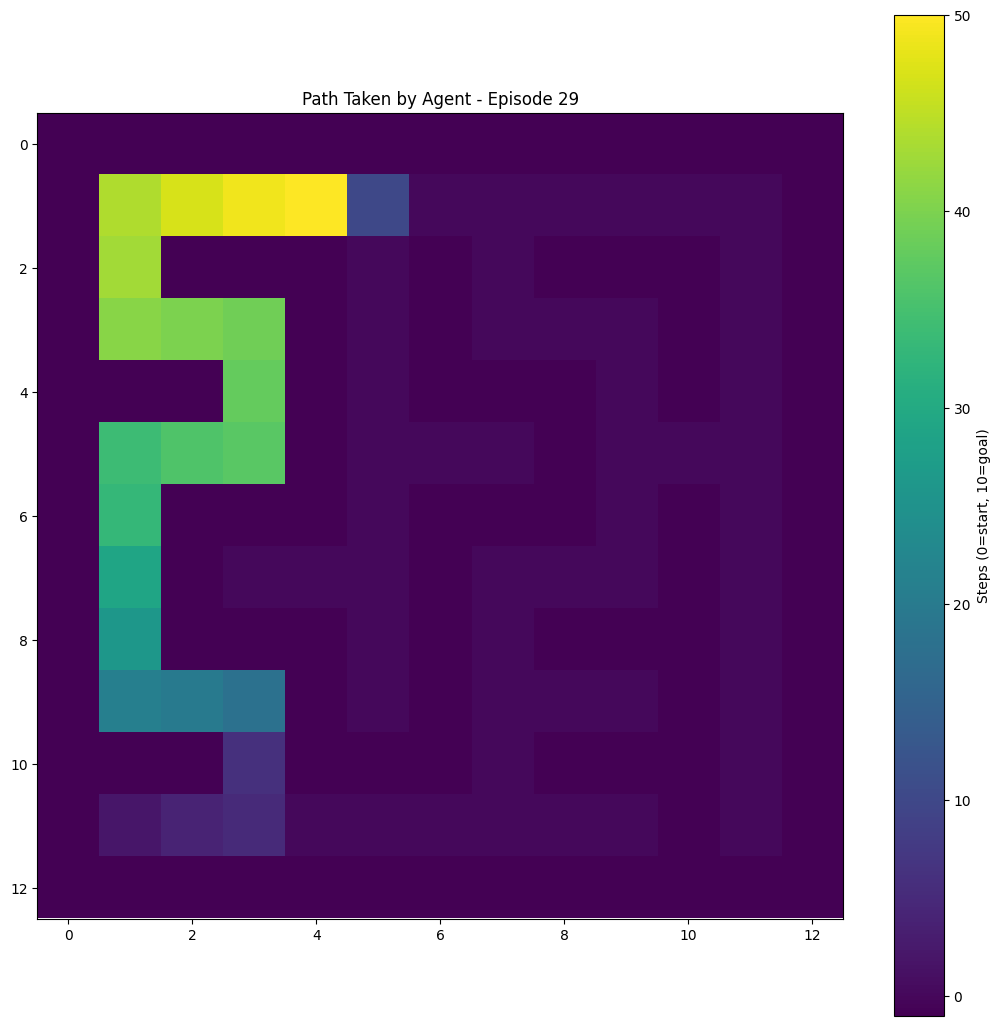

Episode 30 completed with 48 steps, average loss 1.6034555311004322 and total reward 65.5


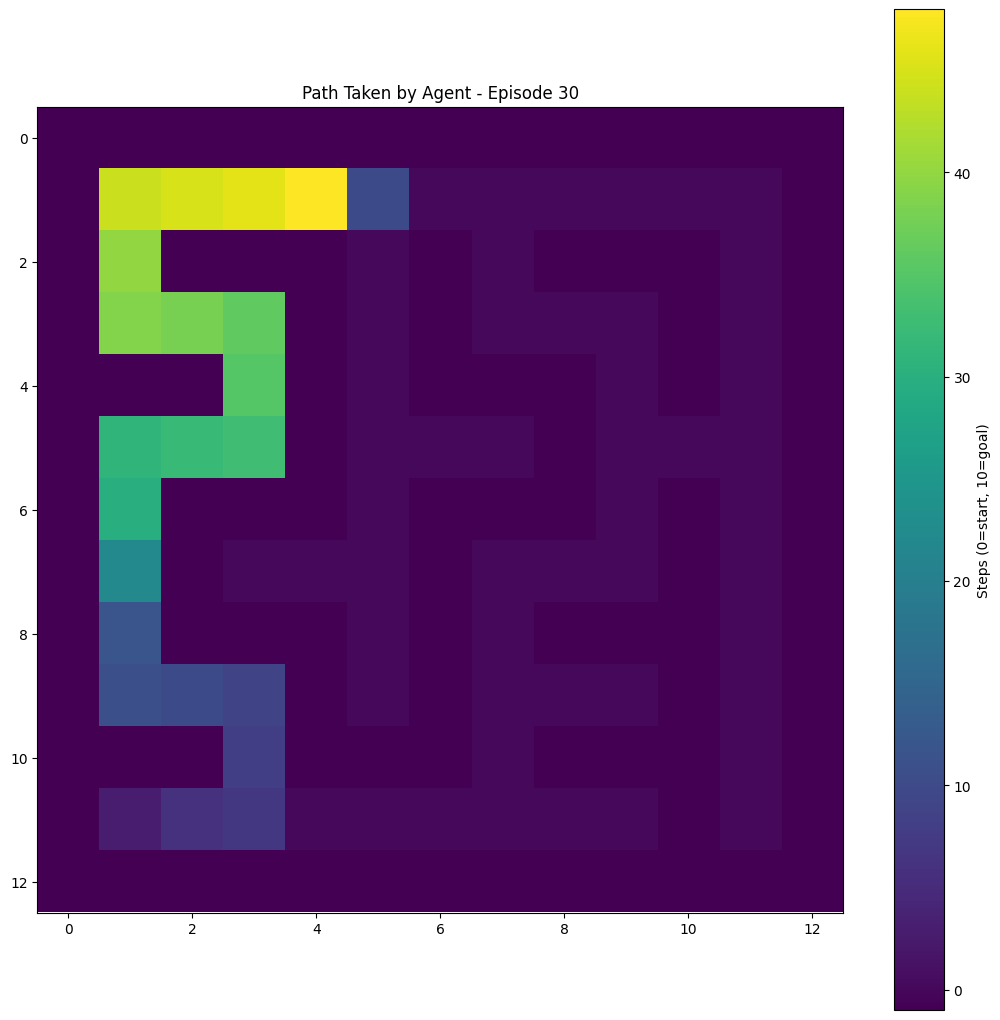

Episode 31 completed with 95 steps, average loss 1.5991711522403516 and total reward 28.5
Episode 32 completed with 65 steps, average loss 1.7102375947512114 and total reward 56.5
Episode 33 completed with 47 steps, average loss 1.157363551728269 and total reward 67.5


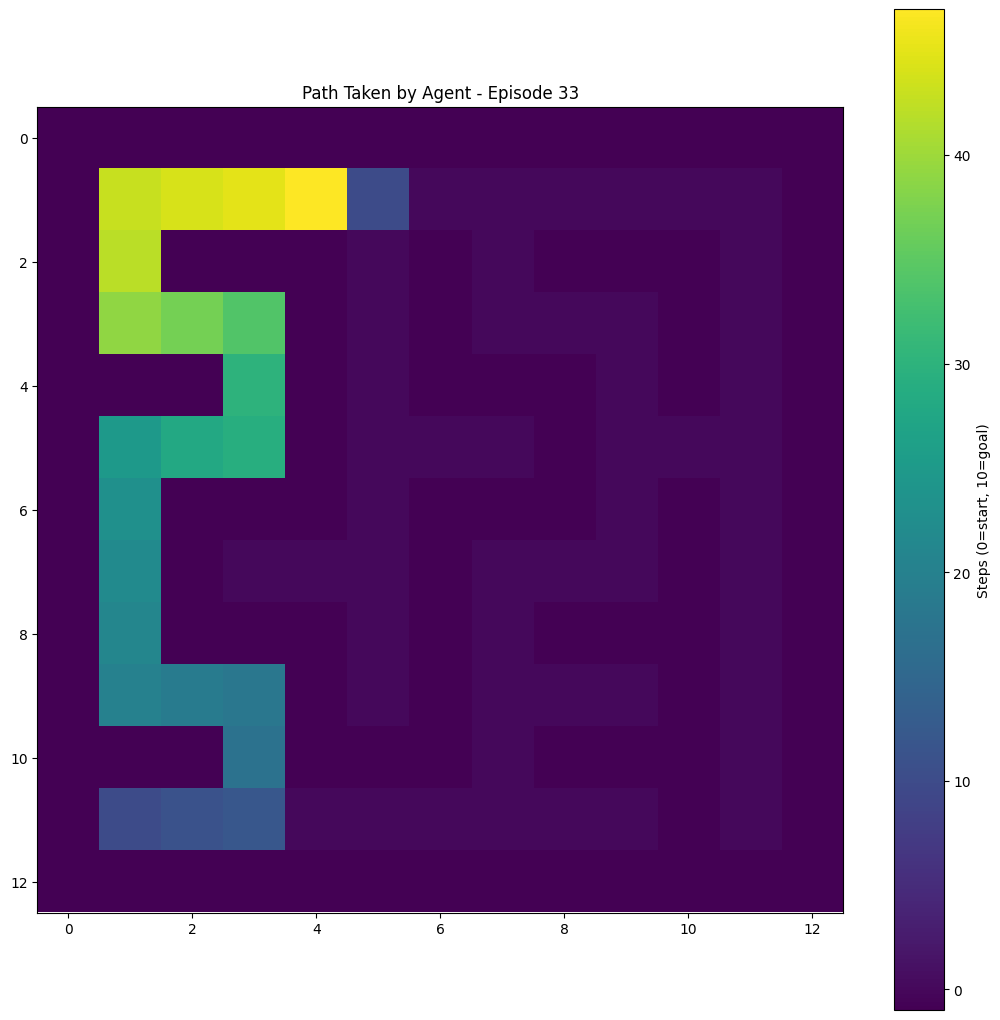

Episode 34 completed with 53 steps, average loss 1.3146075977469391 and total reward 62.5


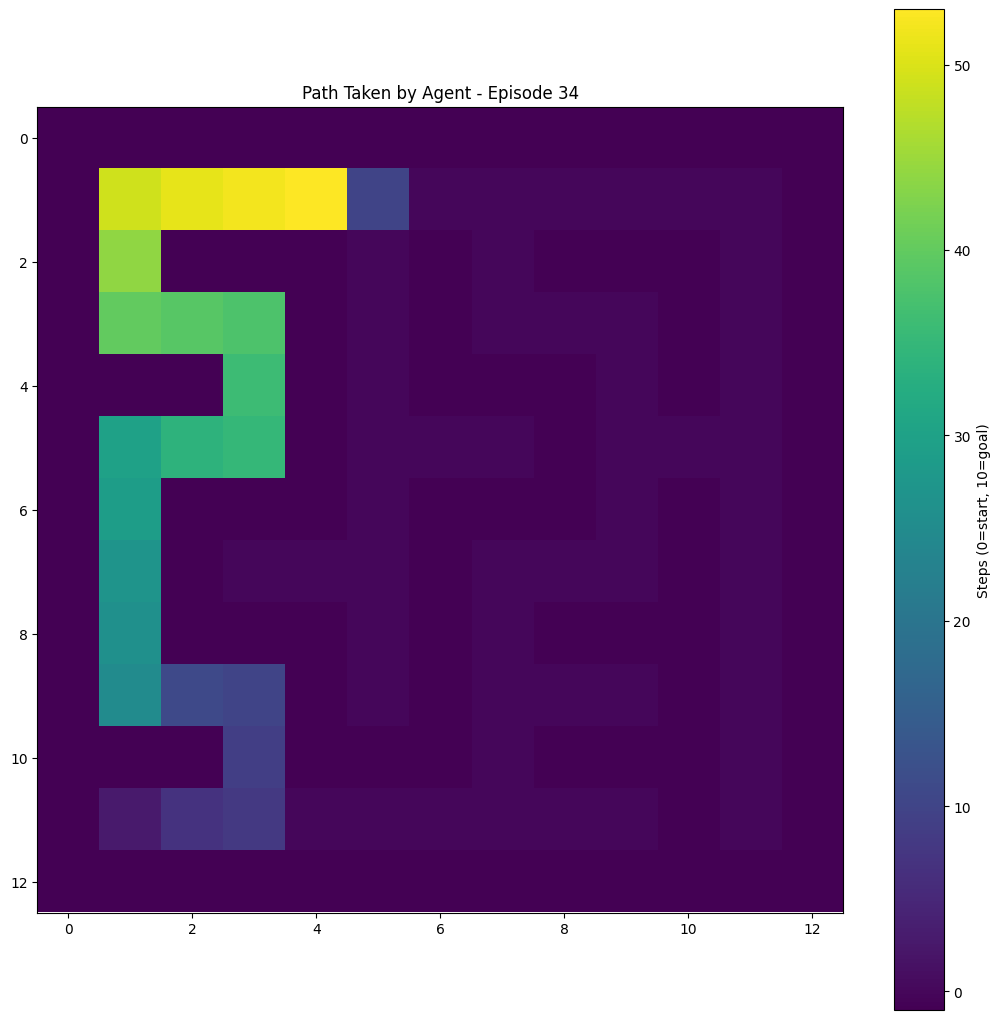

Episode 35 completed with 49 steps, average loss 1.2346783085745208 and total reward 67.5


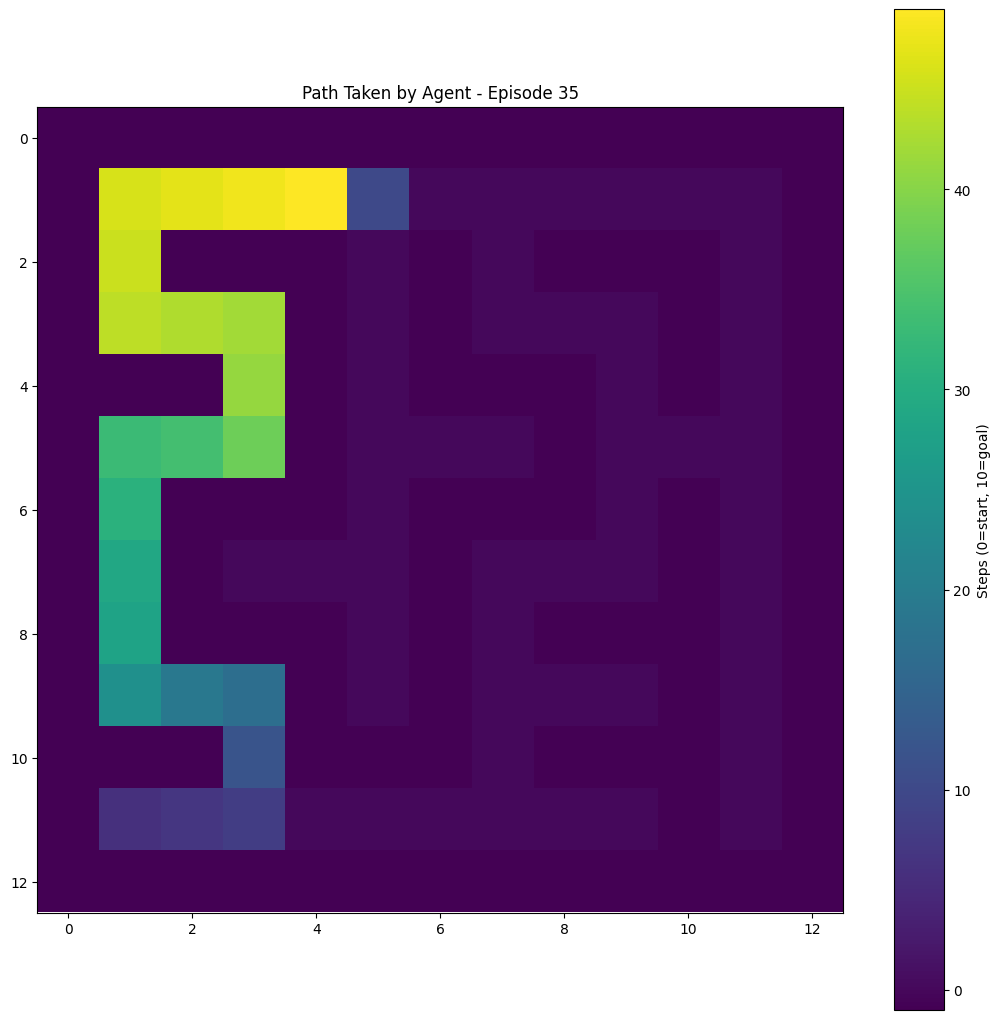

Episode 36 completed with 47 steps, average loss 1.1447260443200455 and total reward 67.5


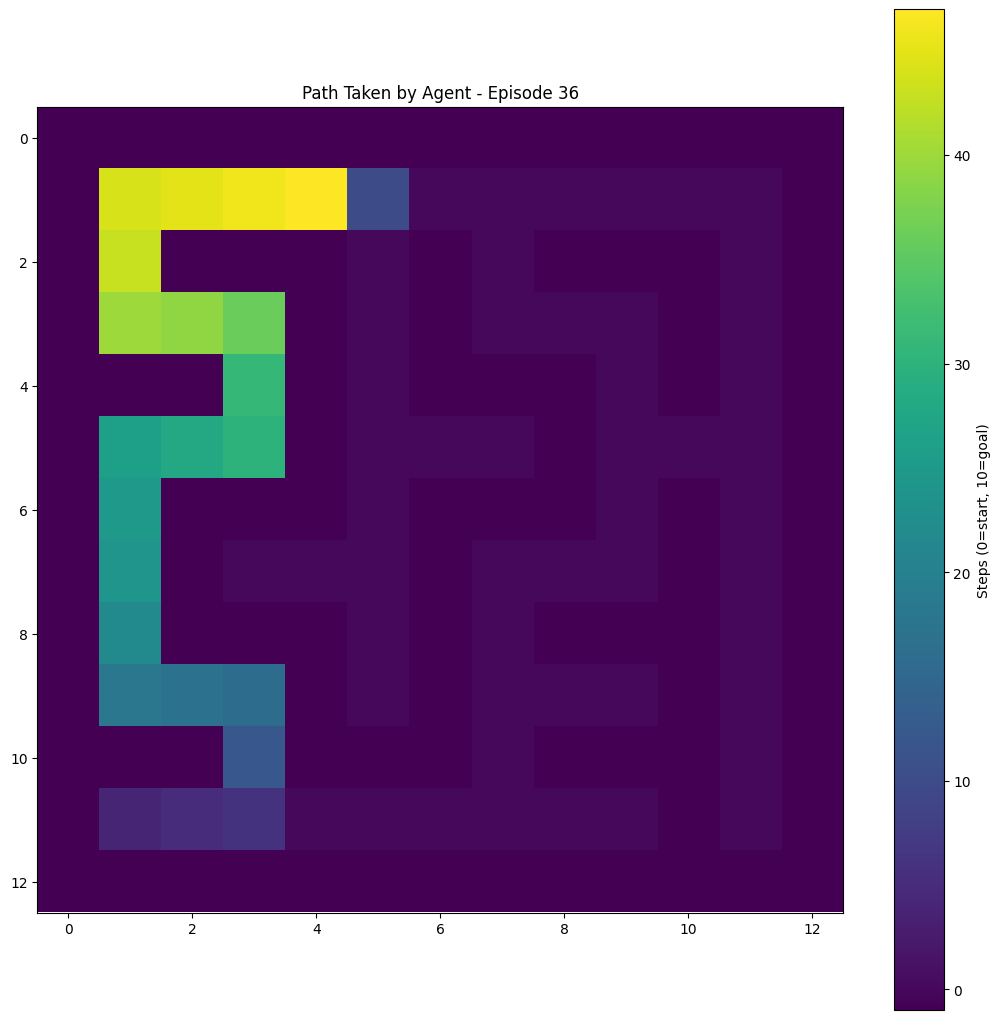

Episode 37 completed with 49 steps, average loss 1.2065749150149676 and total reward 68.5


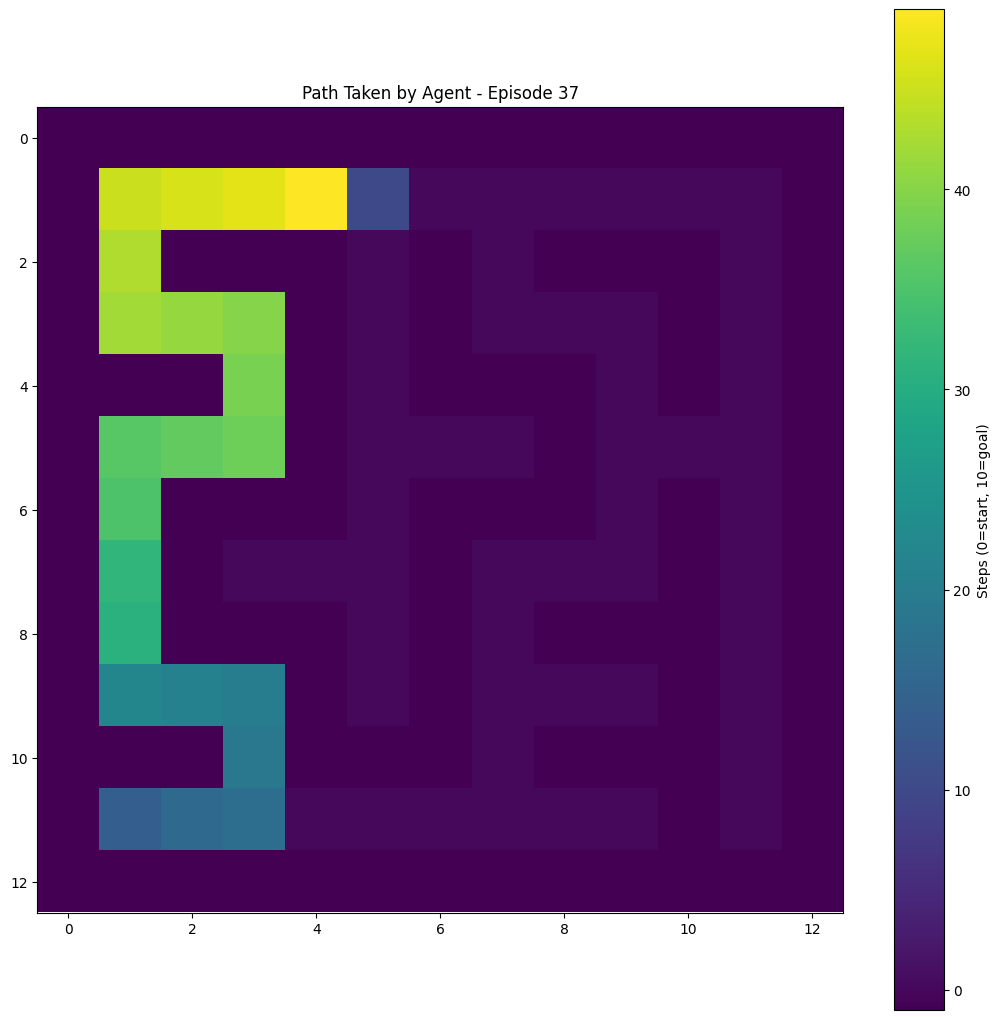

Episode 38 completed with 39 steps, average loss 1.1776633514807775 and total reward 74.5


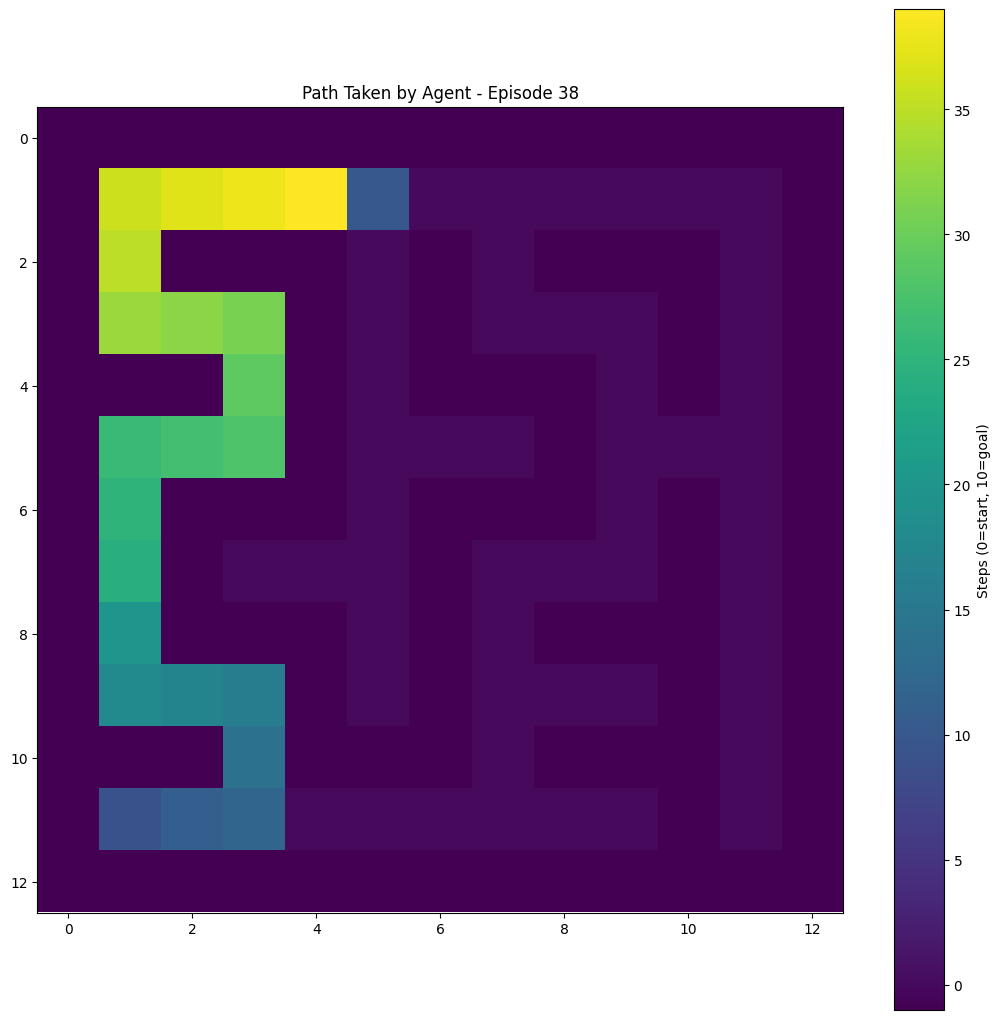

Episode 39 completed with 39 steps, average loss 1.2868588314606593 and total reward 74.5


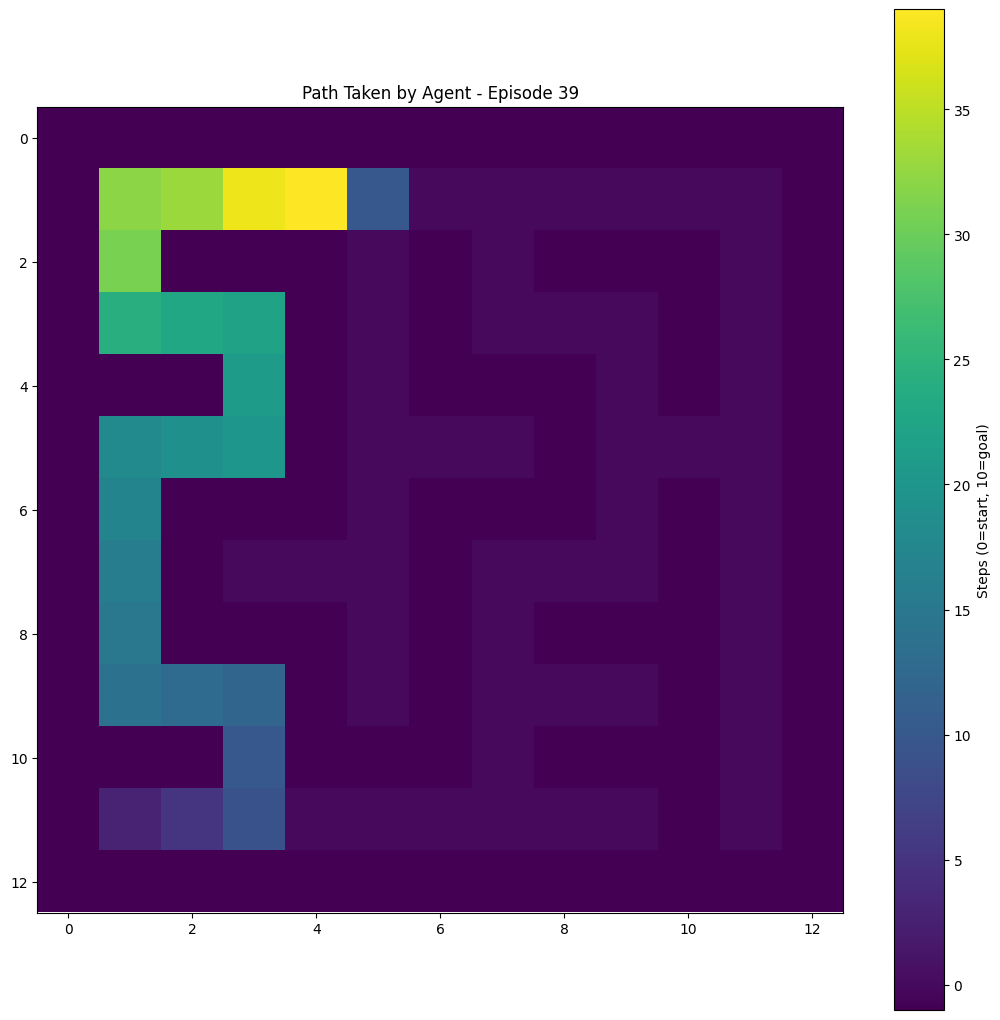

Episode 40 completed with 40 steps, average loss 1.222960877418518 and total reward 73.5


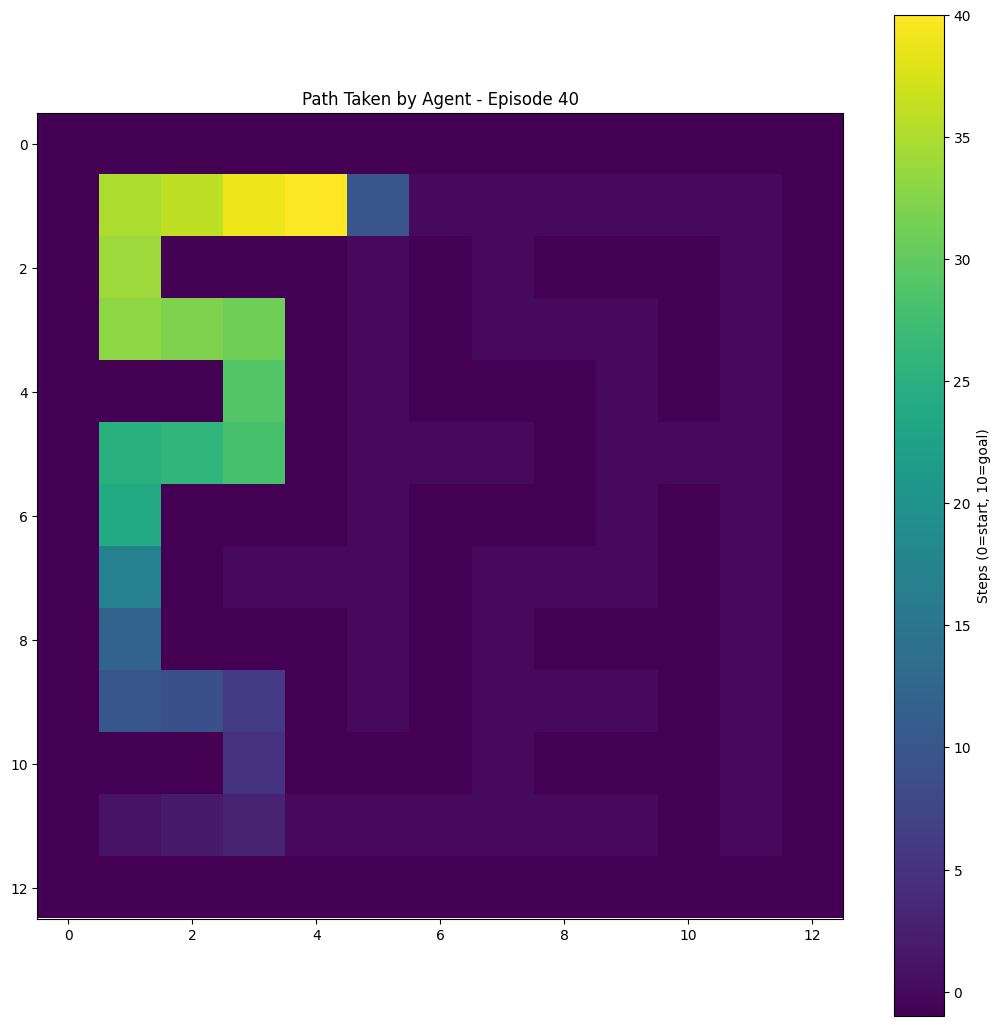

Episode 41 completed with 56 steps, average loss 1.3995112947055273 and total reward 62.5


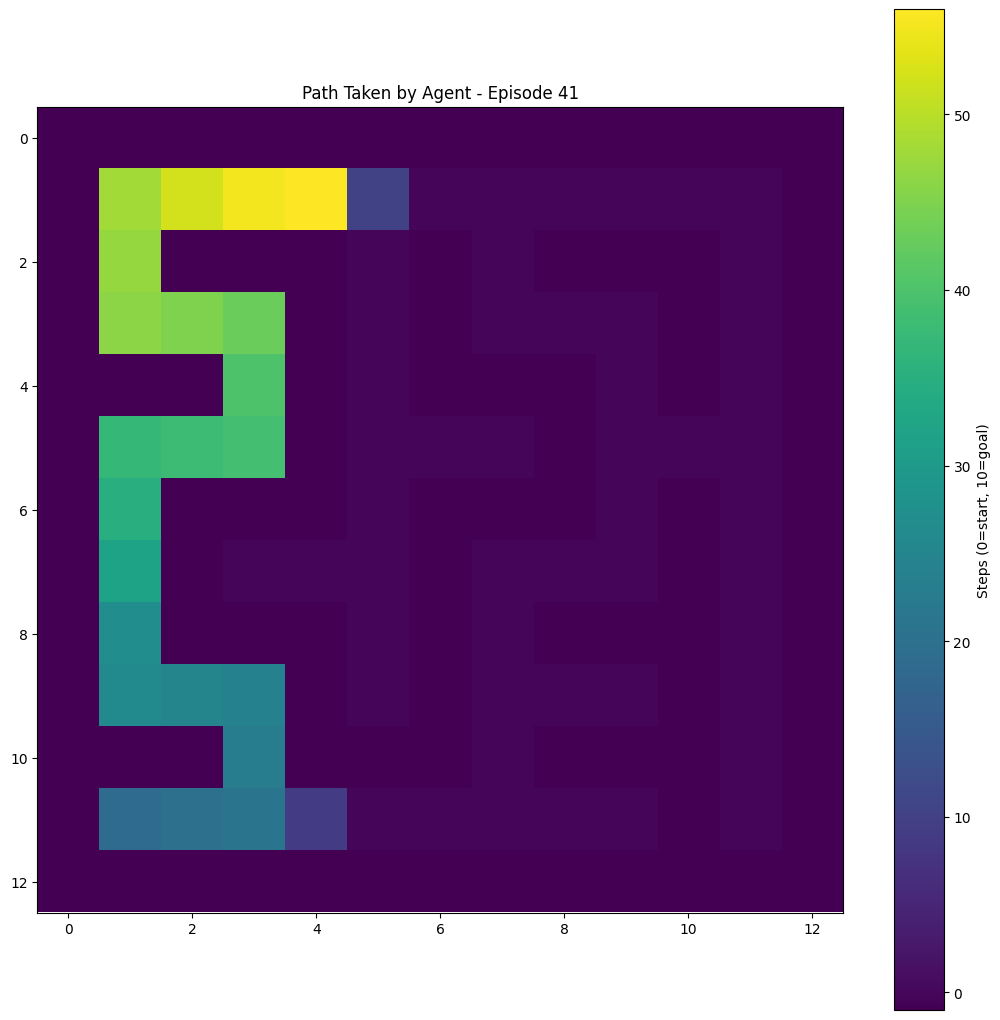

Episode 42 completed with 39 steps, average loss 1.2667401555256965 and total reward 74.5


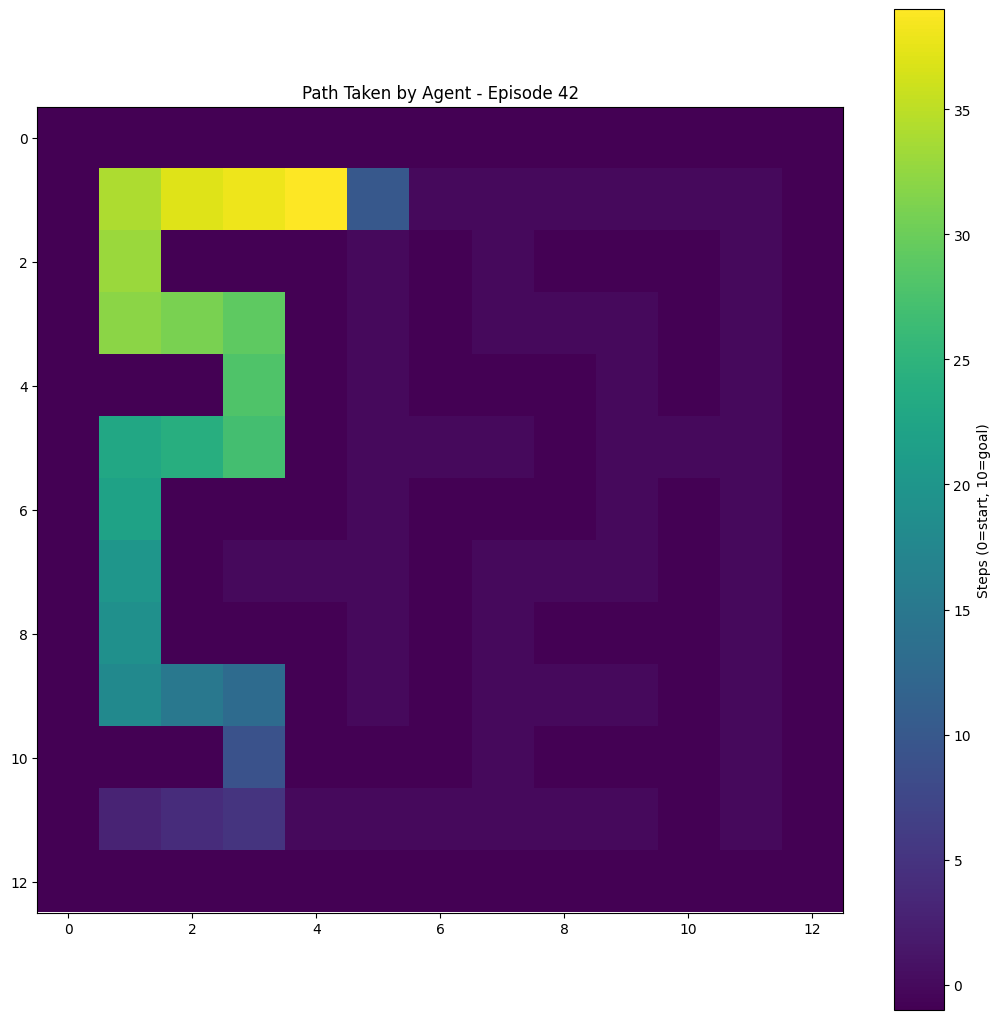

Episode 43 completed with 37 steps, average loss 1.059575883117882 and total reward 75.5


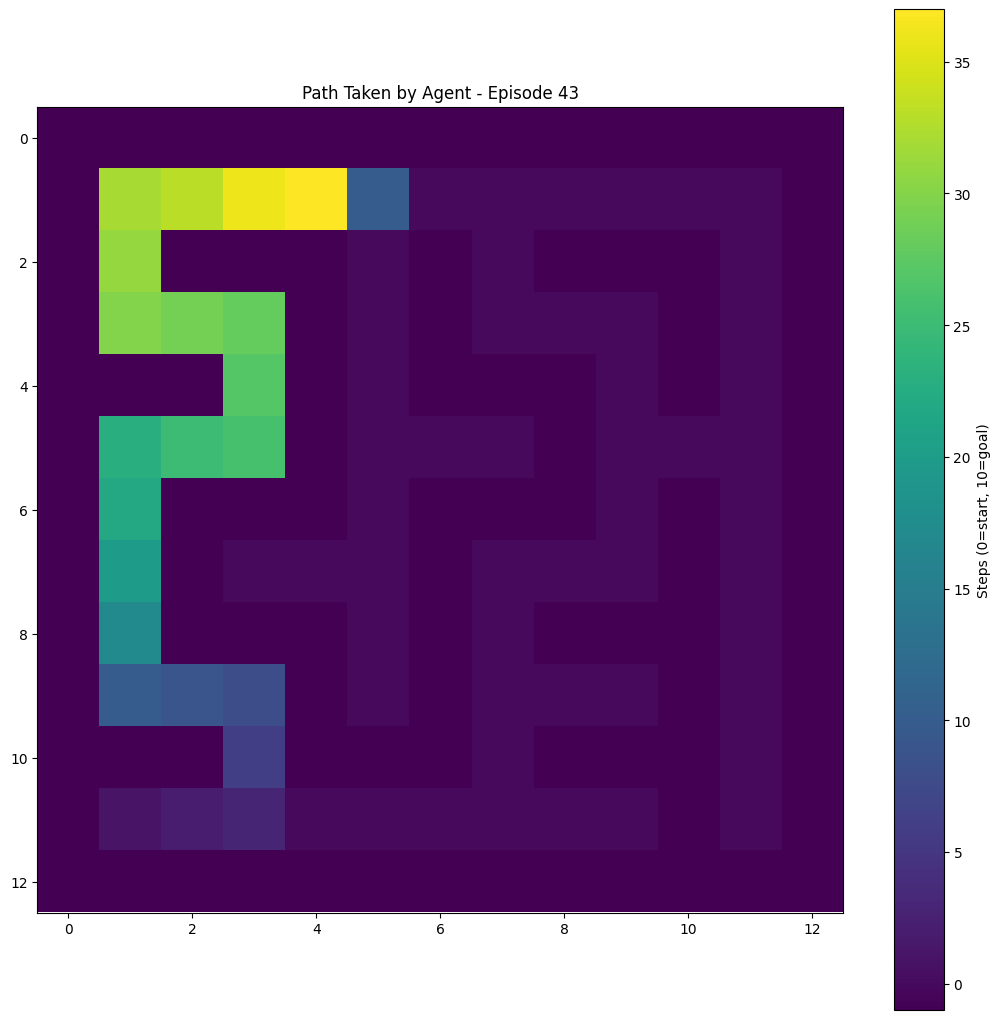

Episode 44 completed with 40 steps, average loss 1.2919916734099388 and total reward 73.5


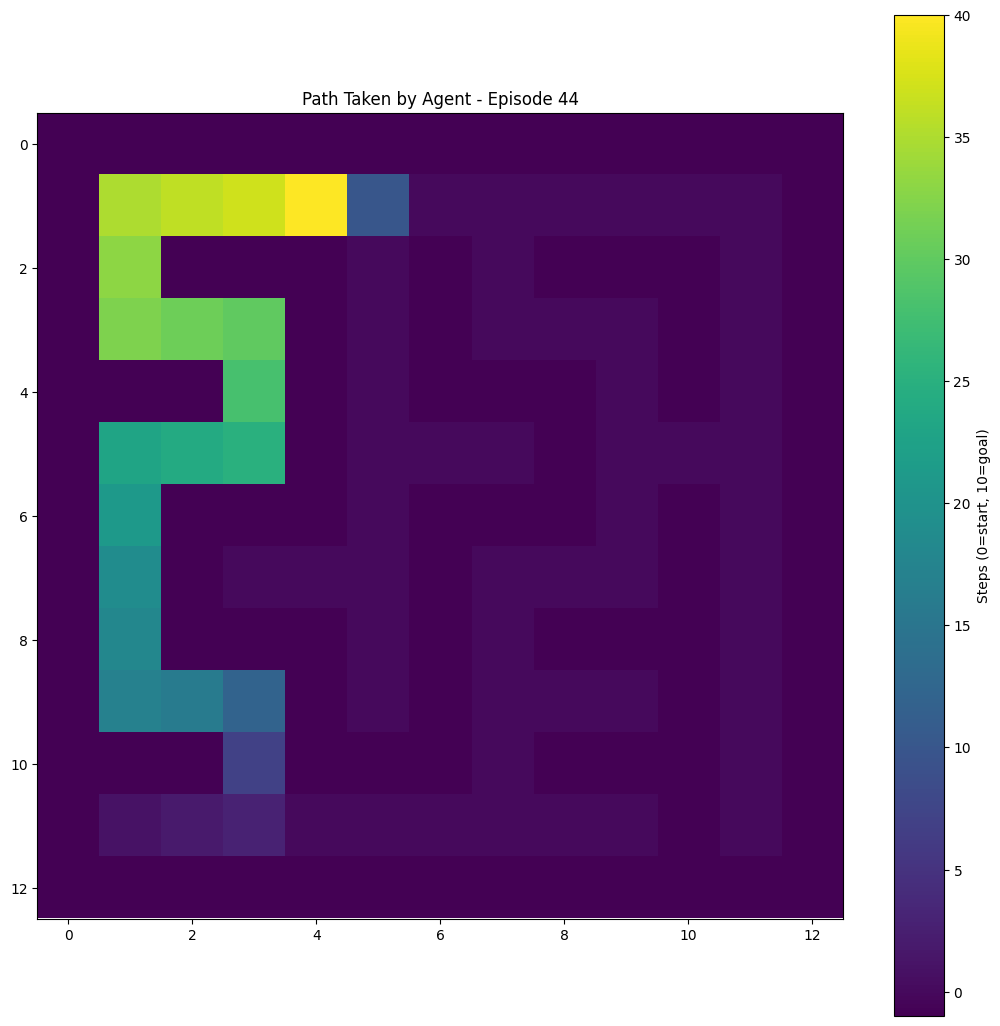

Episode 45 completed with 36 steps, average loss 1.0258612400955625 and total reward 76.5


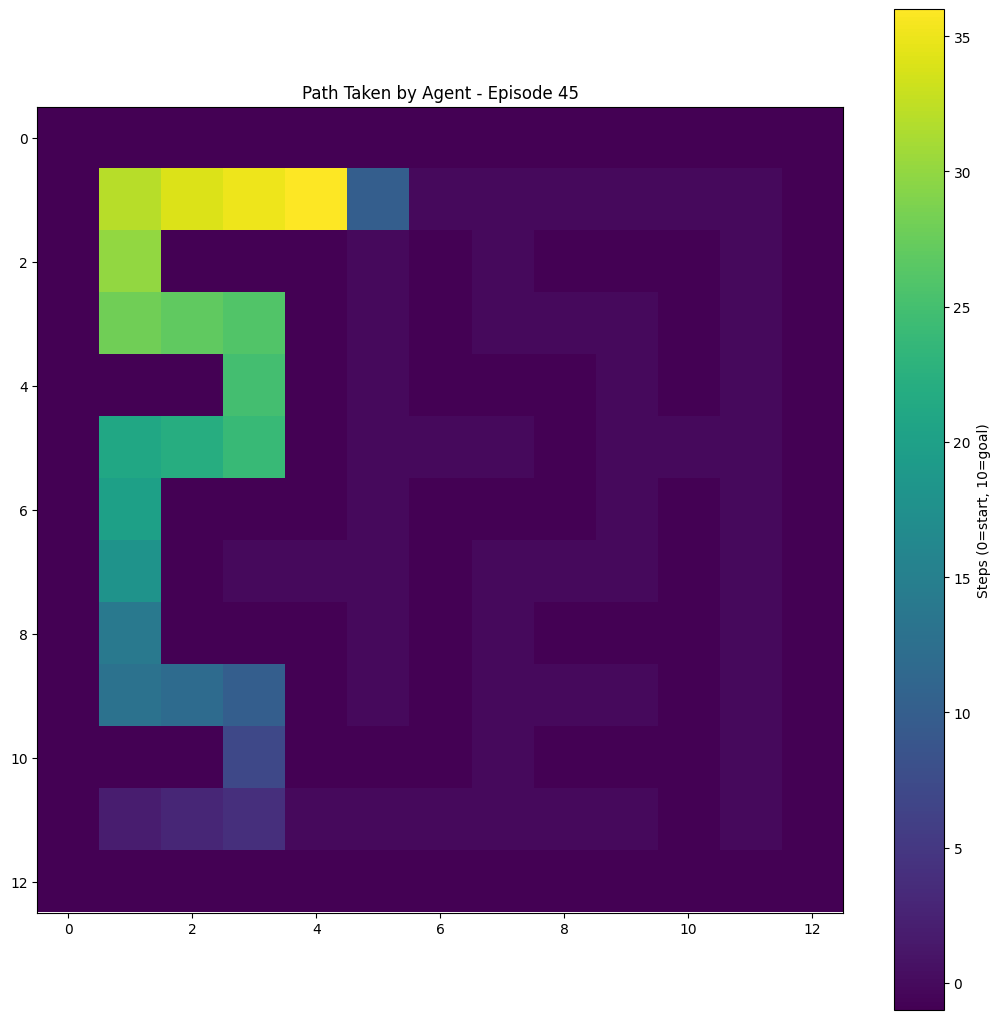

Episode 46 completed with 42 steps, average loss 0.9240188428333828 and total reward 71.5


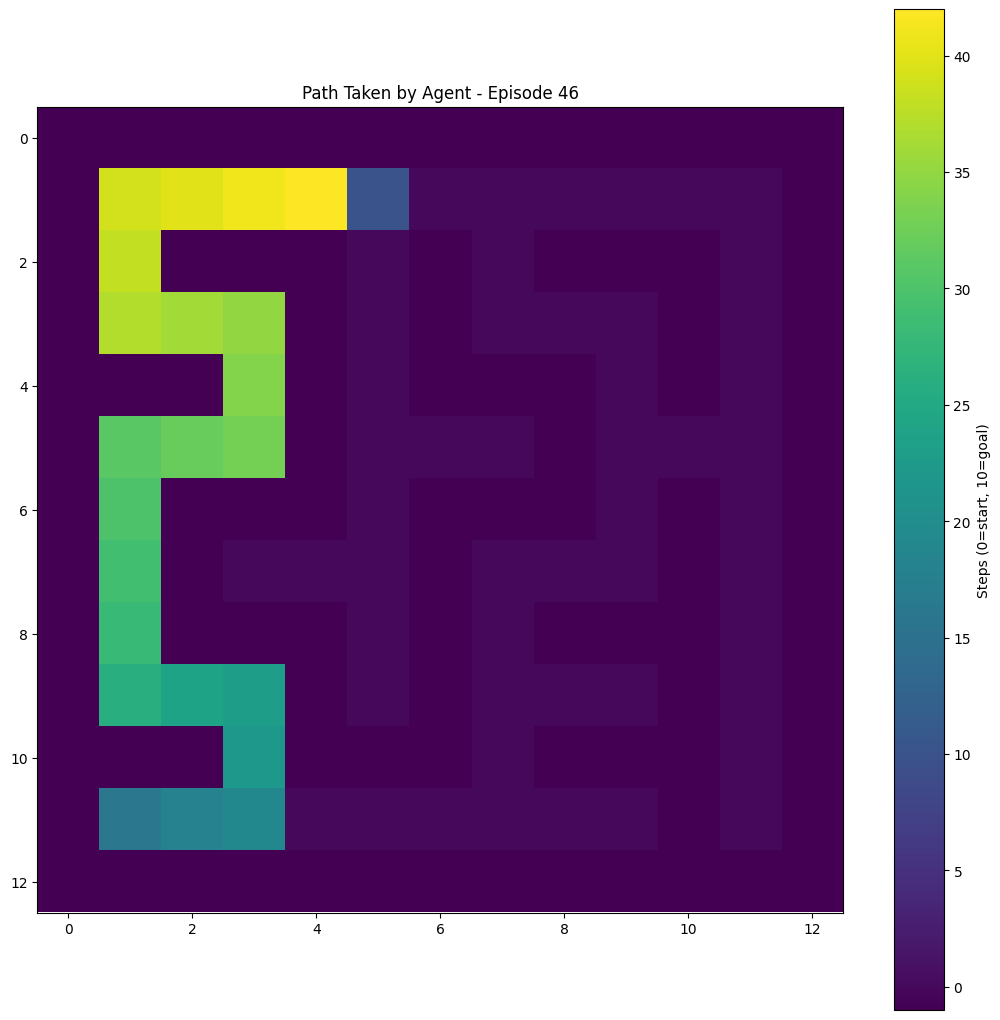

Episode 47 completed with 35 steps, average loss 1.0765023606164115 and total reward 77.5


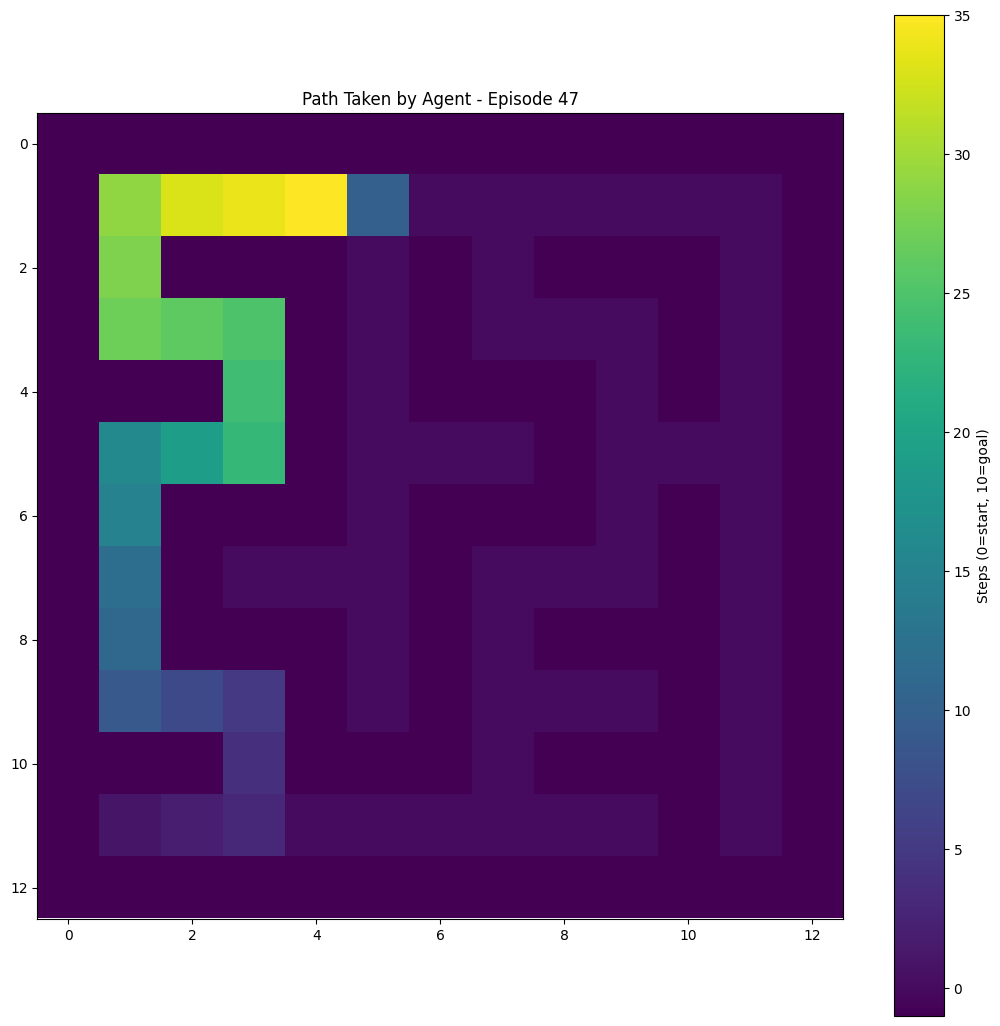

Episode 48 completed with 43 steps, average loss 1.0659317665321881 and total reward 71.5


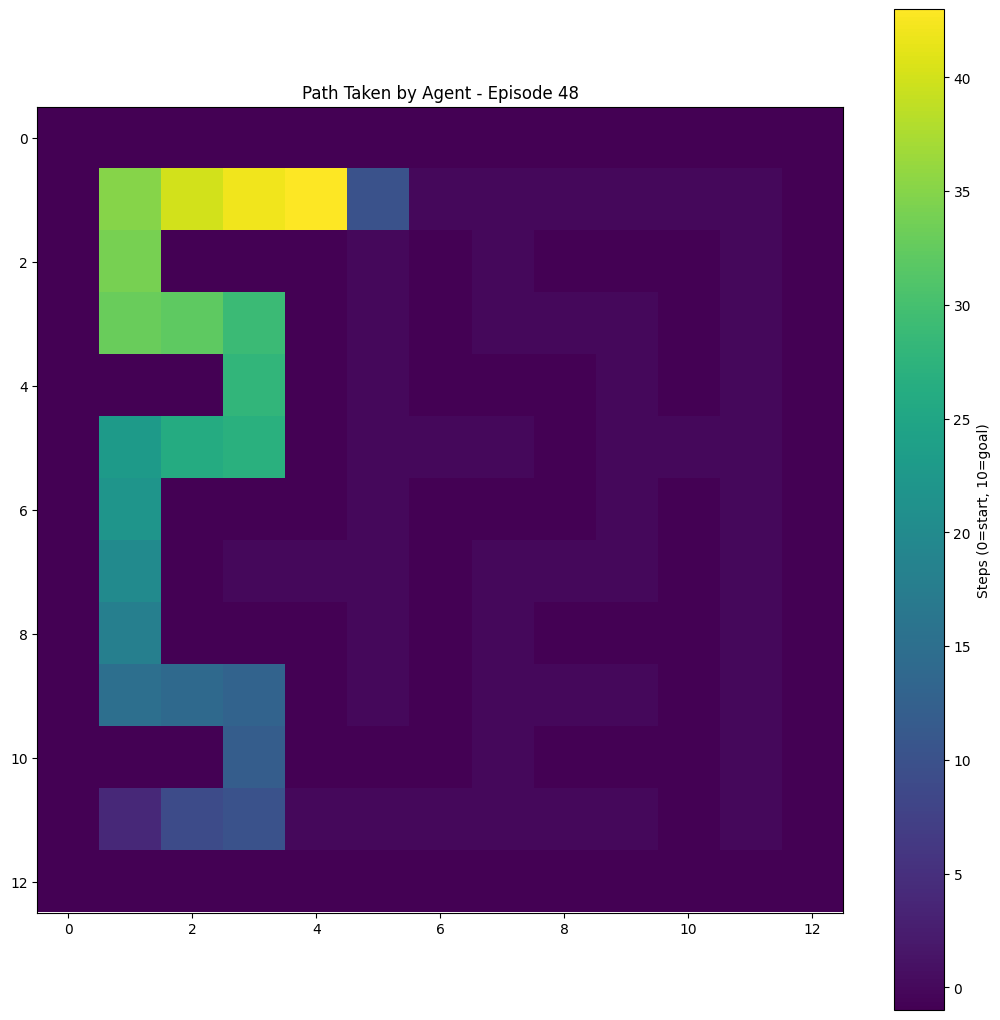

Episode 49 completed with 29 steps, average loss 1.18102090728694 and total reward 82.5


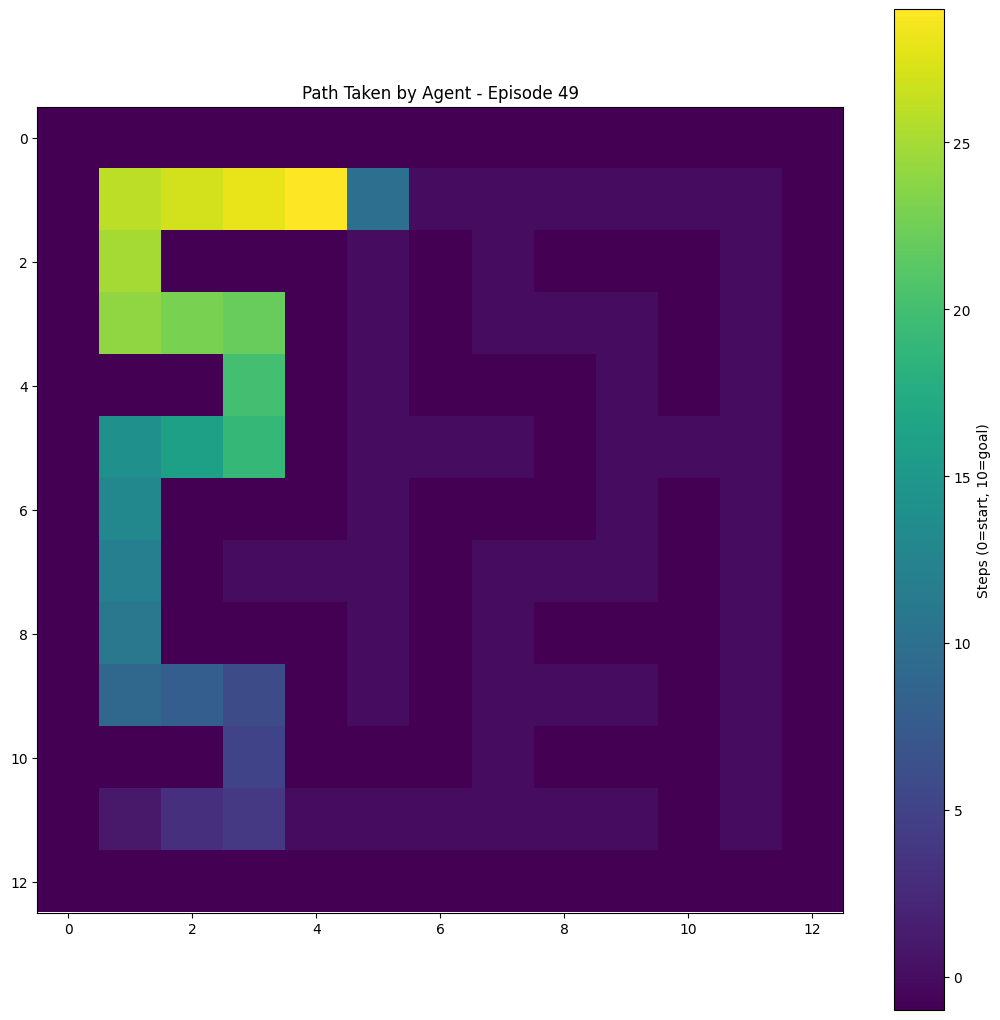

Episode 50 completed with 69 steps, average loss 1.3321664151938066 and total reward 48.5
Episode 51 completed with 32 steps, average loss 1.1672681663185358 and total reward 79.5


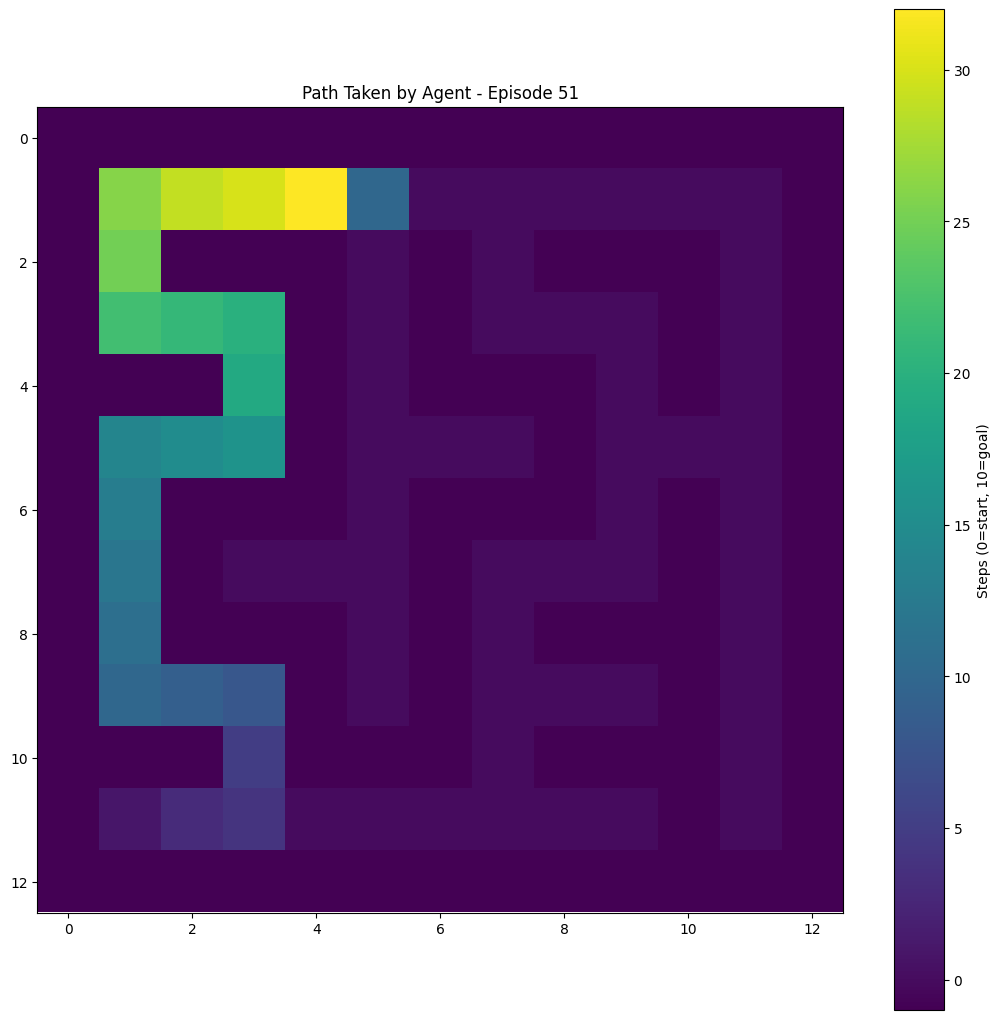

Episode 52 completed with 47 steps, average loss 1.4770349517781685 and total reward 69.5


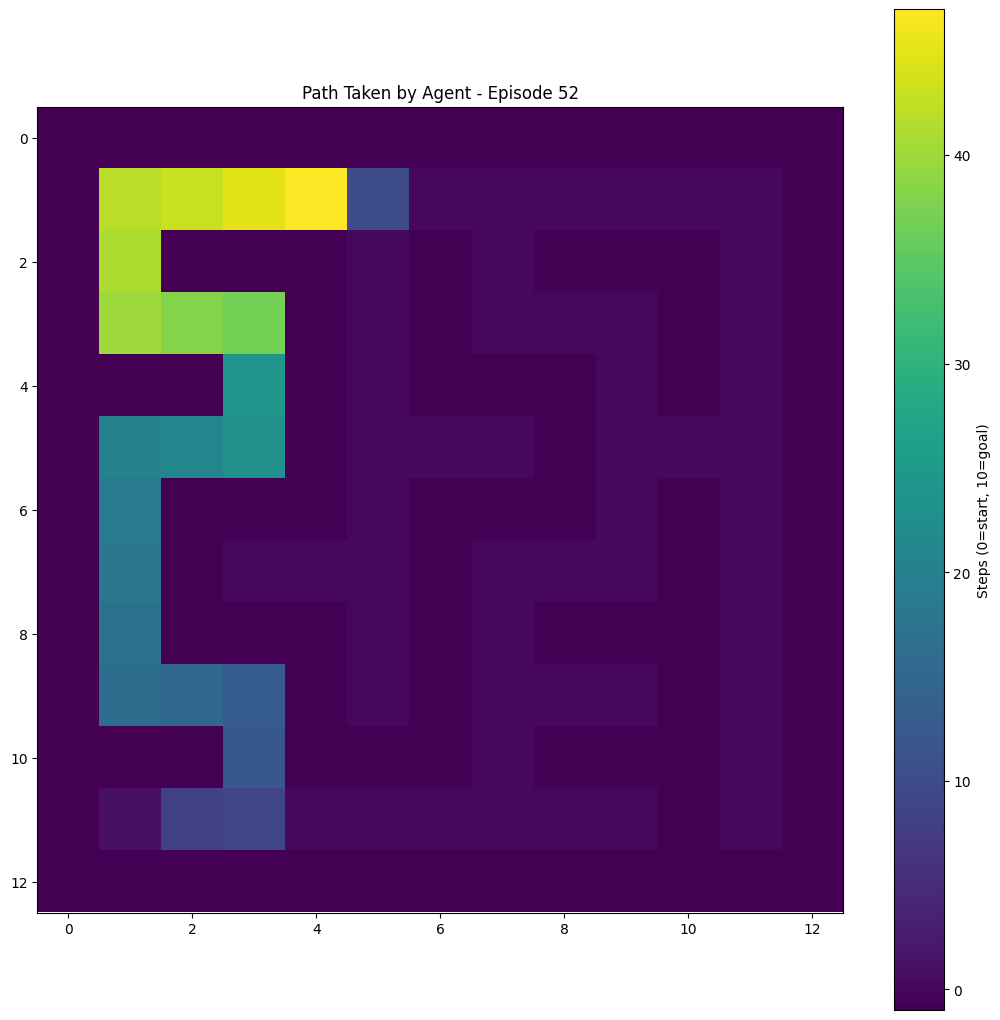

Episode 53 completed with 49 steps, average loss 1.0897635653310893 and total reward 65.5


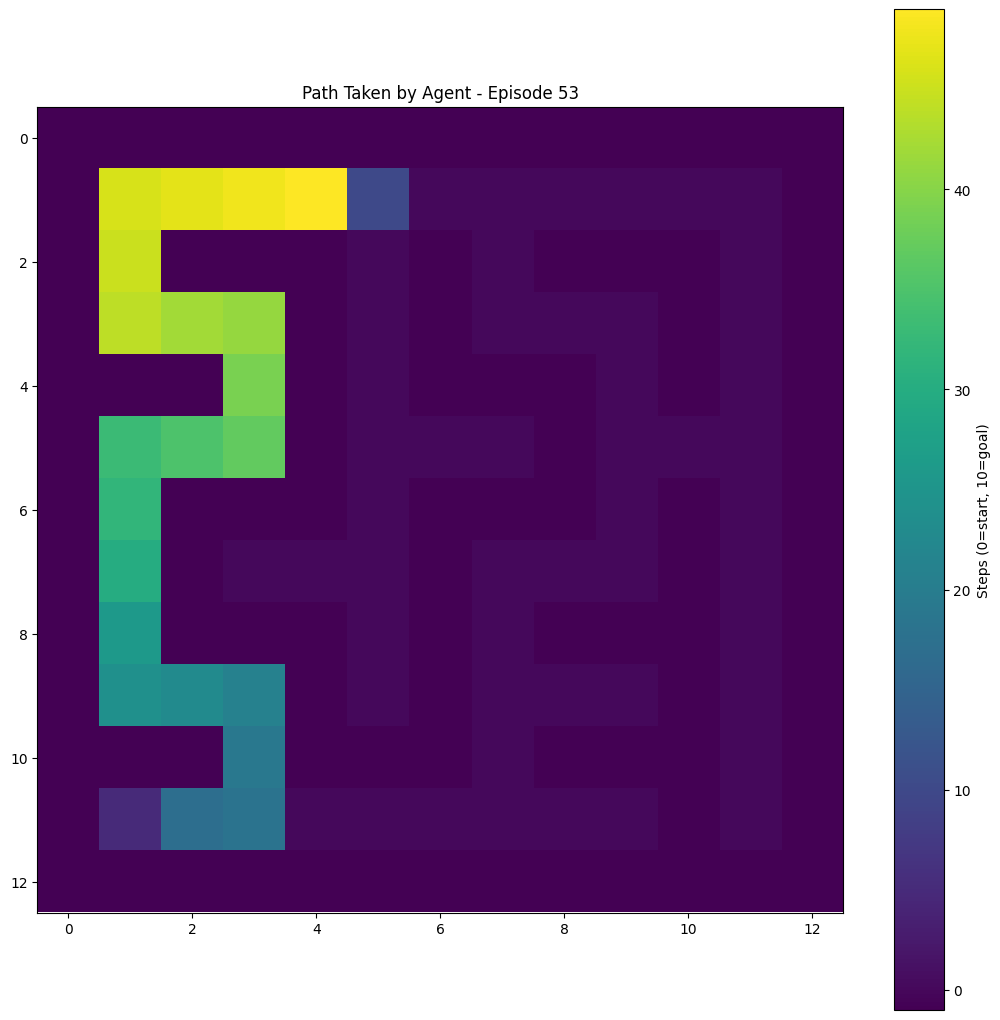

Episode 54 completed with 29 steps, average loss 1.067865817711271 and total reward 83.5


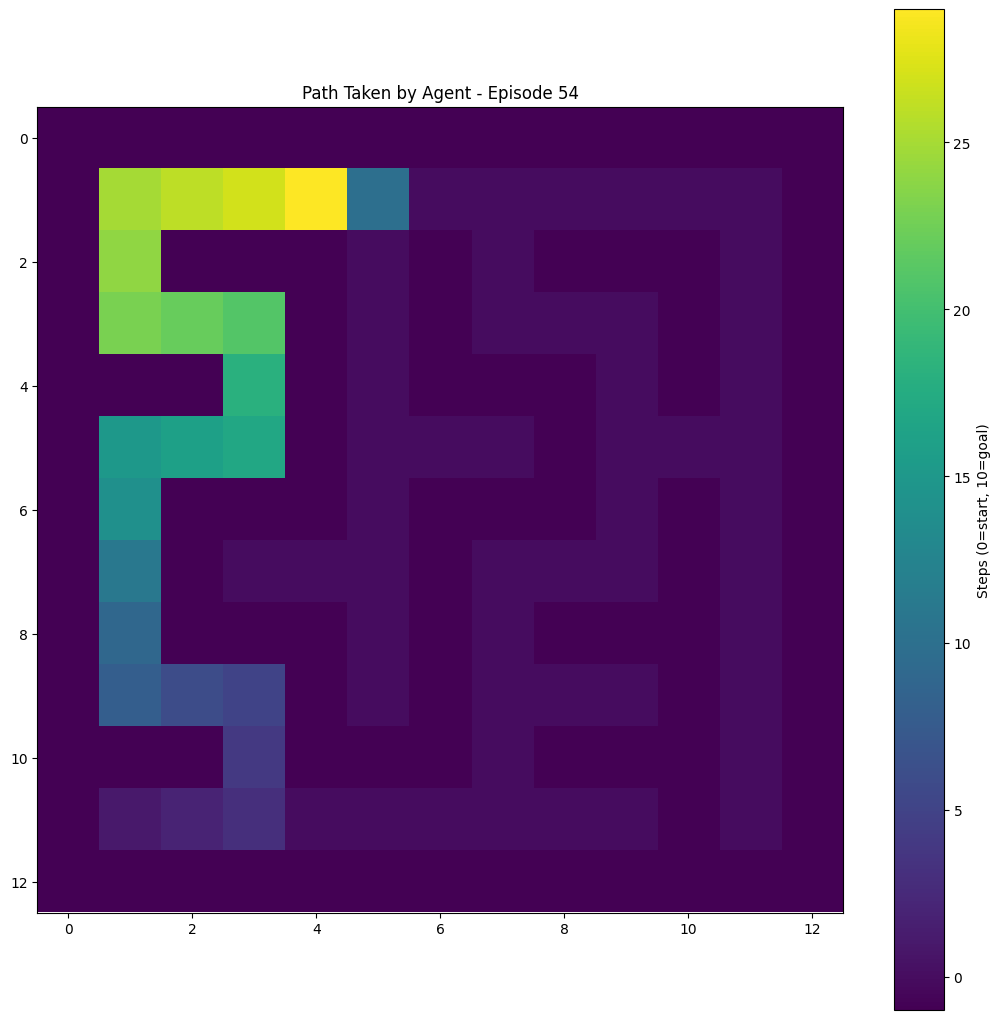

Episode 55 completed with 43 steps, average loss 1.1129424585852512 and total reward 70.5


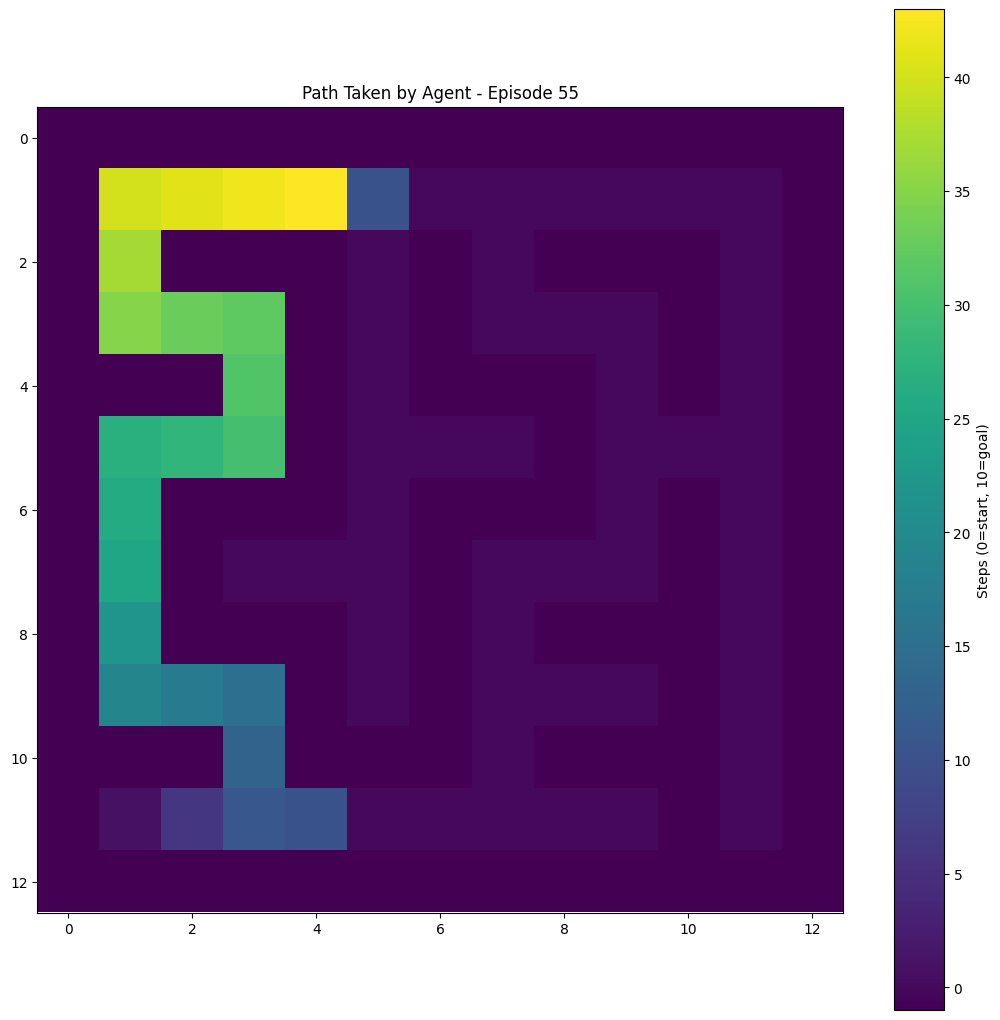

Episode 56 completed with 35 steps, average loss 1.137321811062949 and total reward 79.5


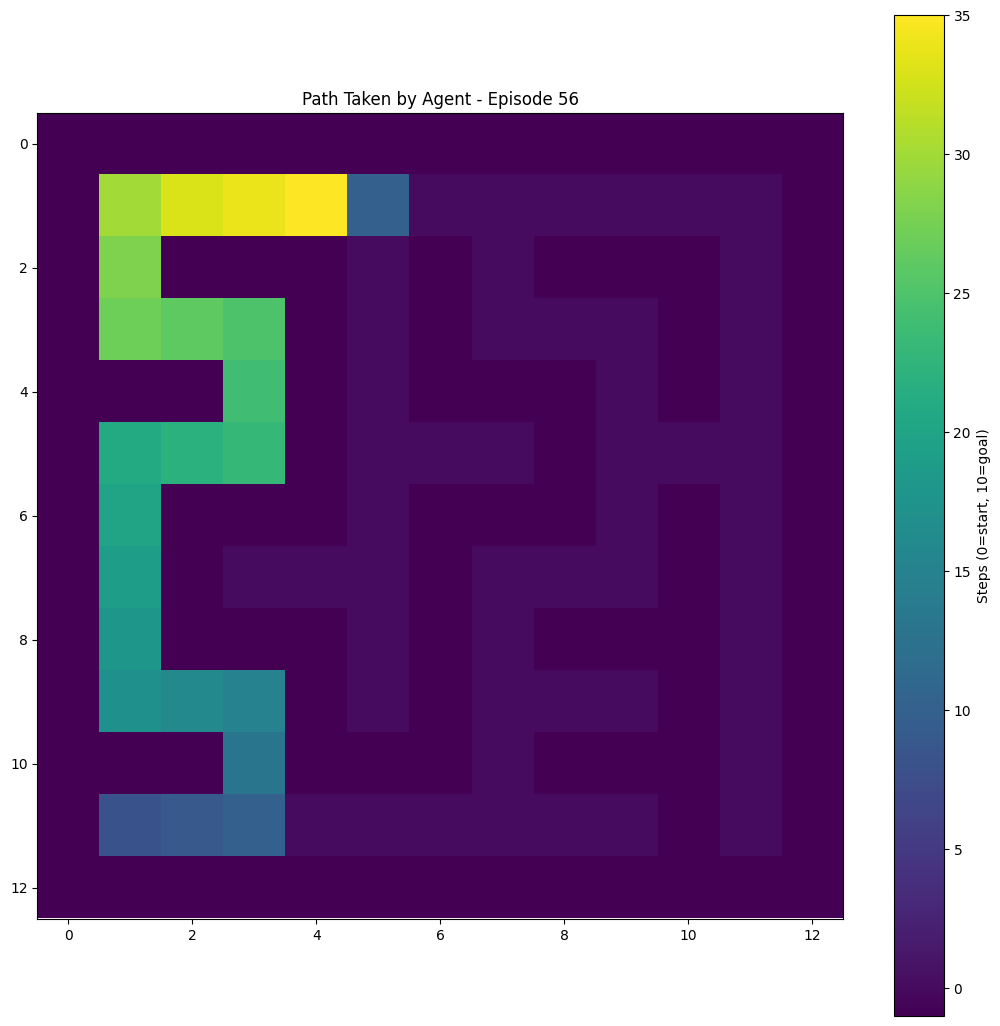

Episode 57 completed with 39 steps, average loss 1.2444342863865387 and total reward 78.5


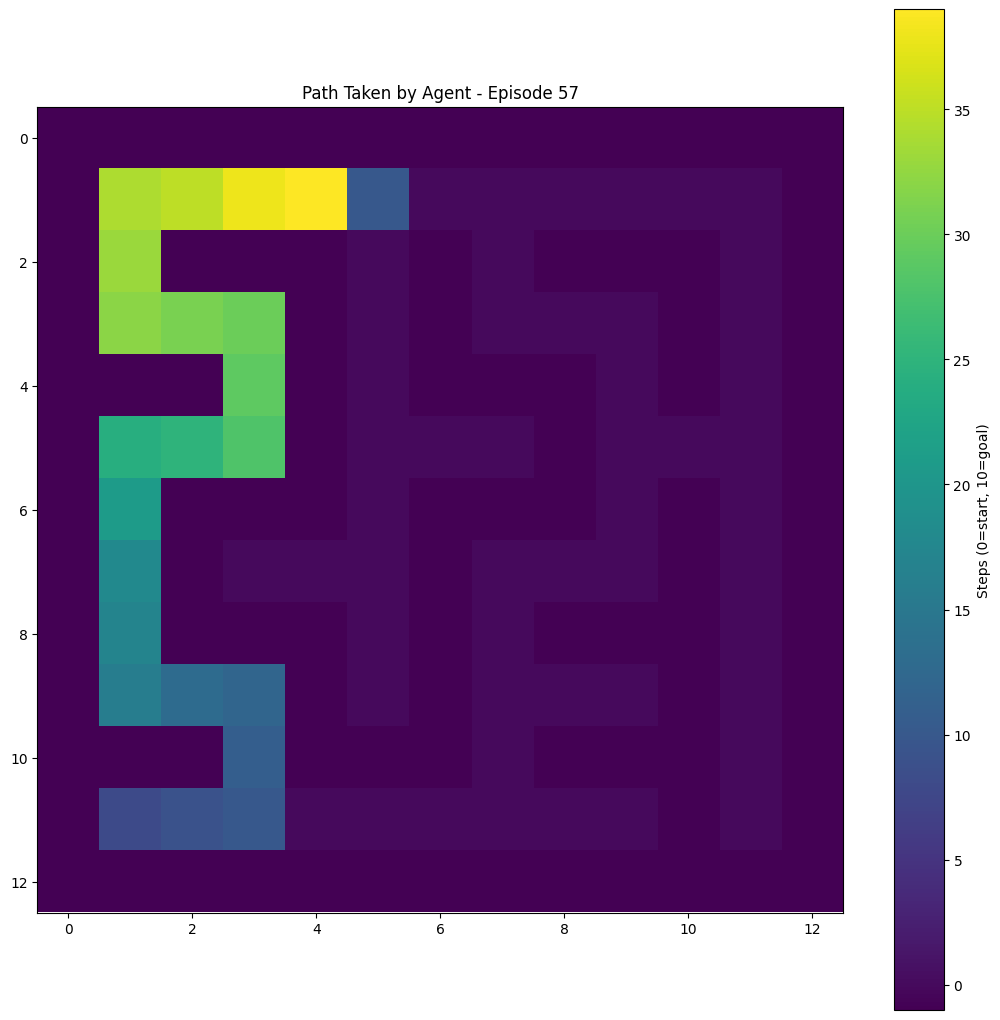

Episode 58 completed with 41 steps, average loss 1.4389626165715659 and total reward 76.5


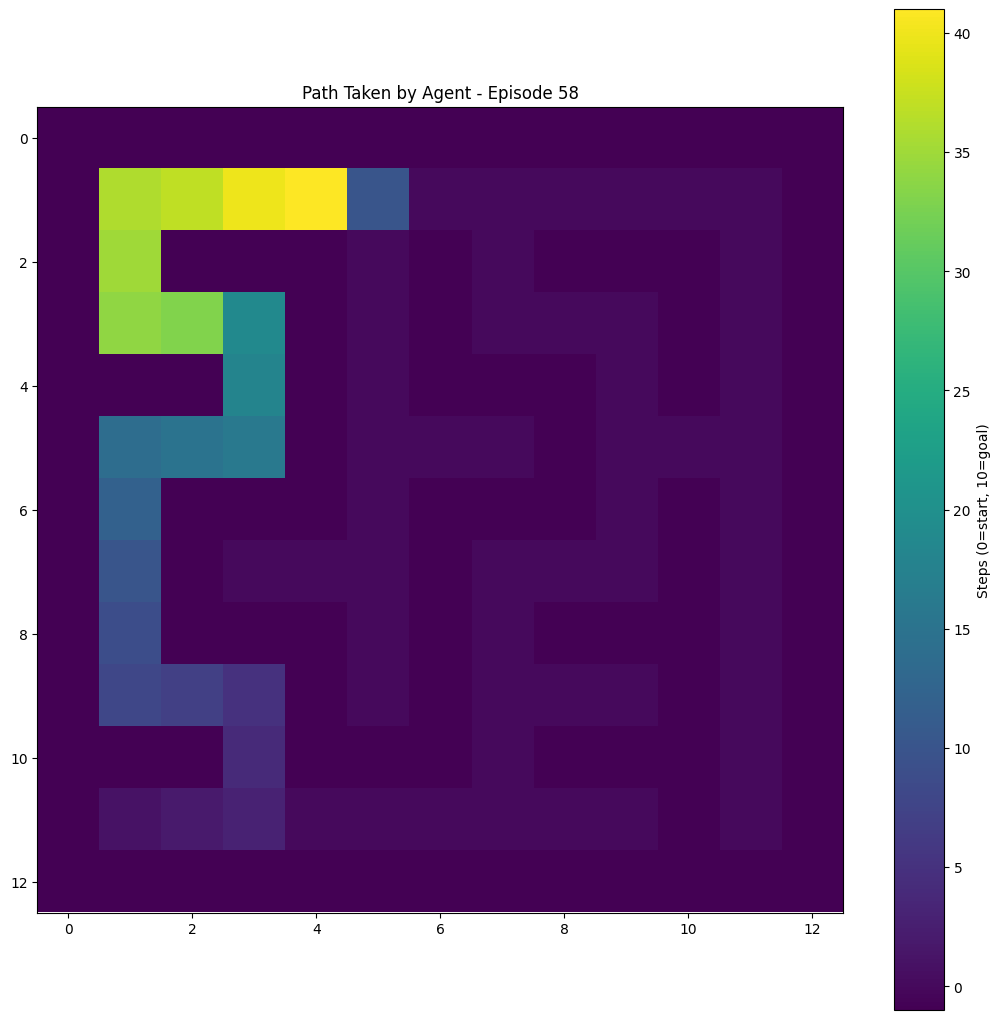

Episode 59 completed with 41 steps, average loss 1.4291120782131101 and total reward 73.5


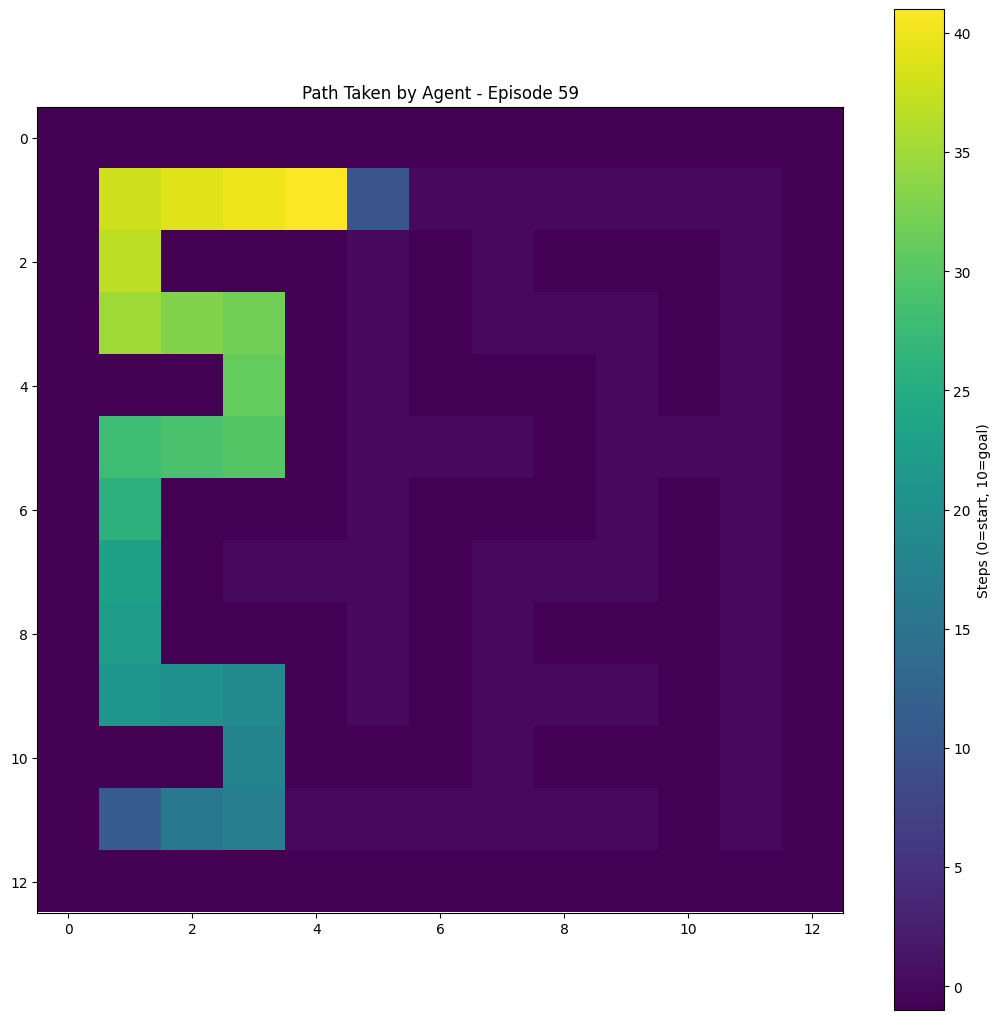

Episode 60 completed with 55 steps, average loss 1.2405420064926147 and total reward 62.5


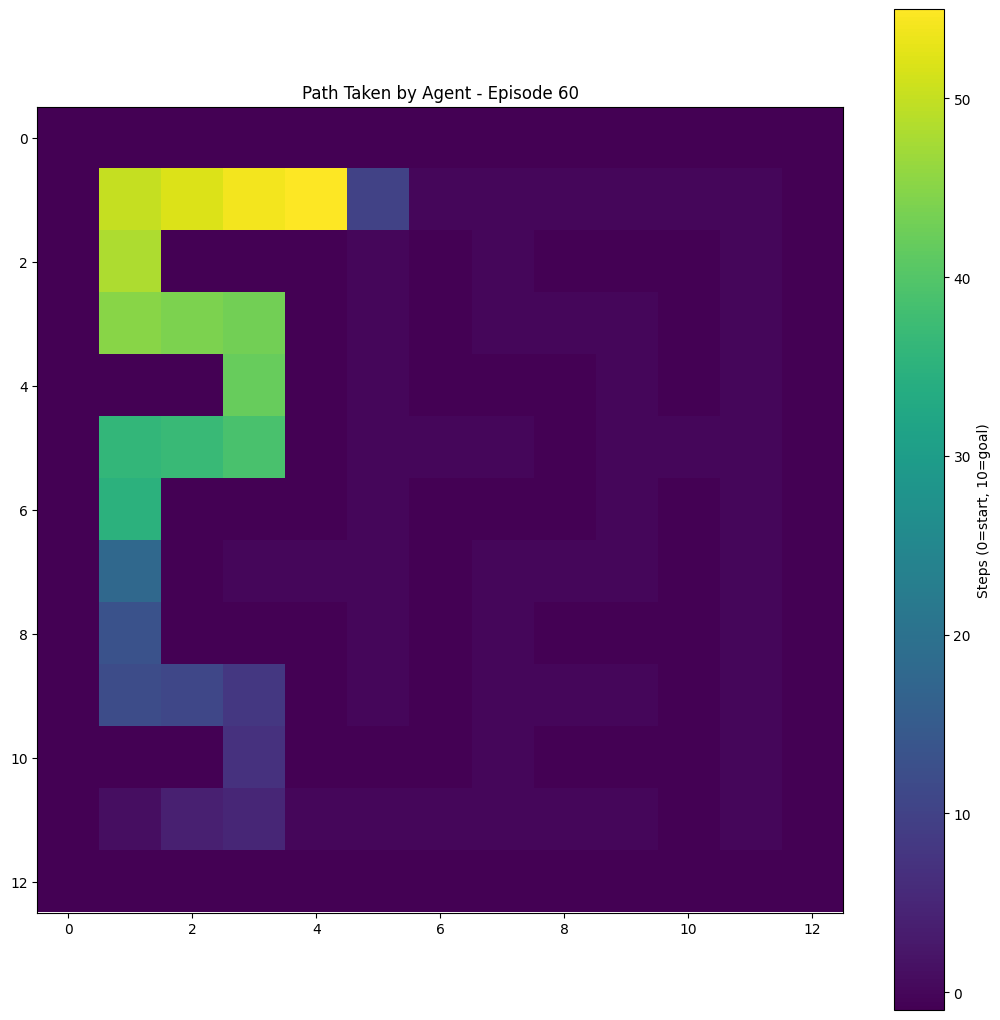

Episode 61 completed with 61 steps, average loss 1.3385103256976019 and total reward 57.5
Episode 62 completed with 56 steps, average loss 1.3758485269333636 and total reward 60.5


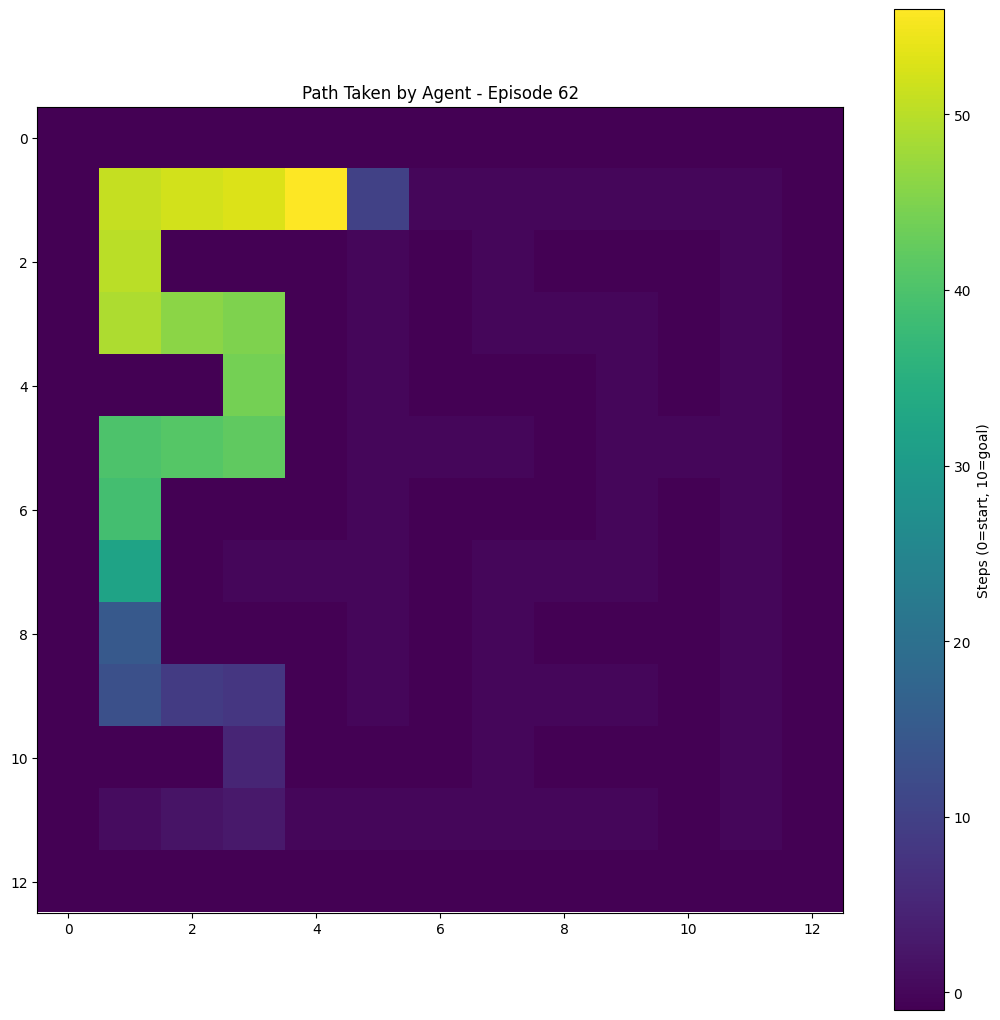

Episode 63 completed with 63 steps, average loss 1.5173603125980921 and total reward 56.5
Episode 64 completed with 25 steps, average loss 1.531456046104431 and total reward 86.5


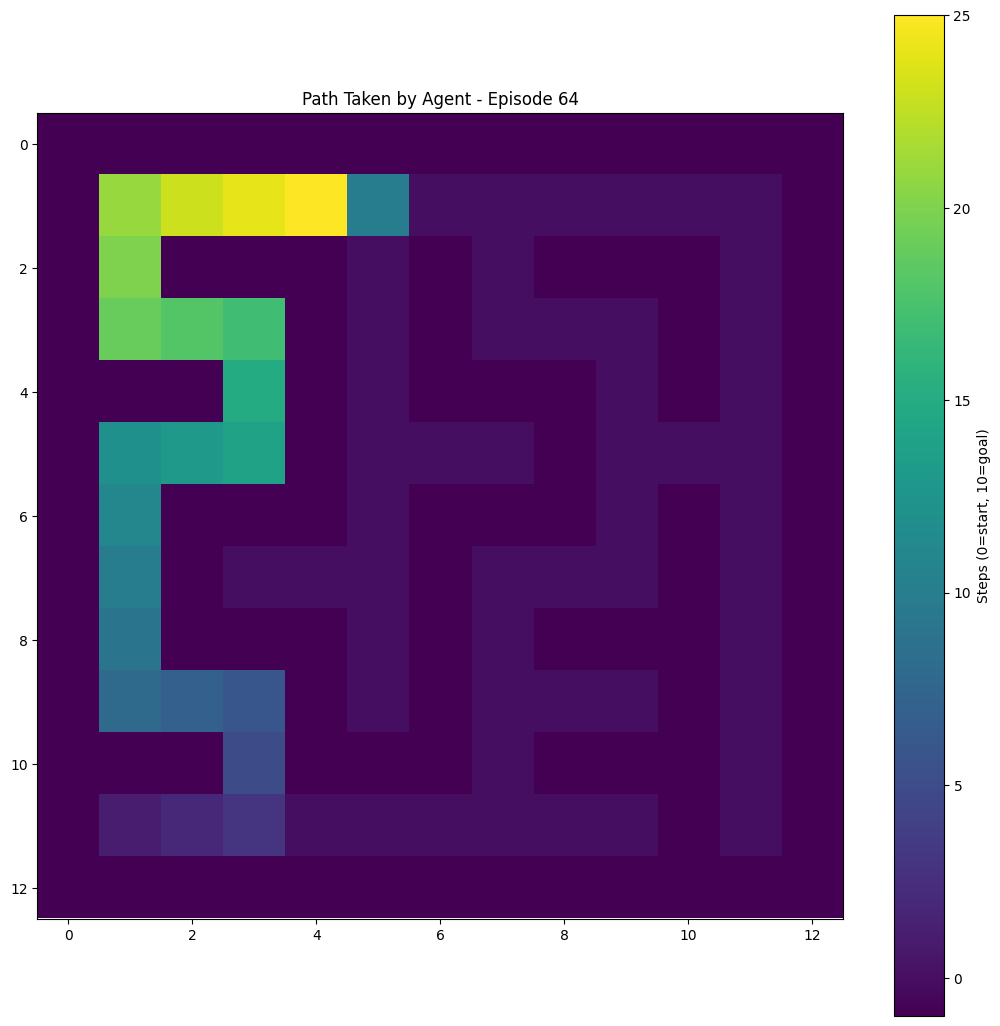

Episode 65 completed with 40 steps, average loss 1.491812814772129 and total reward 74.5


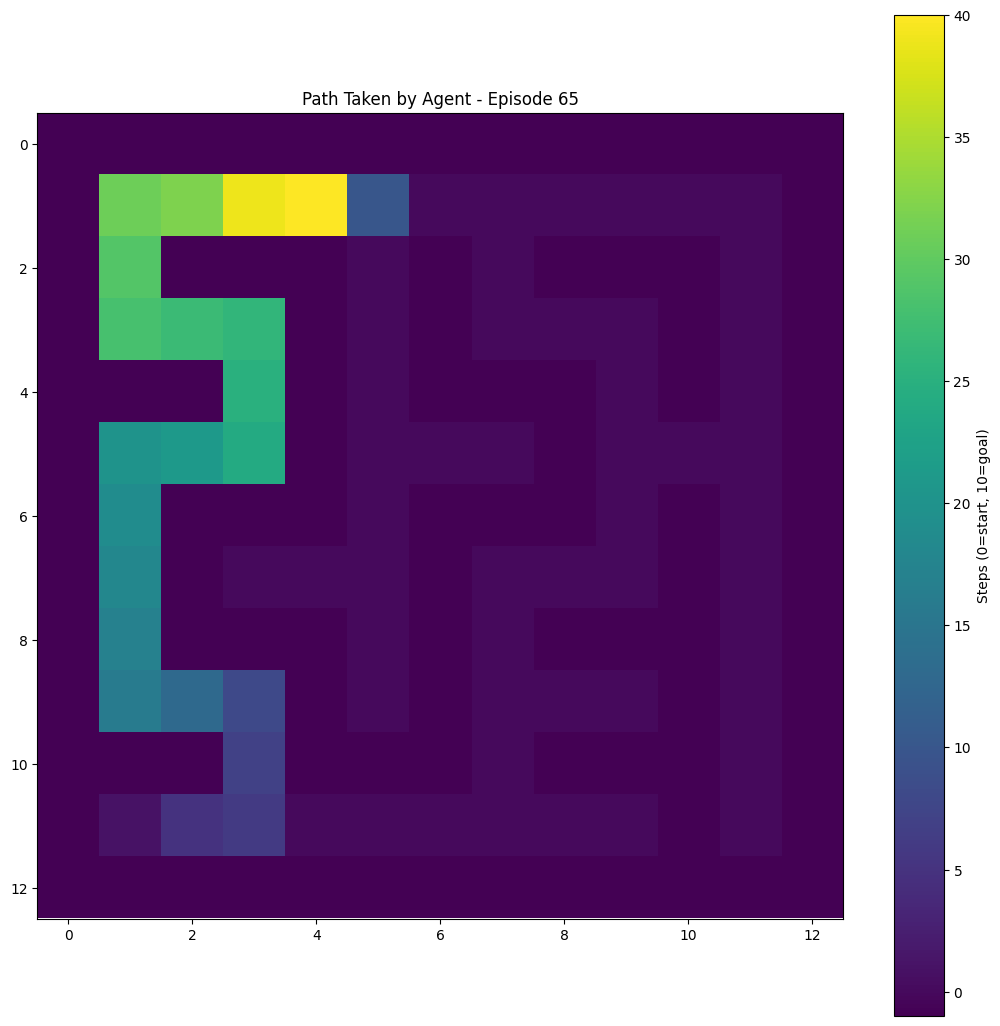

Episode 66 completed with 40 steps, average loss 1.315258364379406 and total reward 72.5


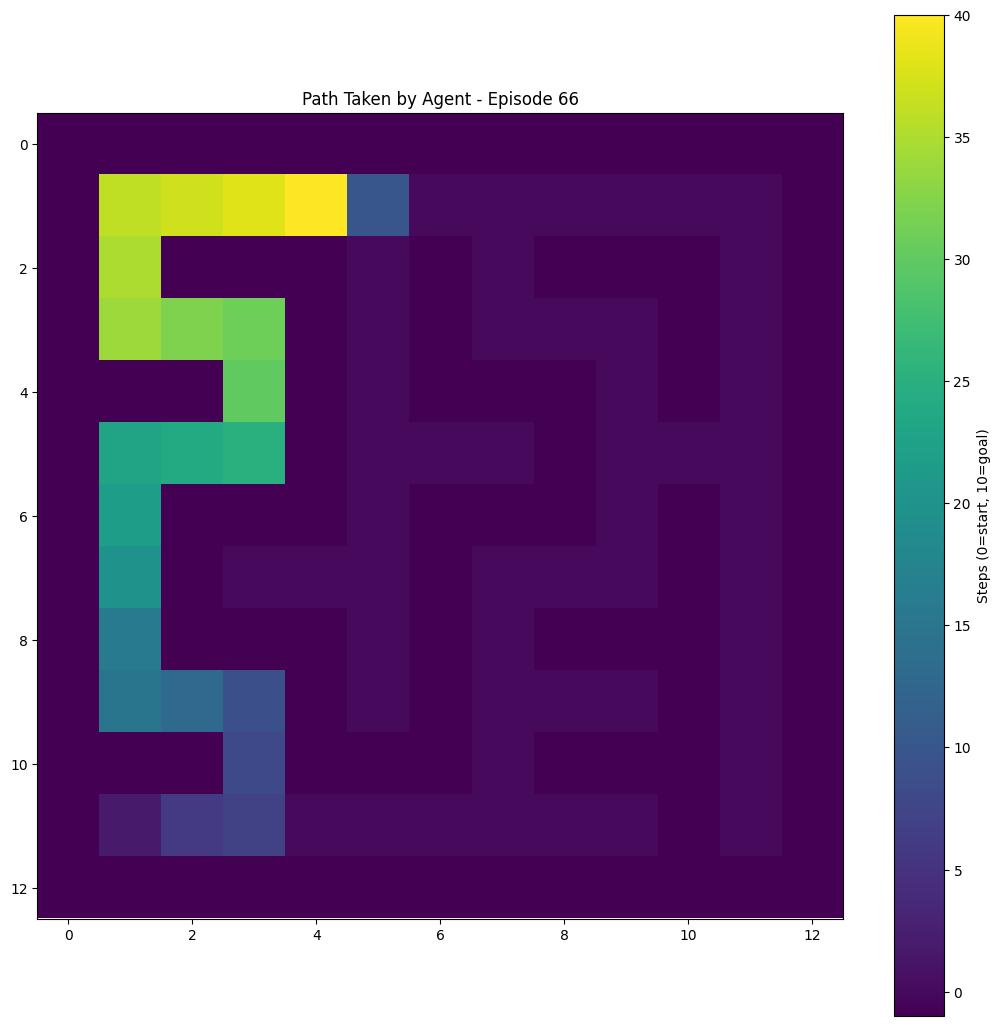

Episode 67 completed with 37 steps, average loss 1.197884957532625 and total reward 76.5


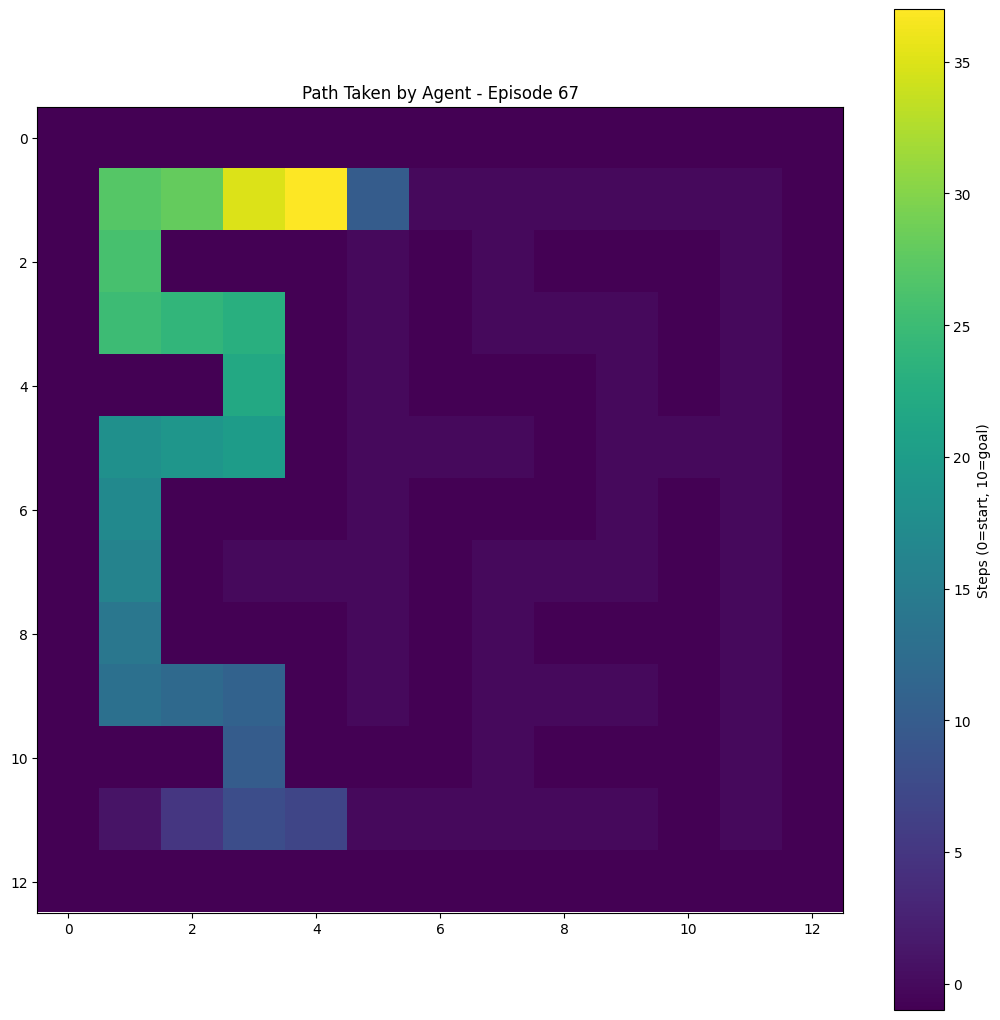

Episode 68 completed with 39 steps, average loss 0.9245243049584903 and total reward 74.5


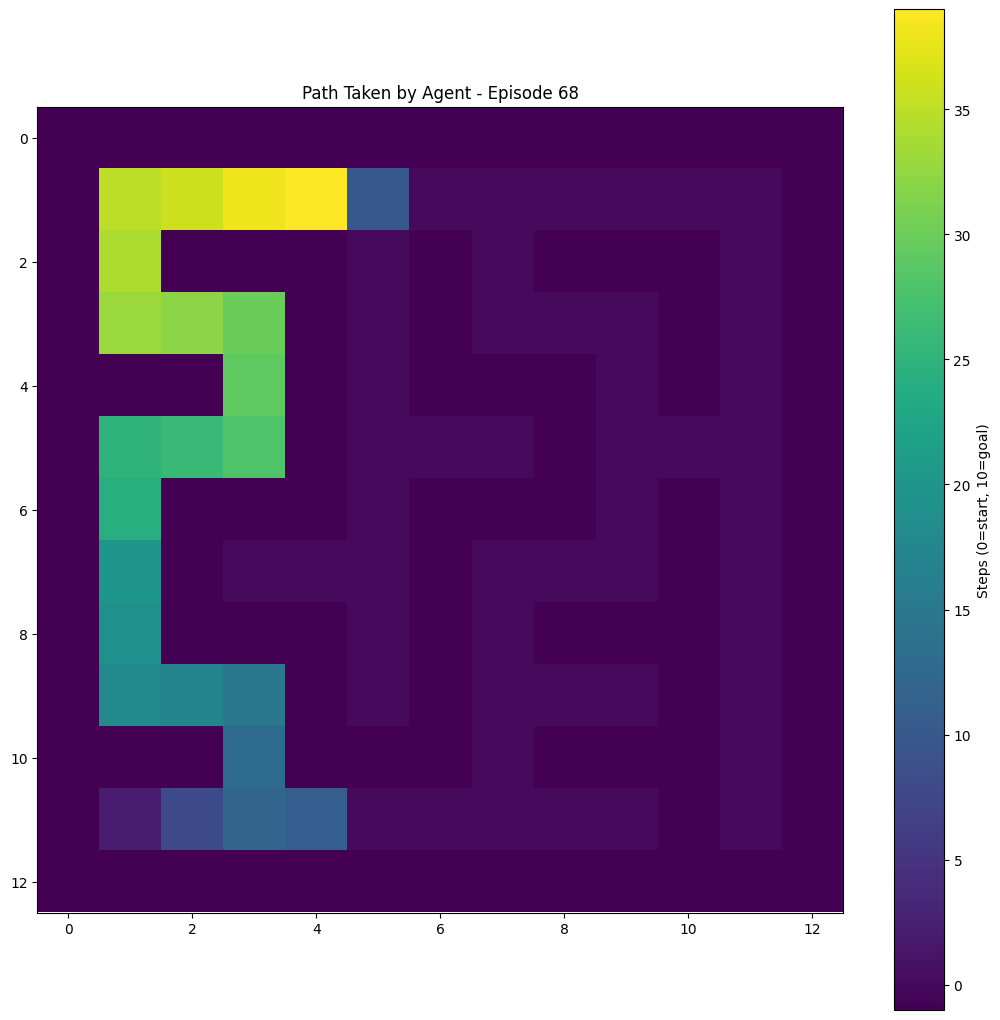

Episode 69 completed with 39 steps, average loss 0.8257070214320452 and total reward 75.5


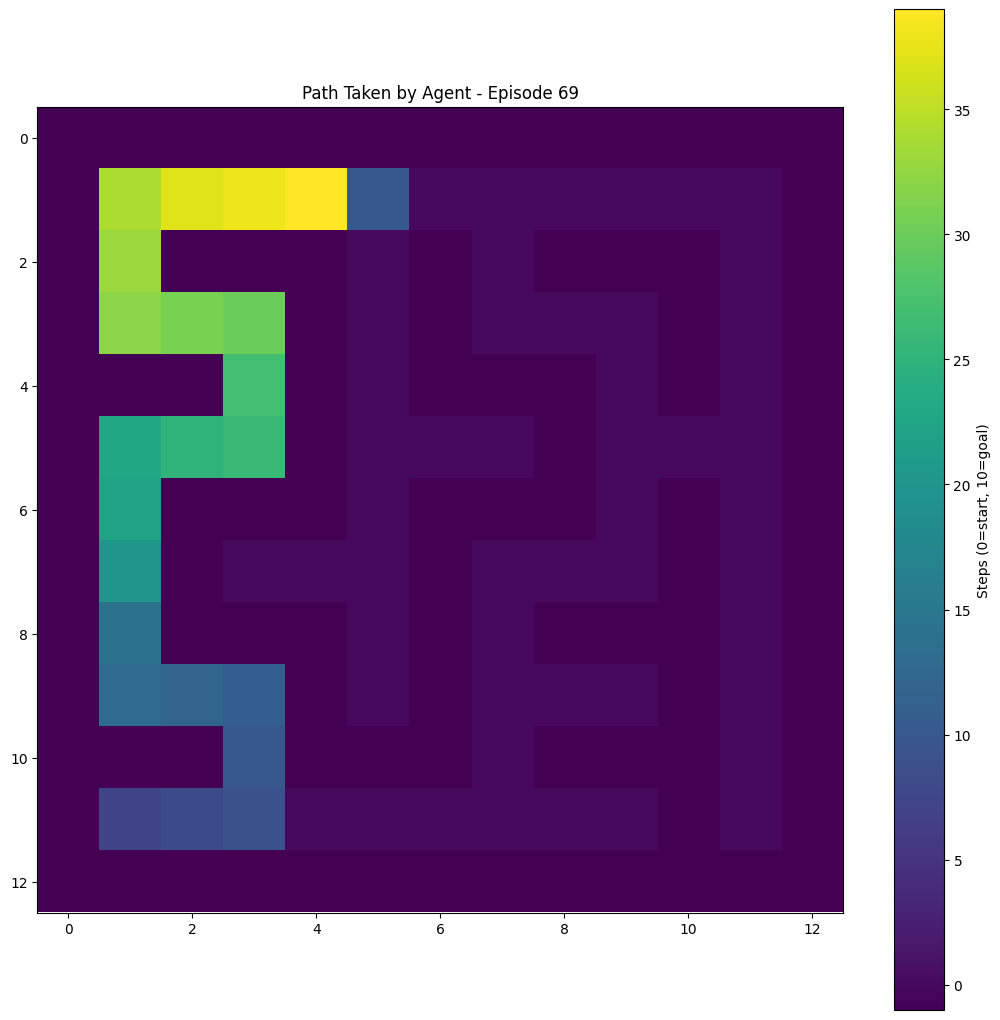

Episode 70 completed with 30 steps, average loss 0.7468754331270854 and total reward 82.5


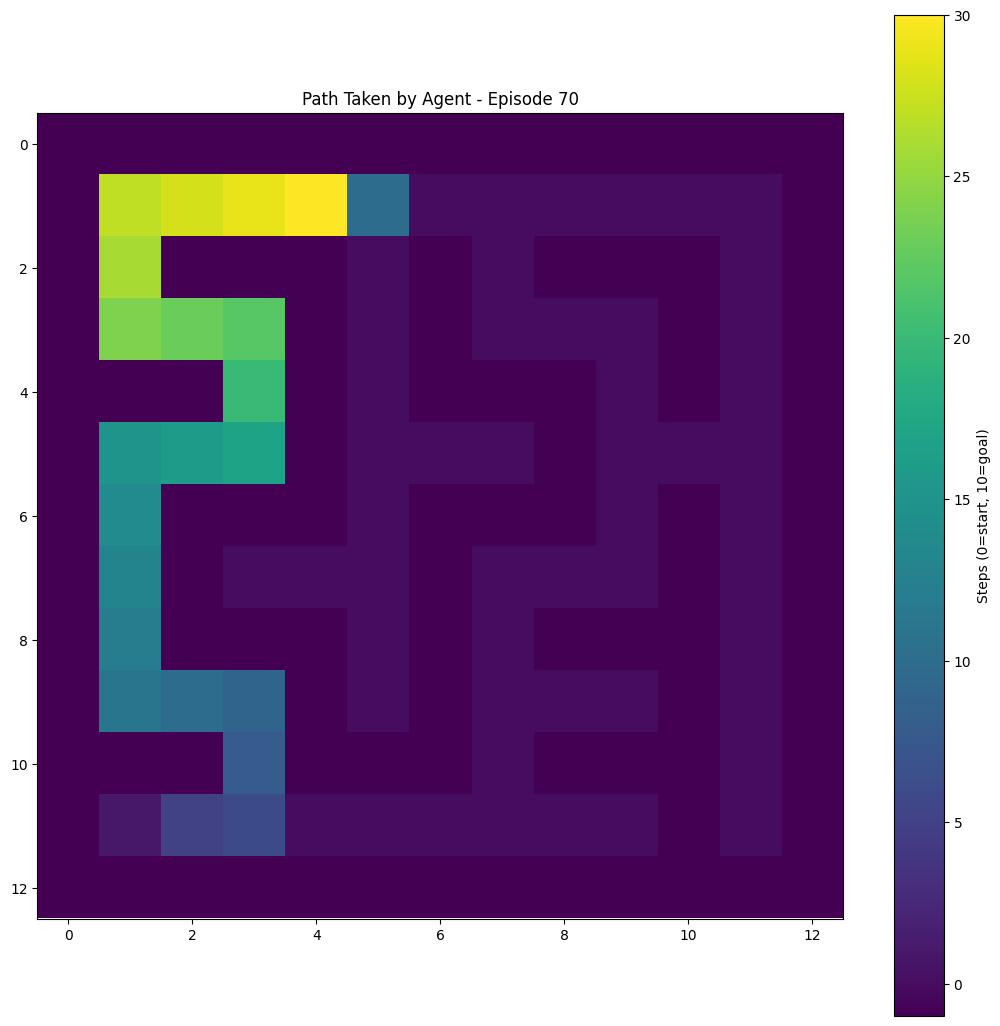

Episode 71 completed with 33 steps, average loss 0.9581769686756711 and total reward 79.5


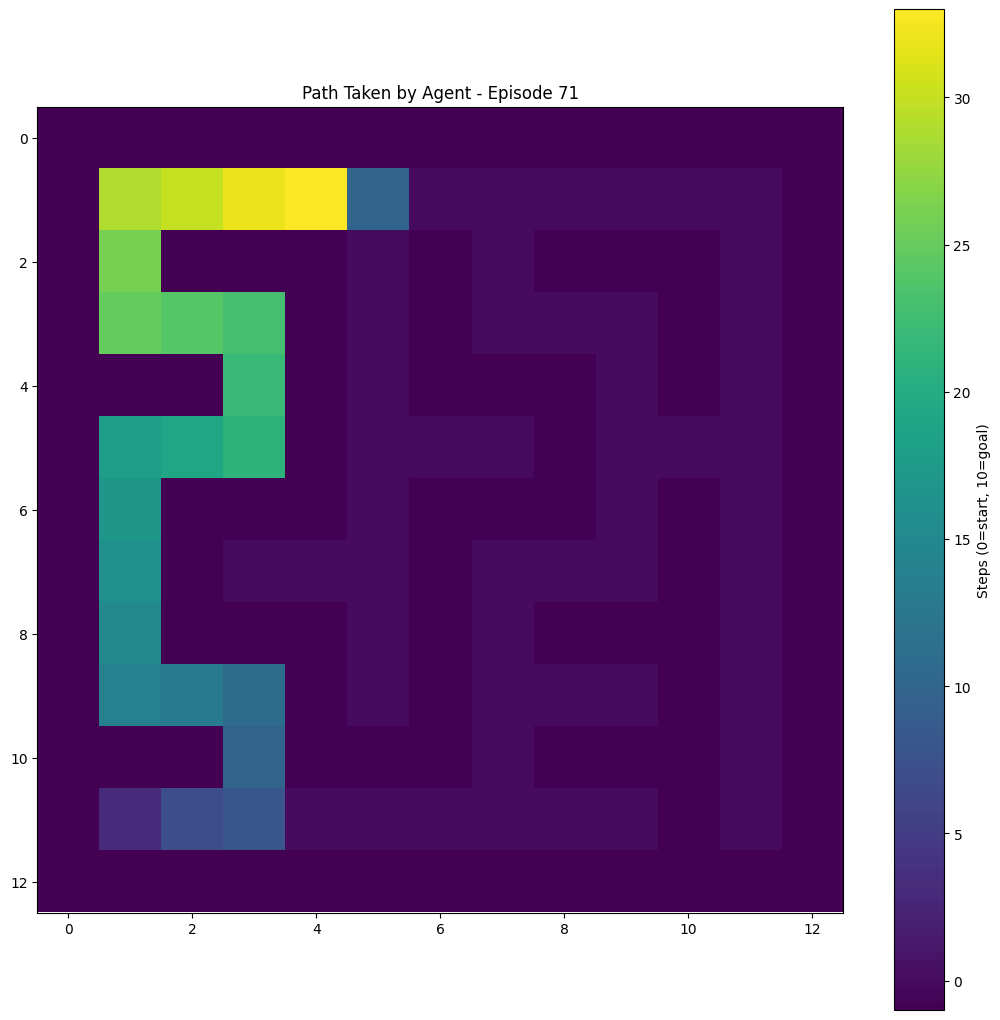

Episode 72 completed with 37 steps, average loss 0.7975079618595742 and total reward 74.5


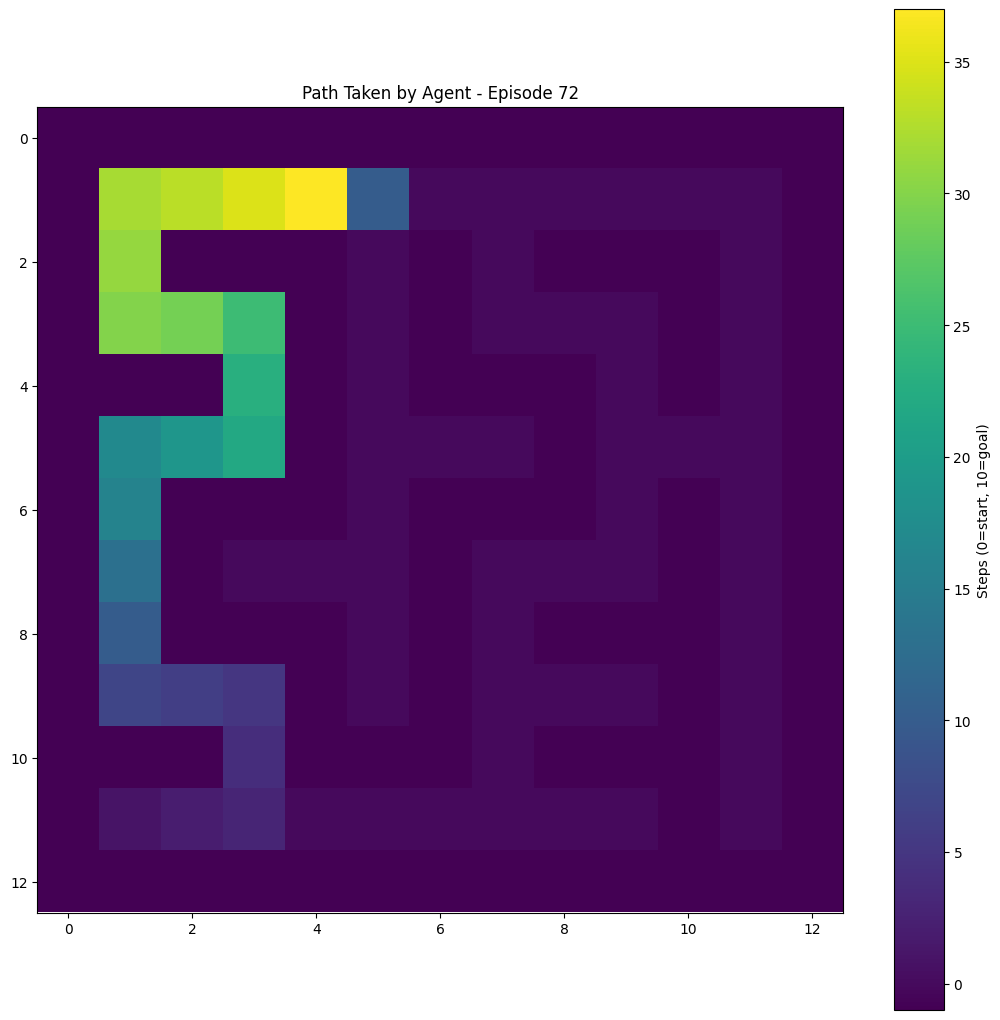

Episode 73 completed with 40 steps, average loss 1.146614883840084 and total reward 75.5


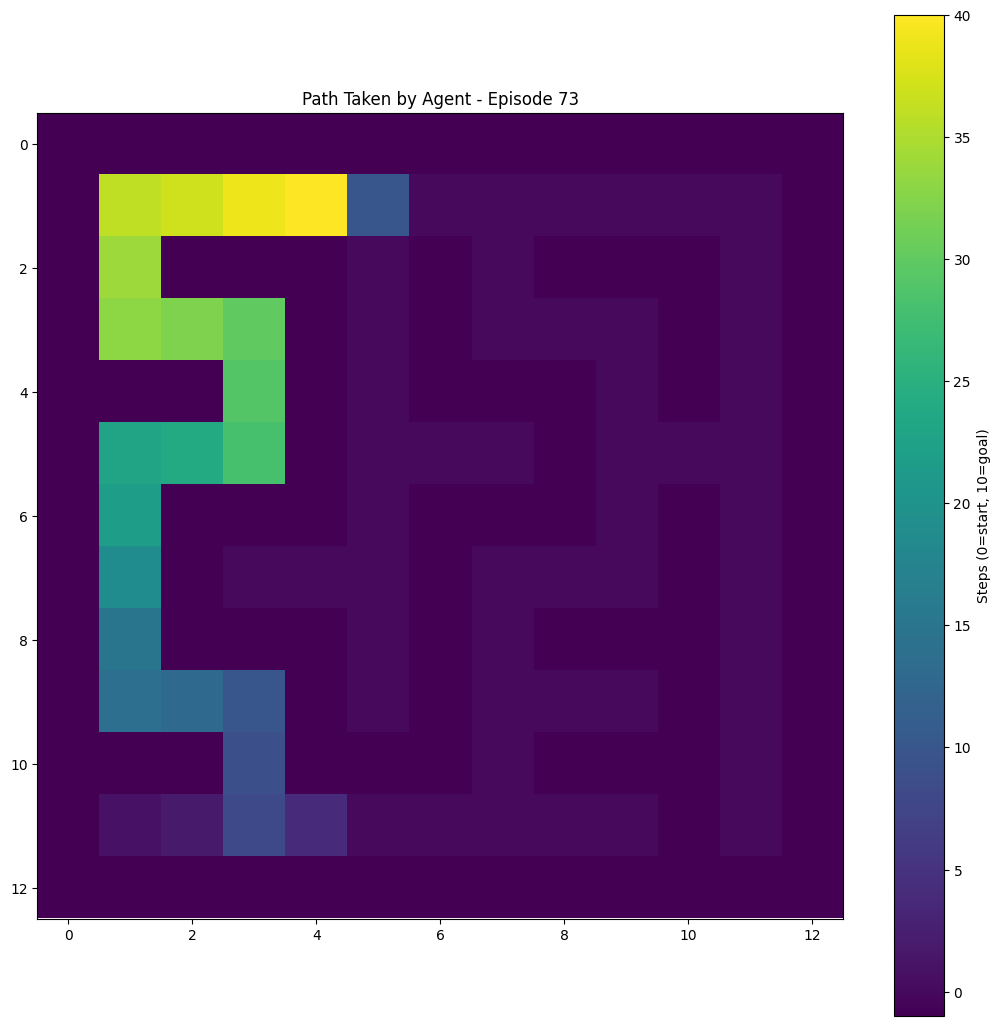

Episode 74 completed with 32 steps, average loss 0.9302198784425855 and total reward 79.5


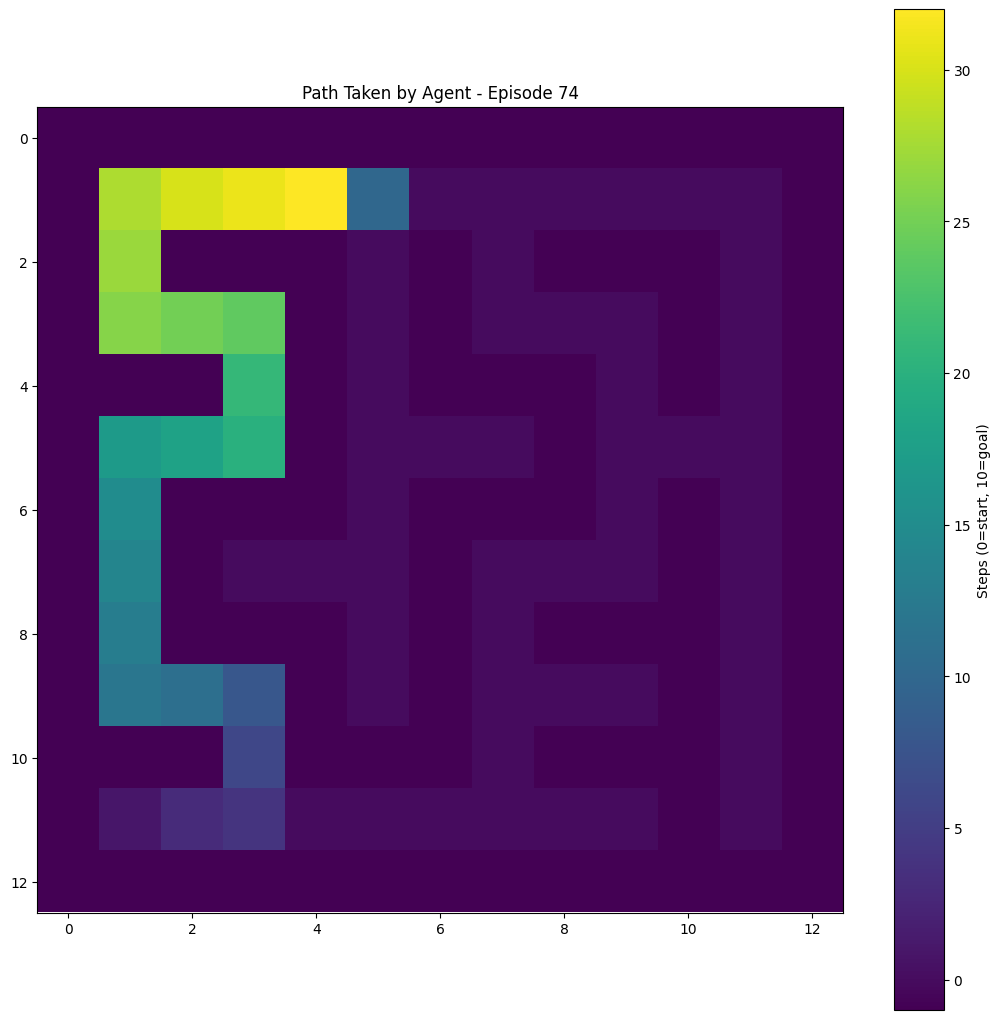

Episode 75 completed with 37 steps, average loss 0.8727940329023309 and total reward 76.5


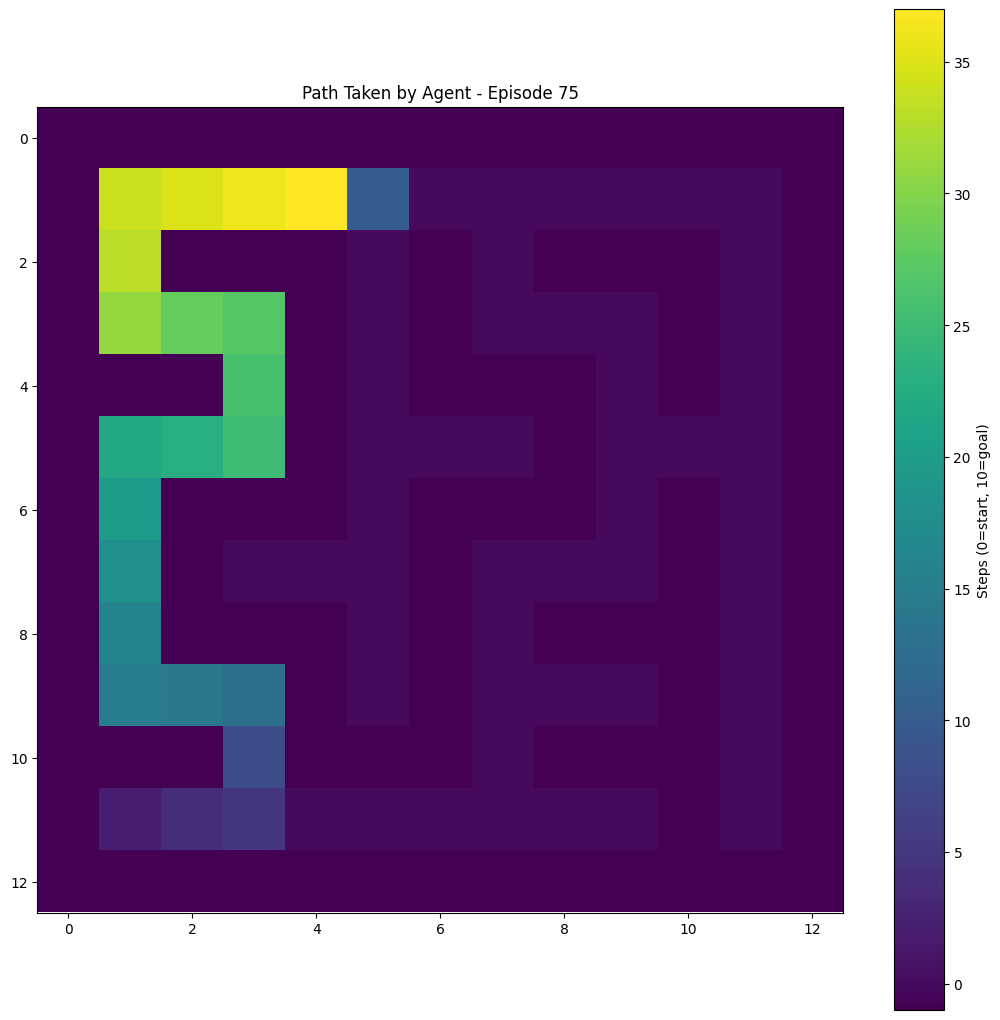

Episode 76 completed with 27 steps, average loss 0.7838148276011149 and total reward 84.5


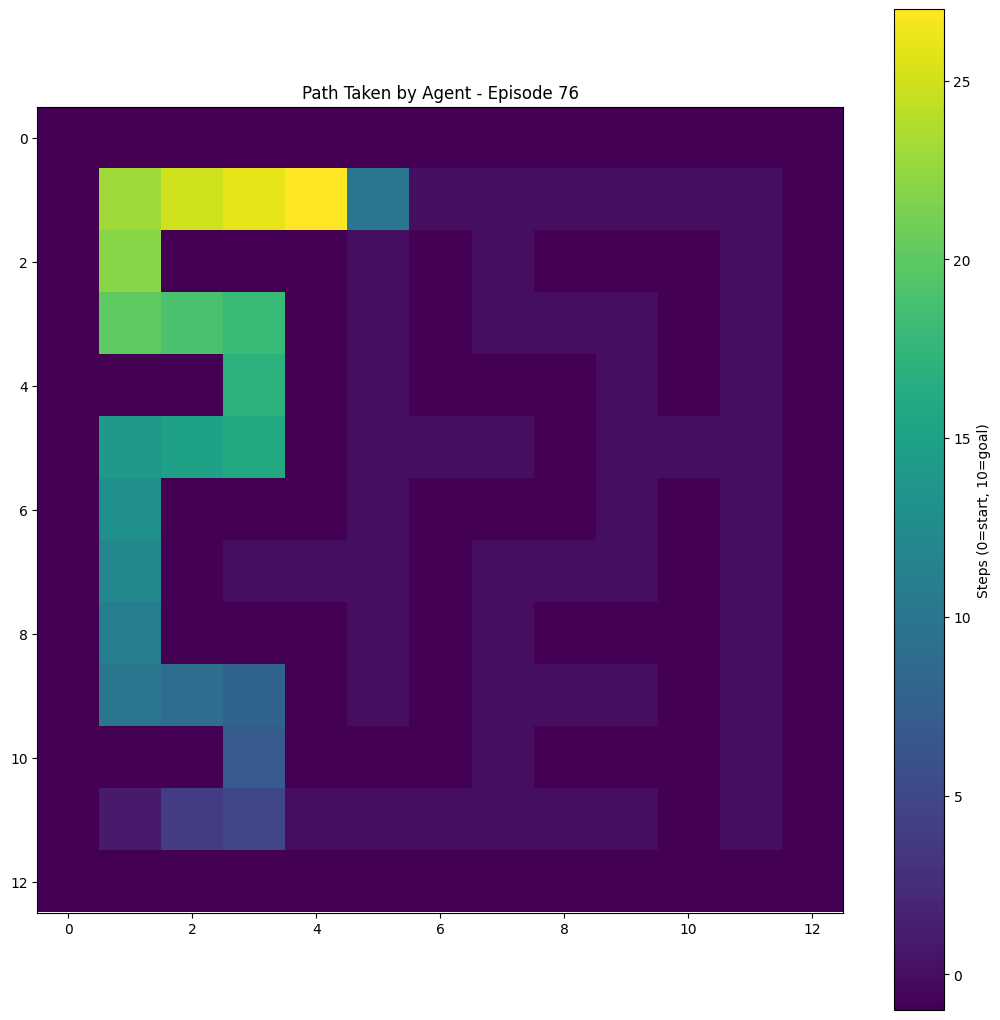

Episode 77 completed with 31 steps, average loss 0.8104986567651072 and total reward 81.5


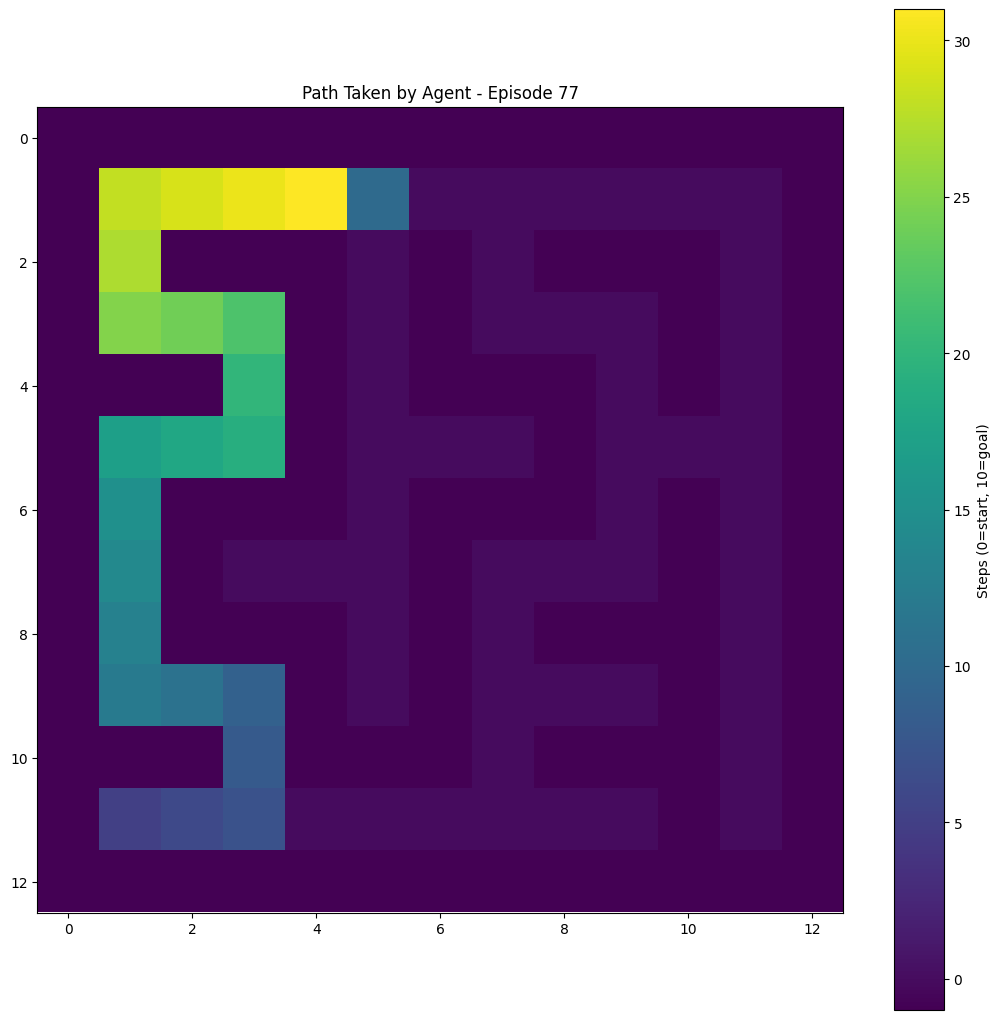

Episode 78 completed with 36 steps, average loss 0.9523900366491742 and total reward 78.5


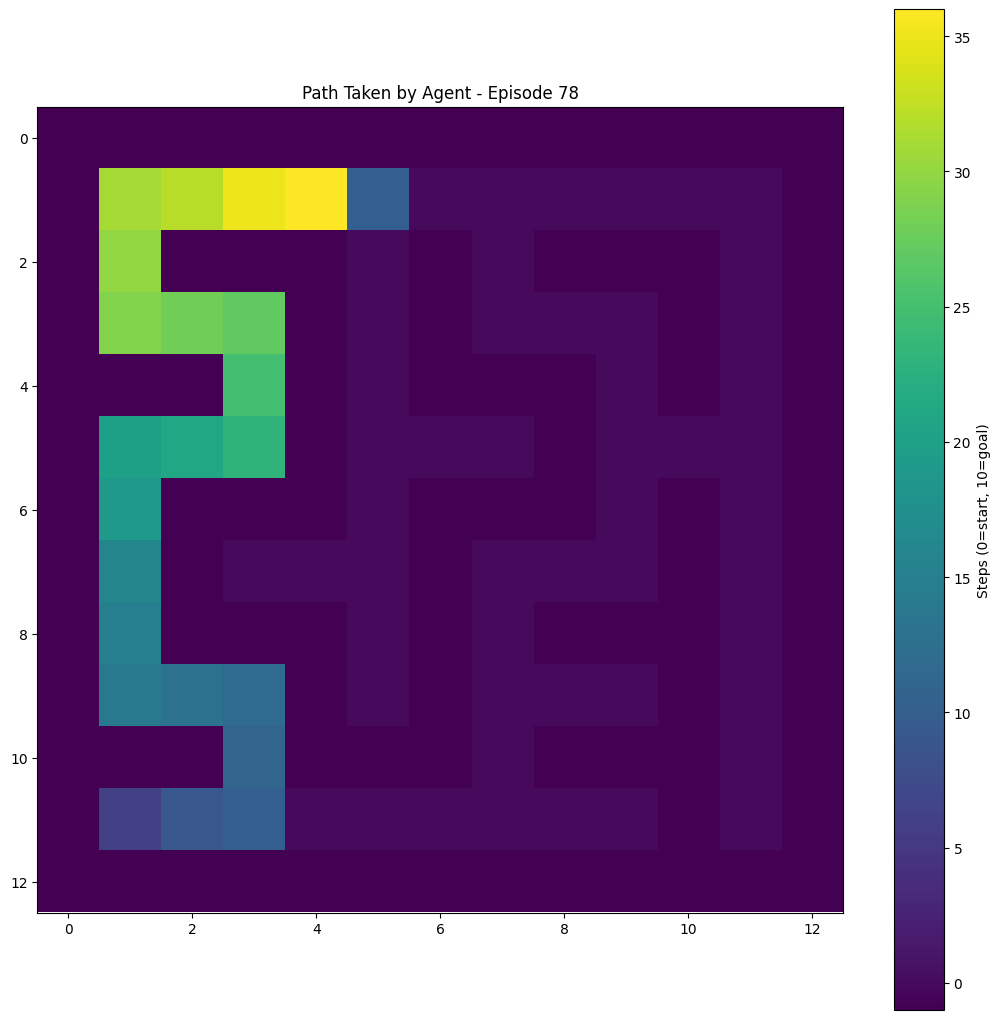

Episode 79 completed with 28 steps, average loss 0.9081983108605657 and total reward 83.5


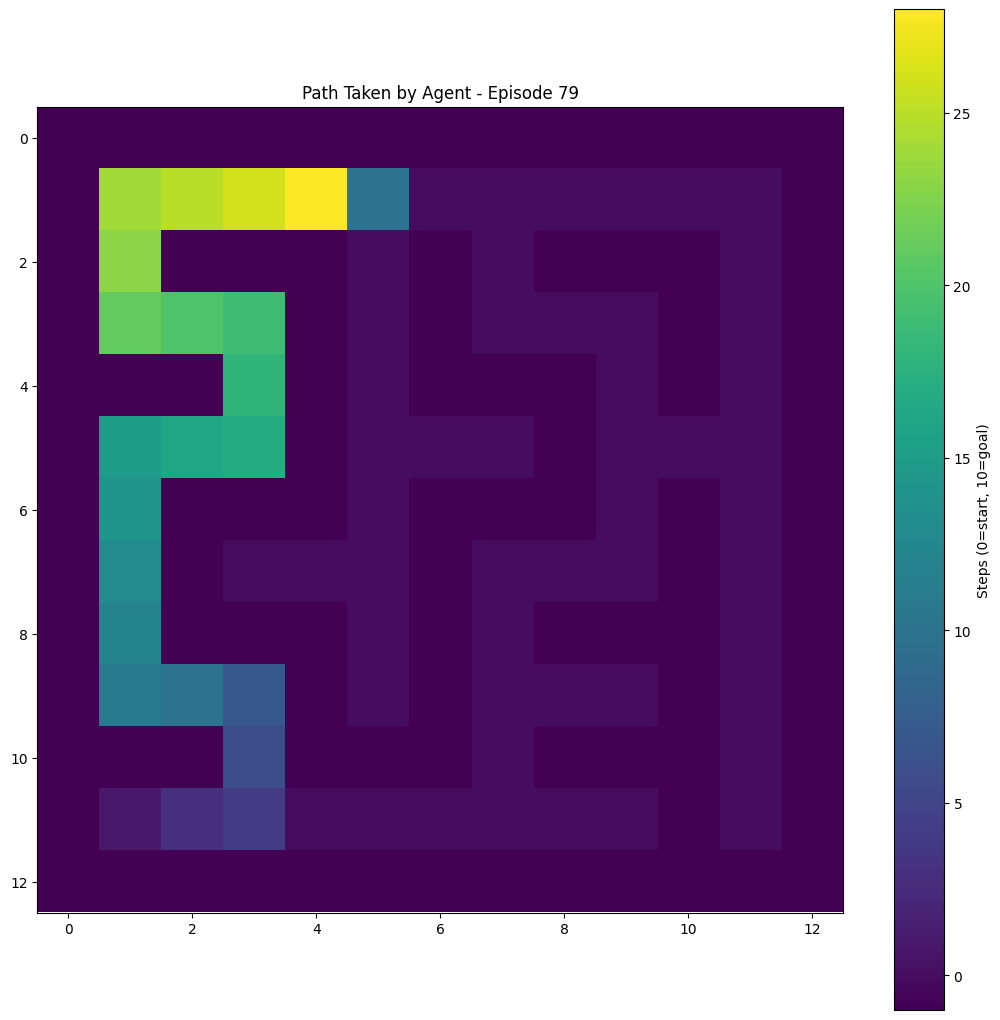

Episode 80 completed with 33 steps, average loss 1.0360217708529849 and total reward 82.5


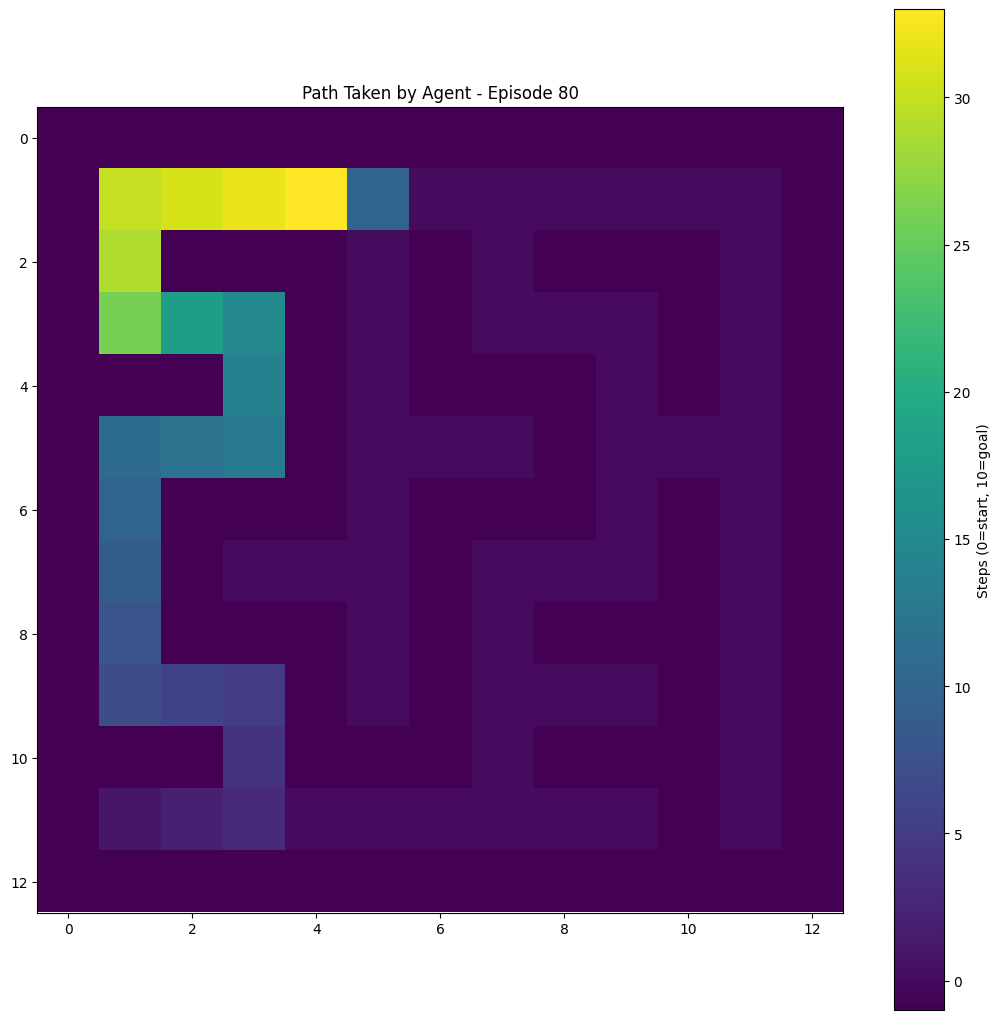

Episode 81 completed with 40 steps, average loss 1.1740698650479318 and total reward 74.5


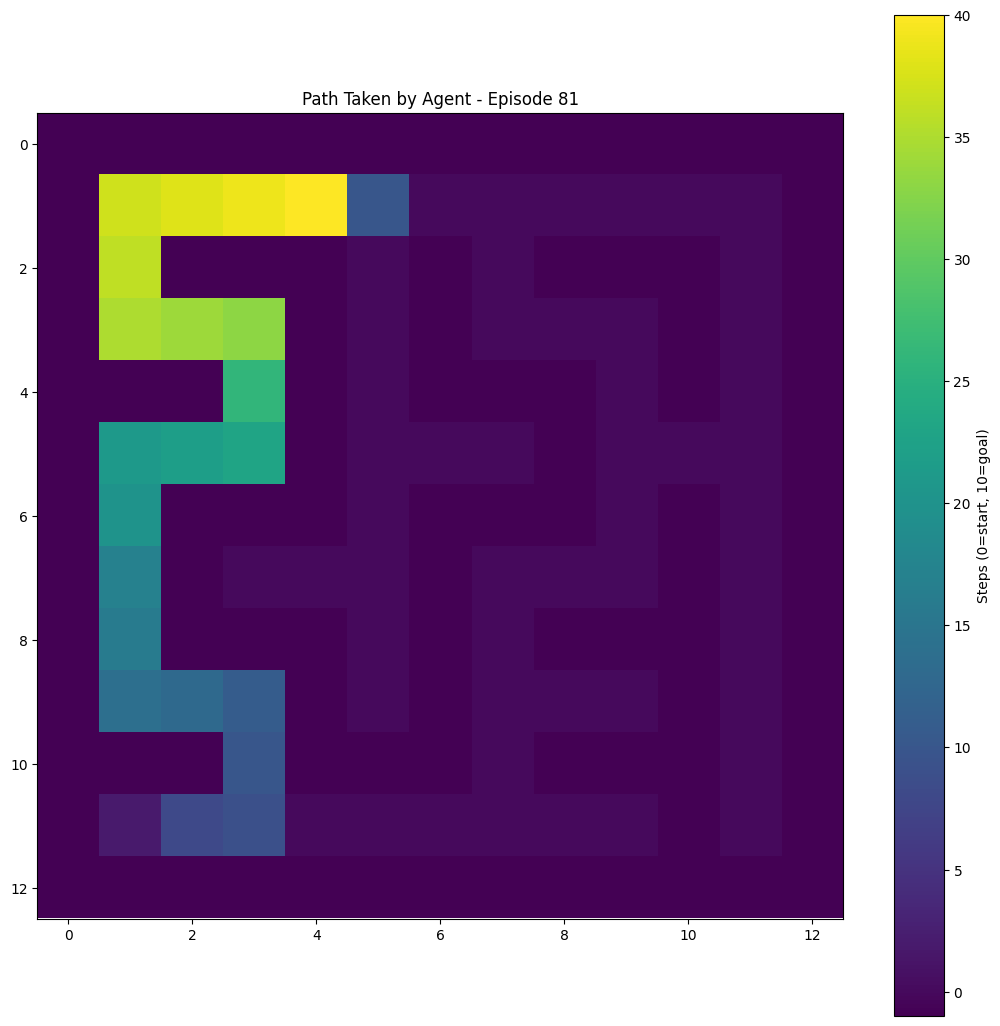

Episode 82 completed with 34 steps, average loss 0.9601428535054711 and total reward 78.5


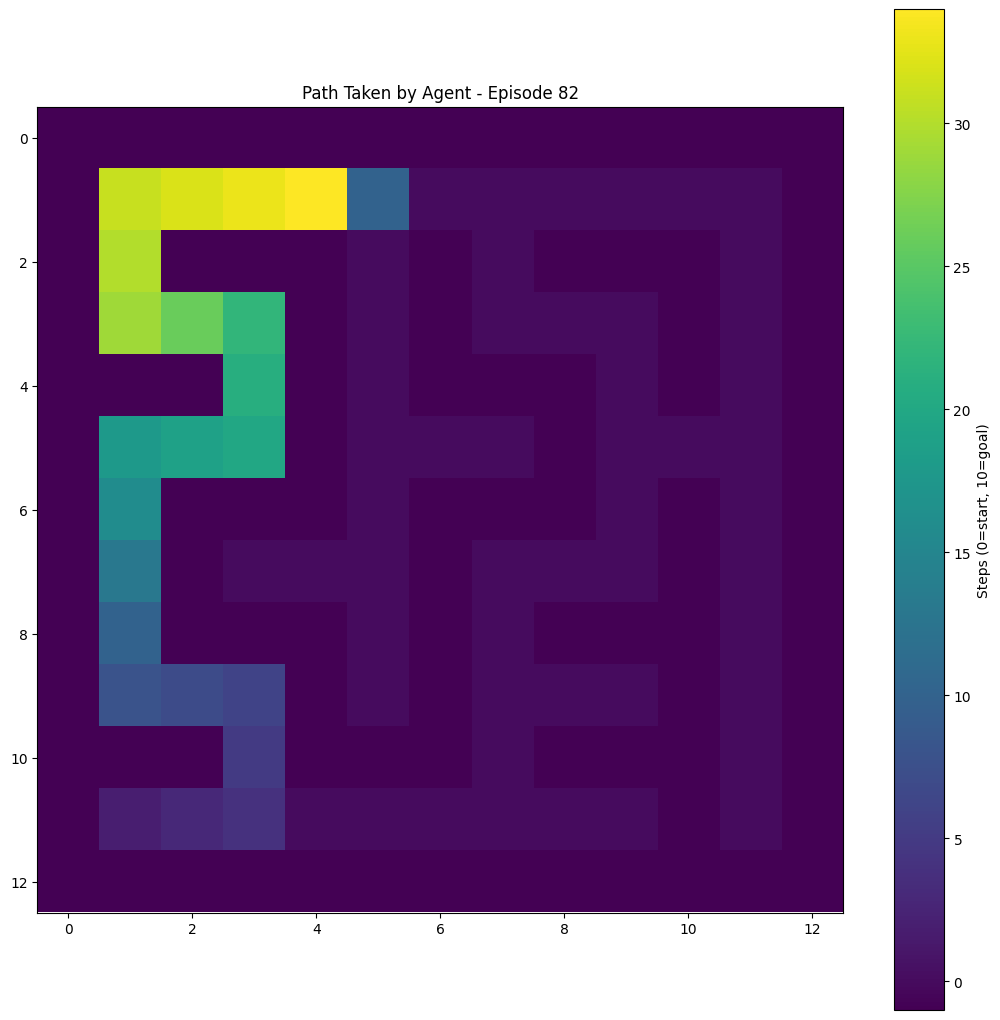

Episode 83 completed with 42 steps, average loss 0.8794144335247222 and total reward 71.5


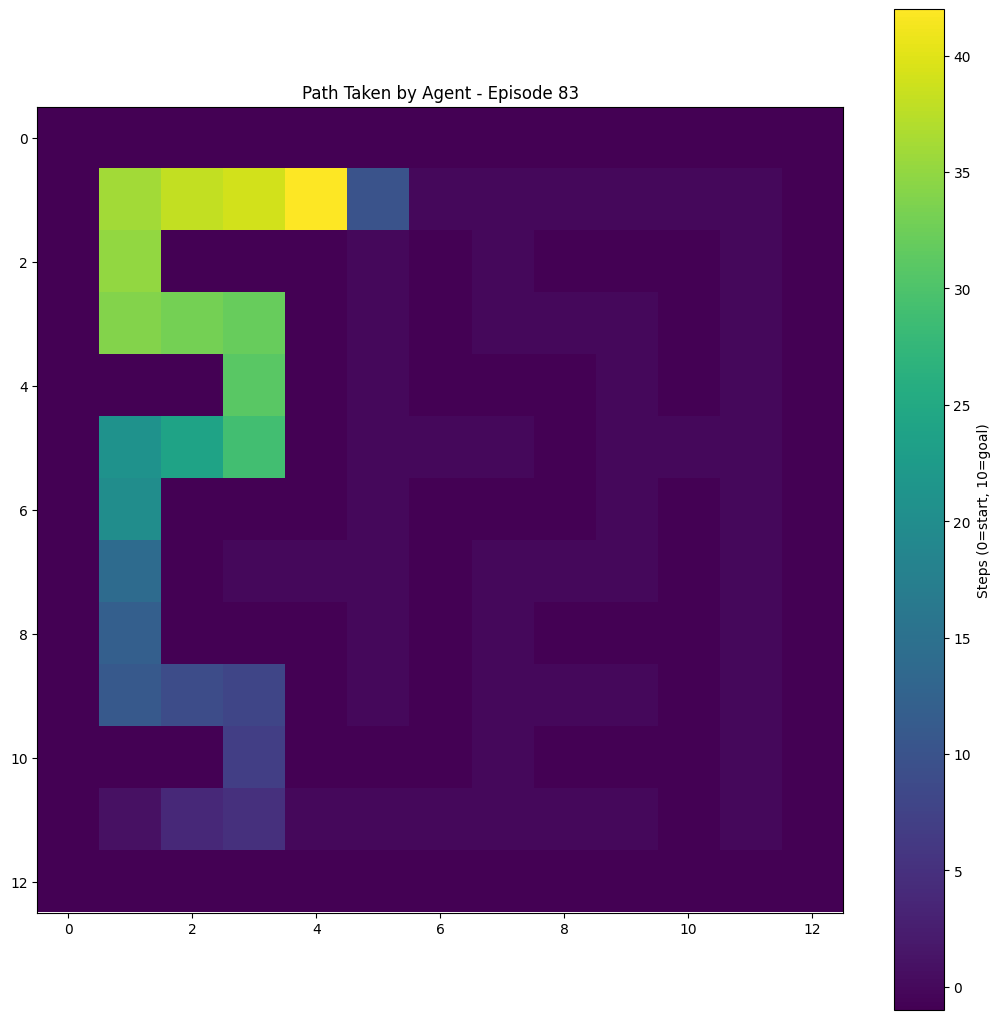

Episode 84 completed with 33 steps, average loss 0.9180878572391741 and total reward 80.5


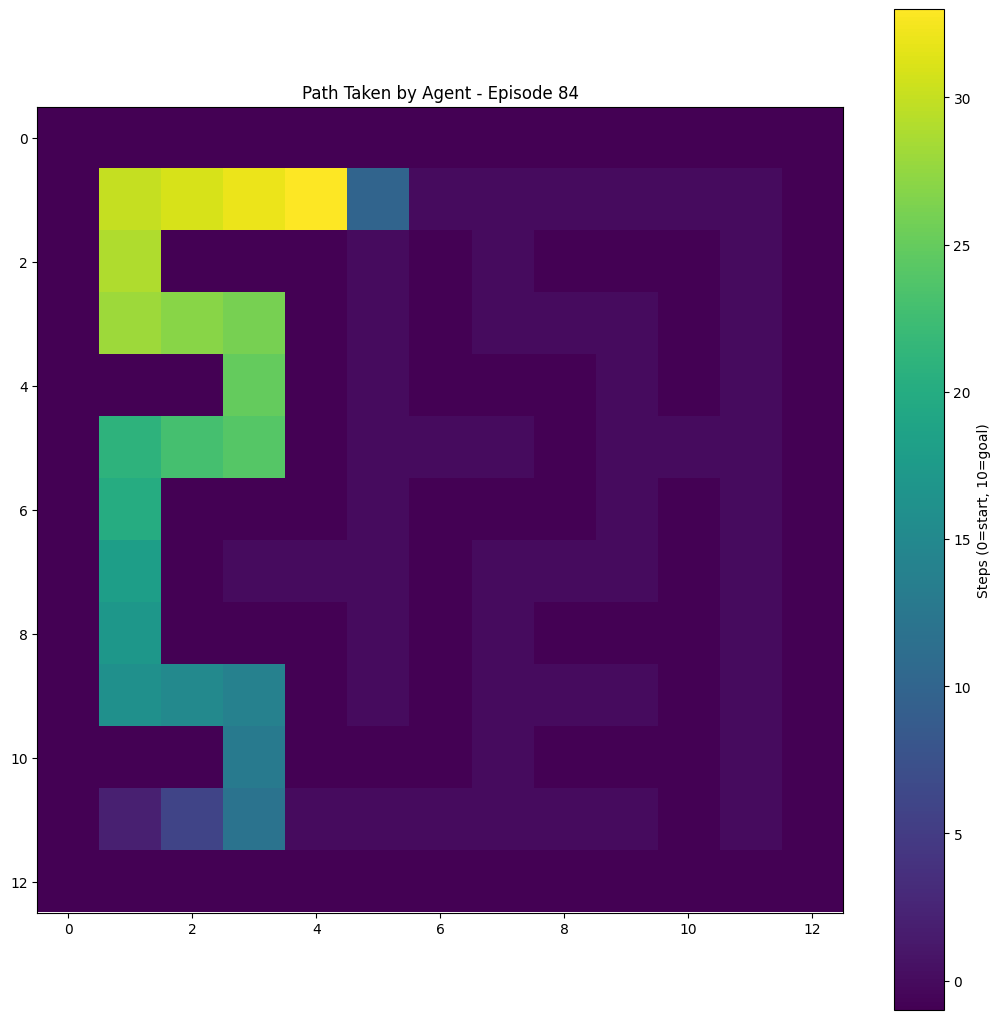

Episode 85 completed with 29 steps, average loss 0.7644019075508776 and total reward 82.5


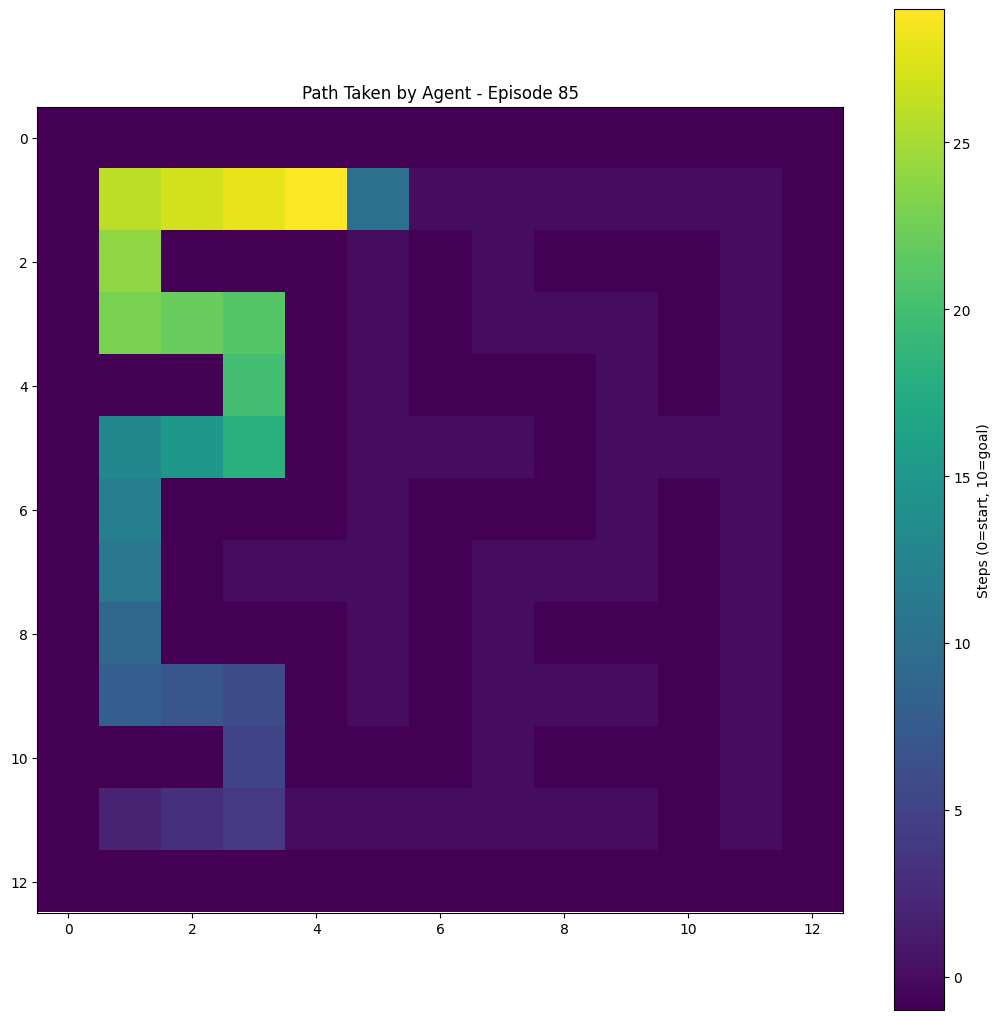

Episode 86 completed with 36 steps, average loss 0.6703612754742304 and total reward 77.5


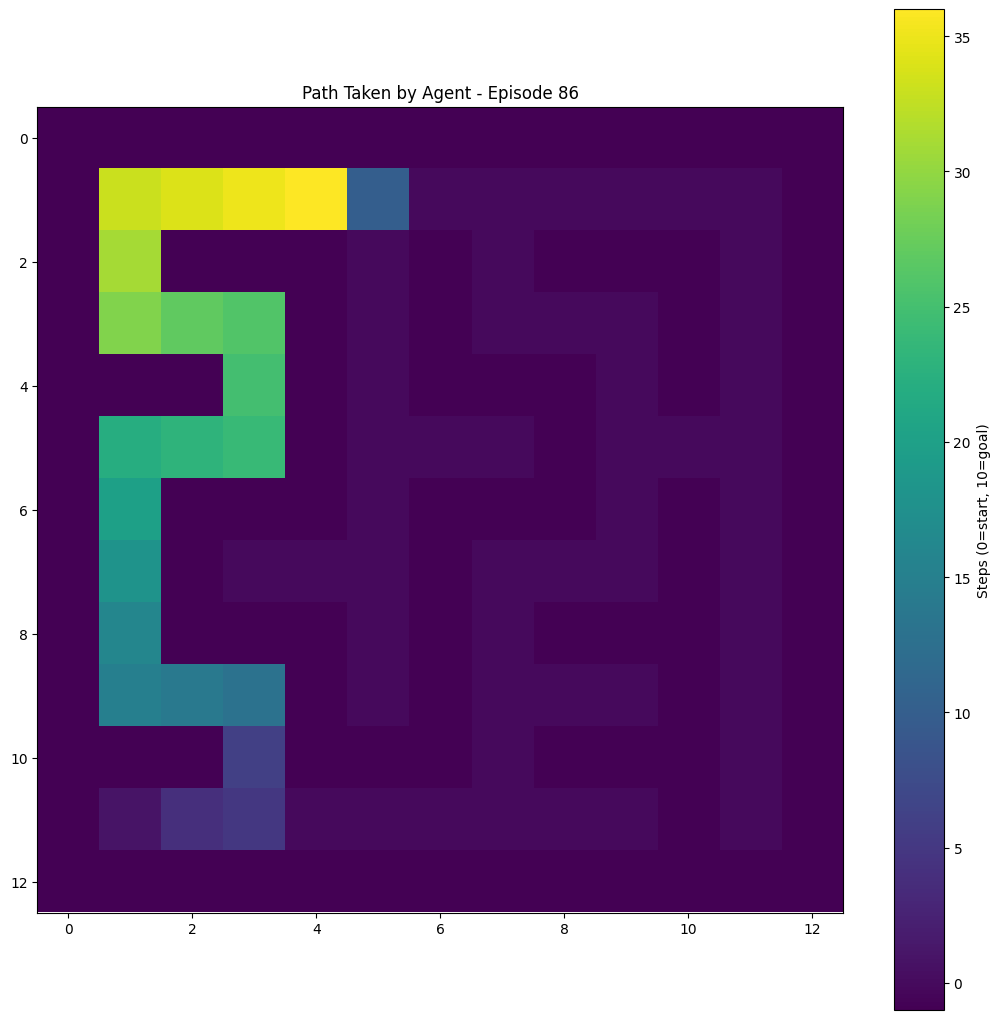

Episode 87 completed with 35 steps, average loss 0.7384587790284838 and total reward 78.5


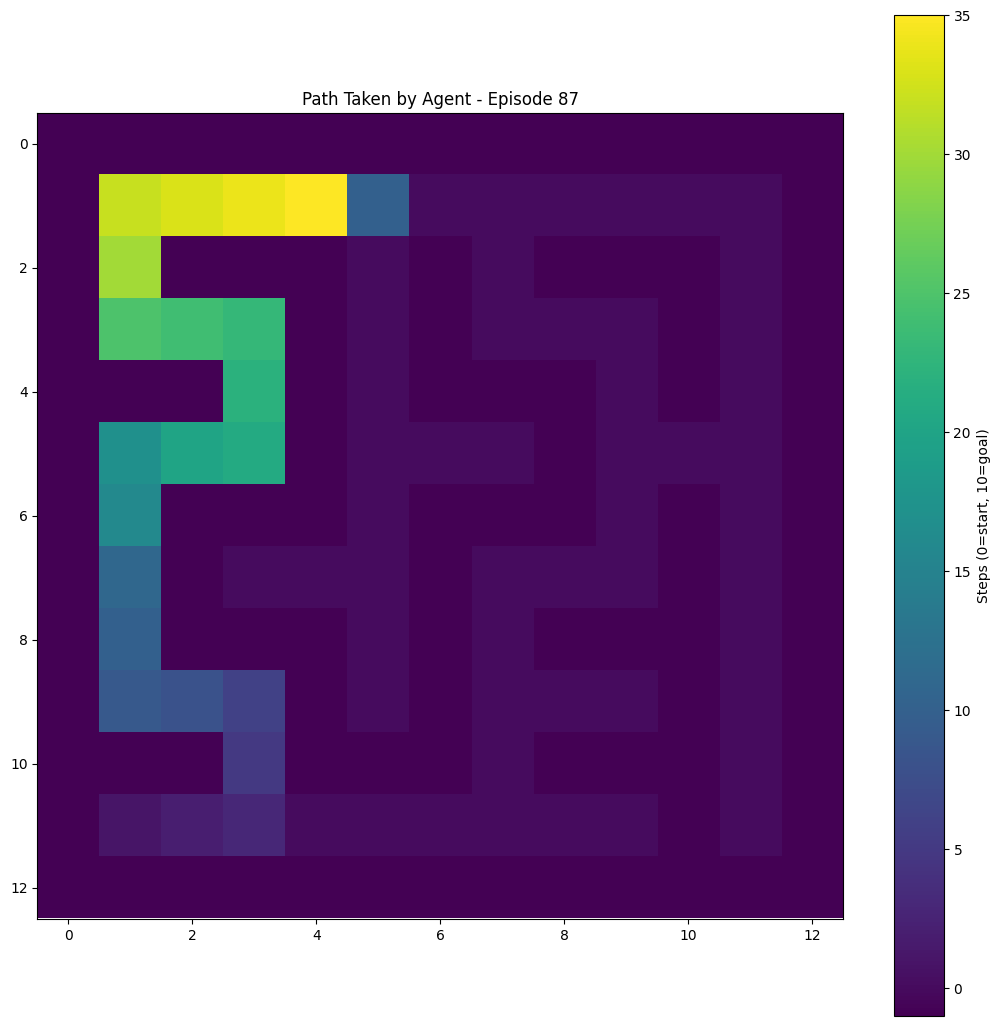

Episode 88 completed with 40 steps, average loss 0.8355833411216735 and total reward 75.5


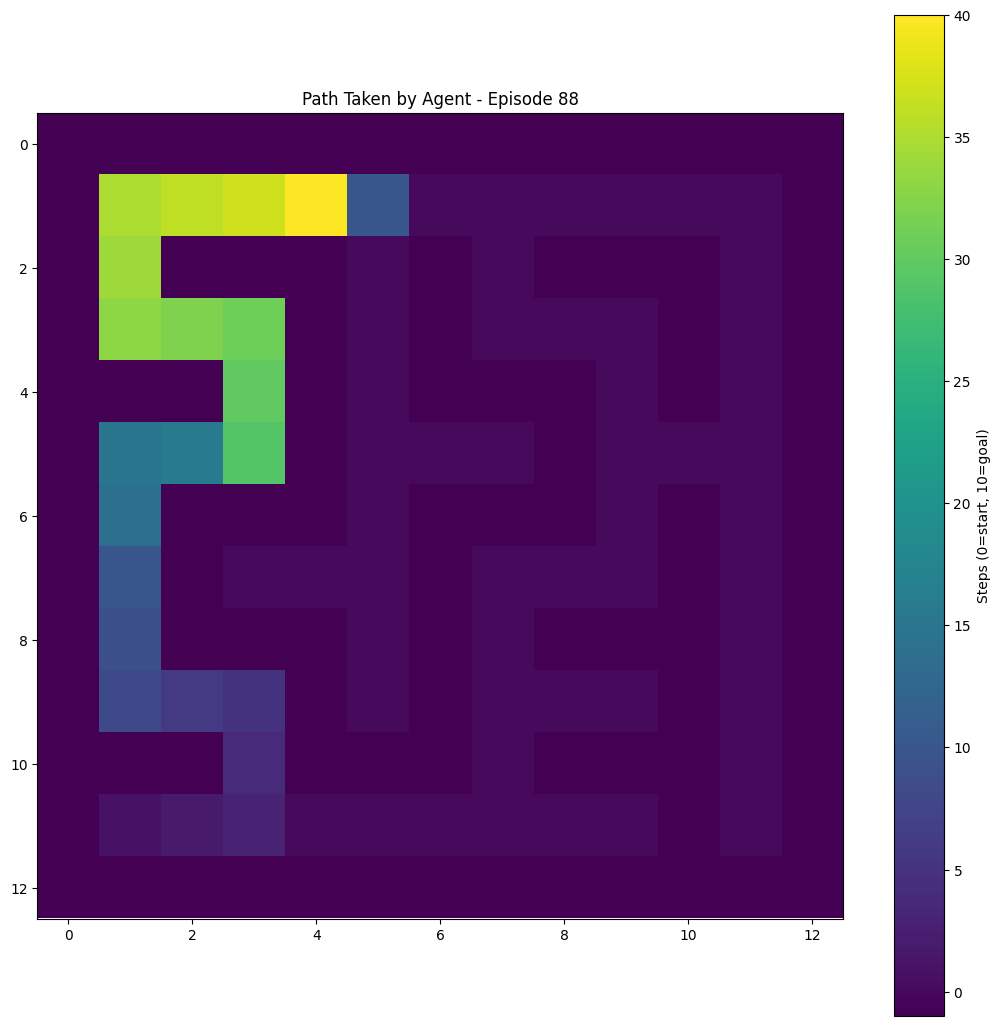

Episode 89 completed with 47 steps, average loss 0.8117701747315995 and total reward 67.5


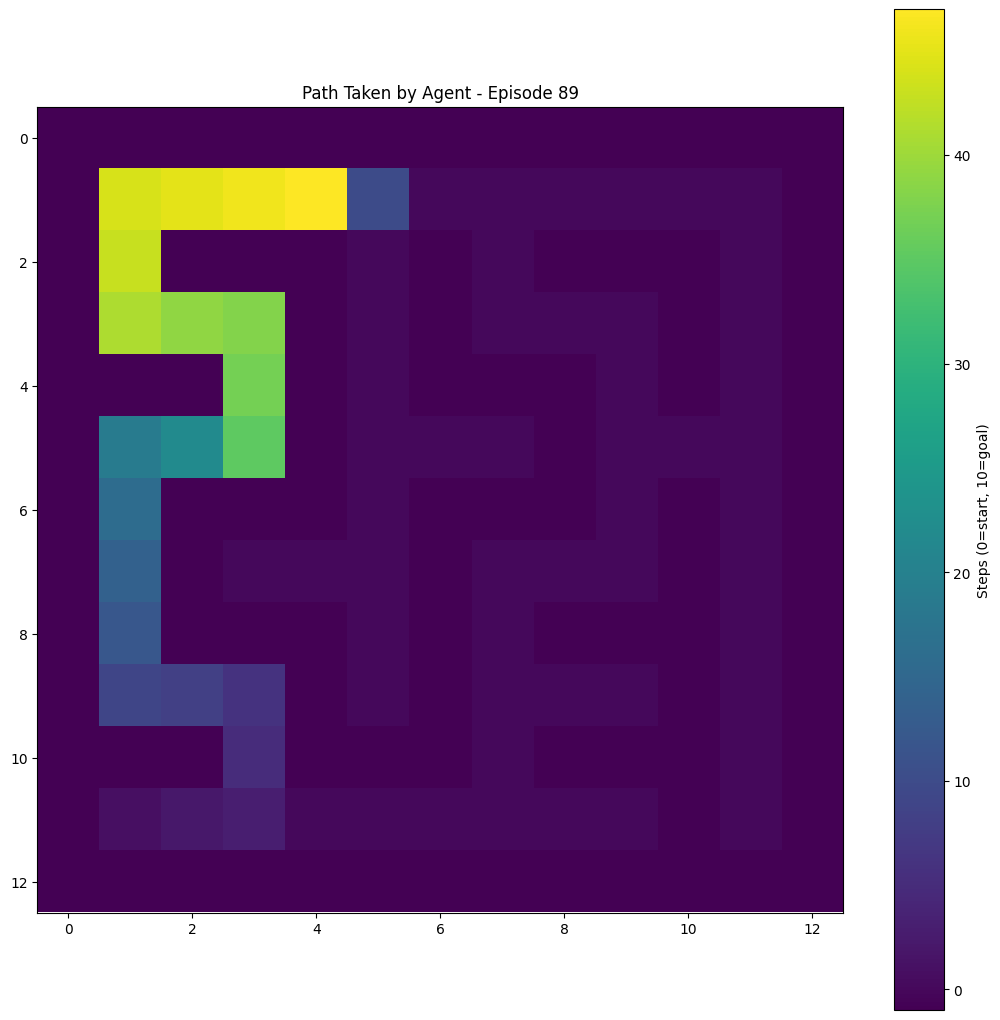

Episode 90 completed with 32 steps, average loss 0.7874670848250389 and total reward 81.5


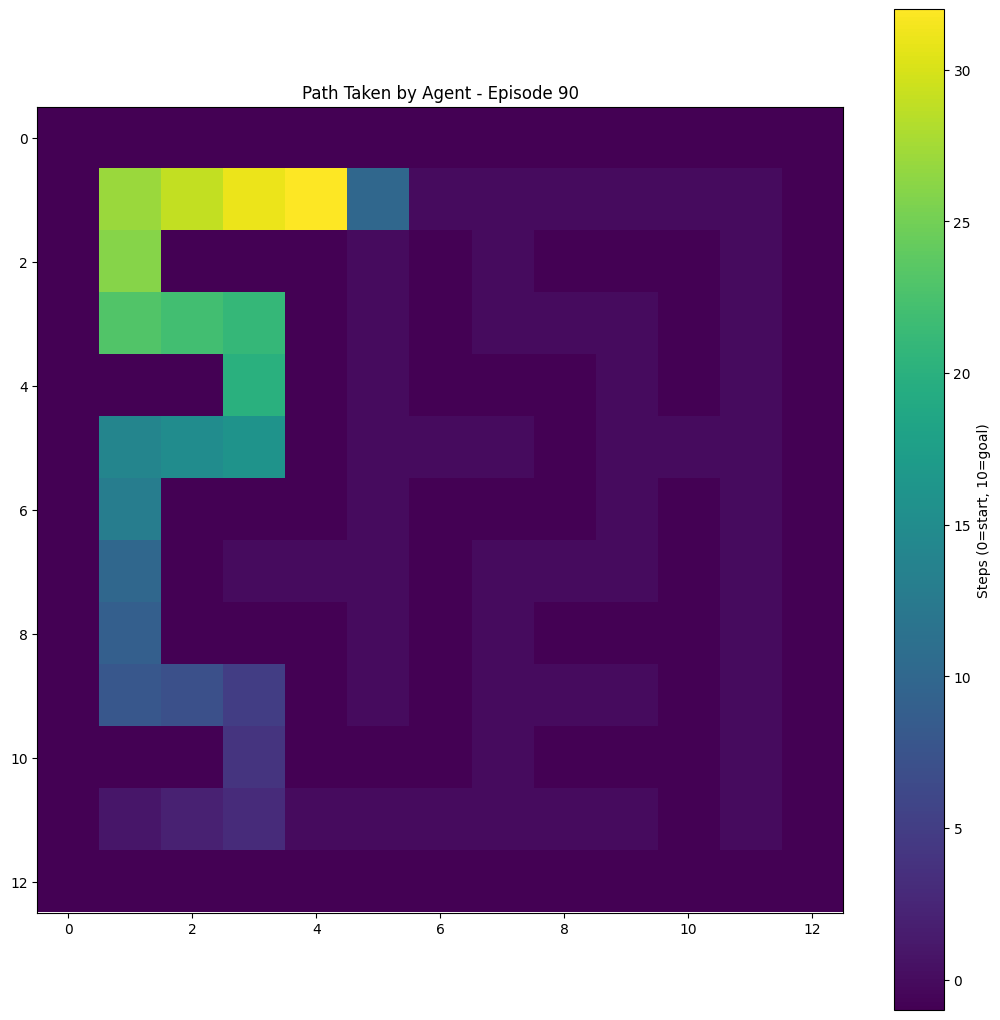

Episode 91 completed with 34 steps, average loss 0.8225813841118532 and total reward 78.5


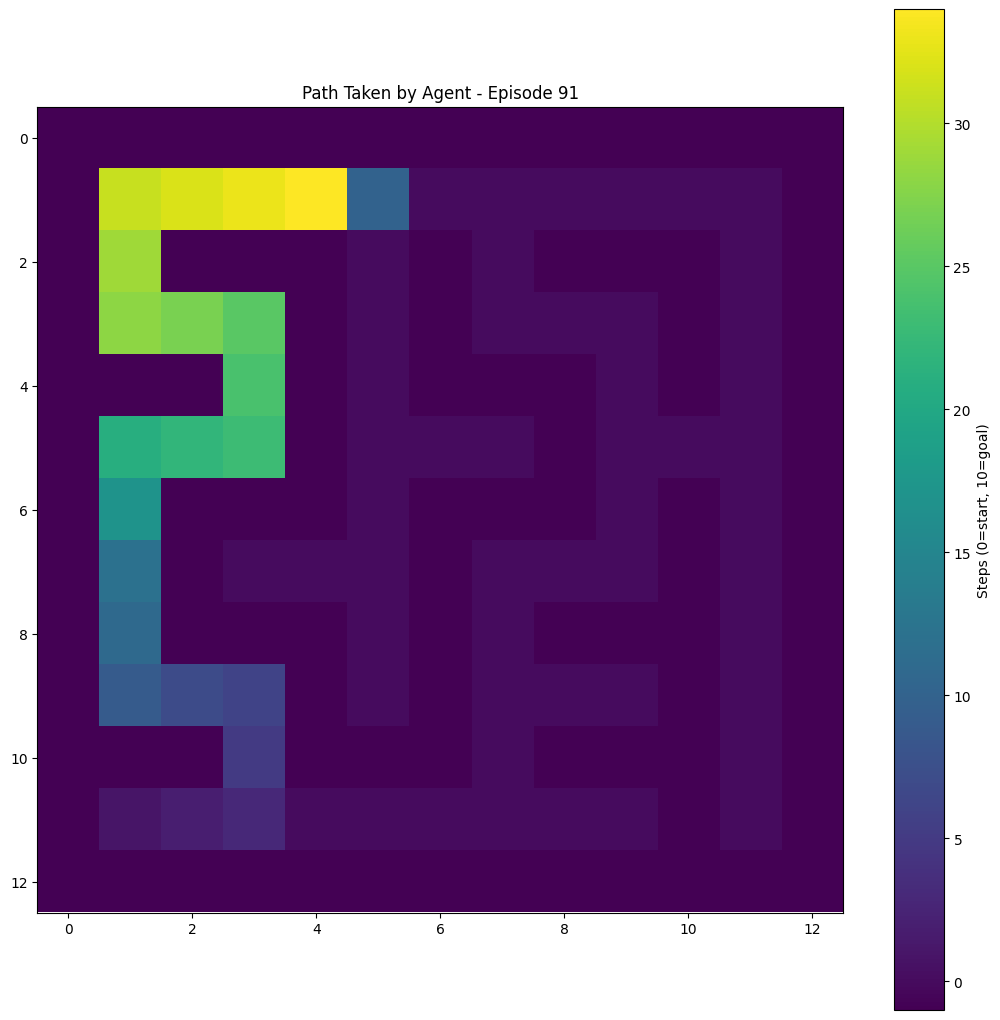

Episode 92 completed with 46 steps, average loss 0.8474963462871054 and total reward 71.5


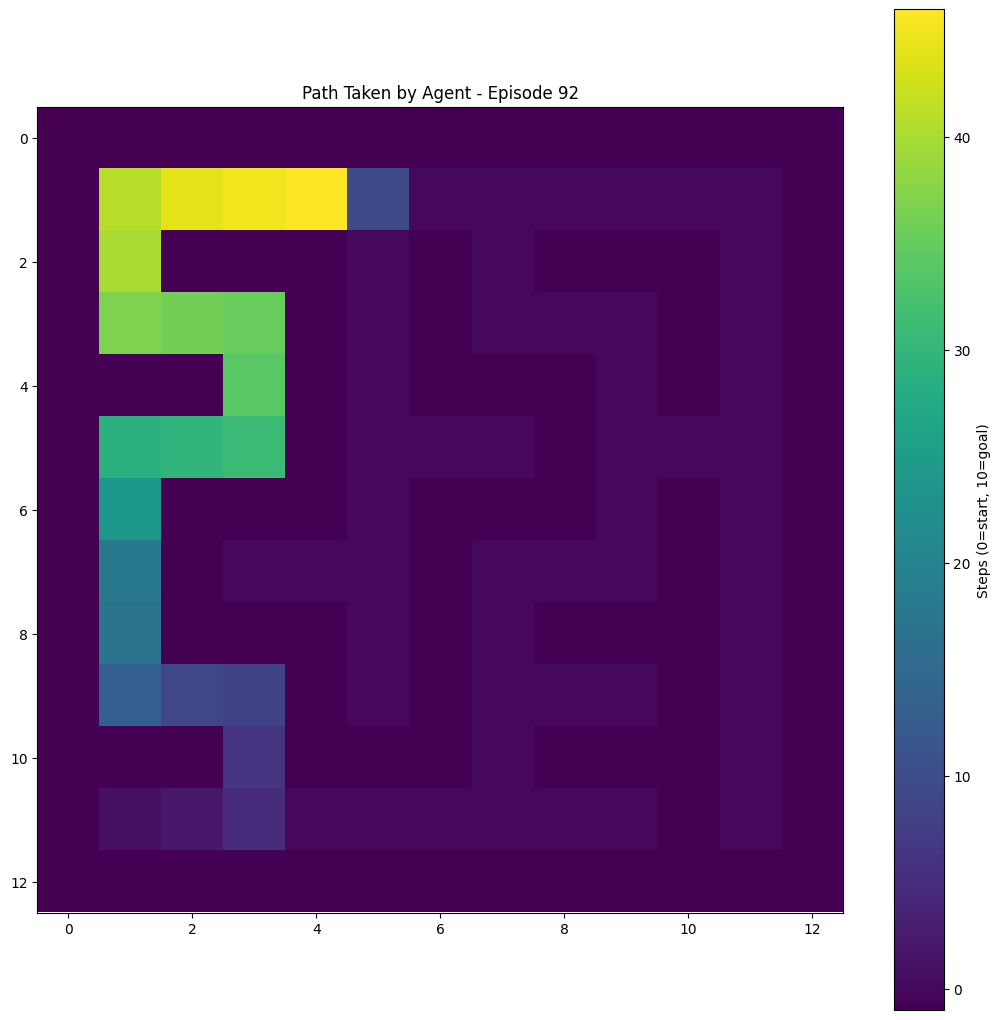

Episode 93 completed with 41 steps, average loss 0.8720844133598048 and total reward 73.5


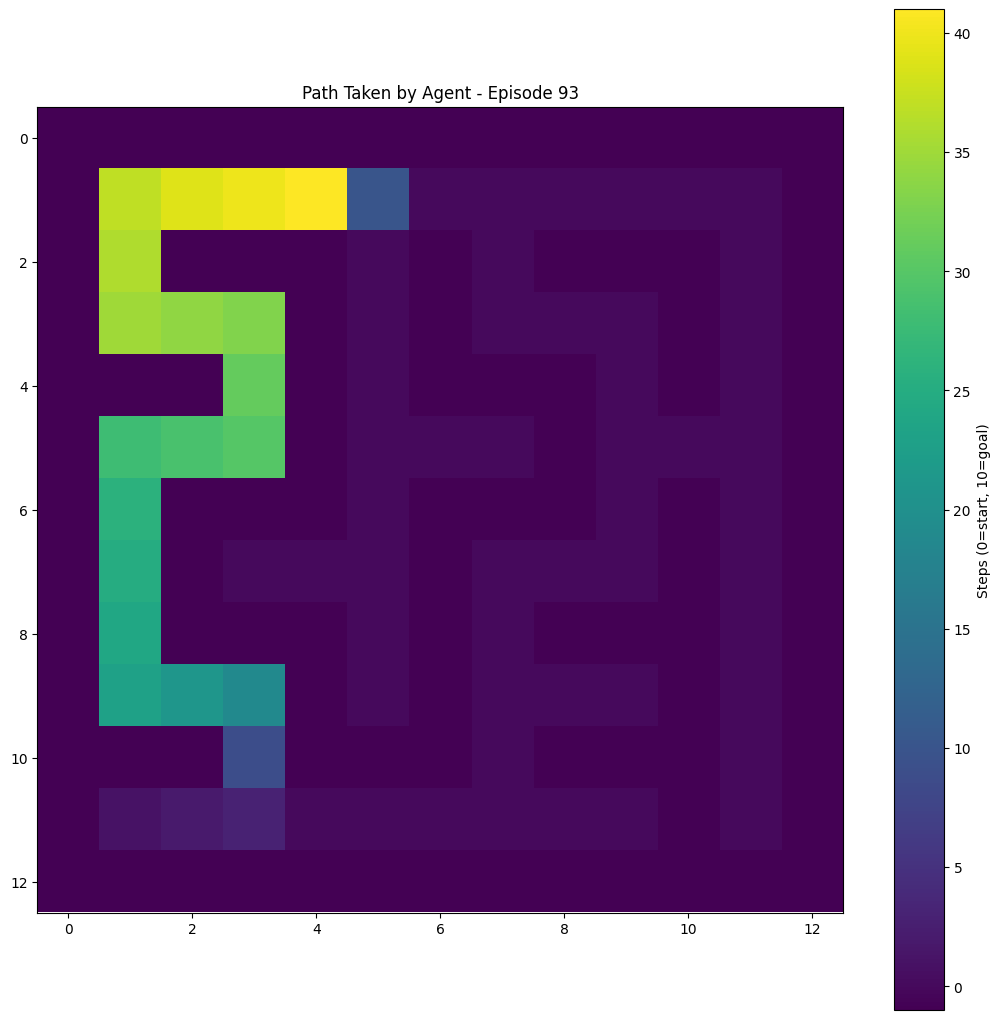

Episode 94 completed with 40 steps, average loss 0.8390842236578464 and total reward 74.5


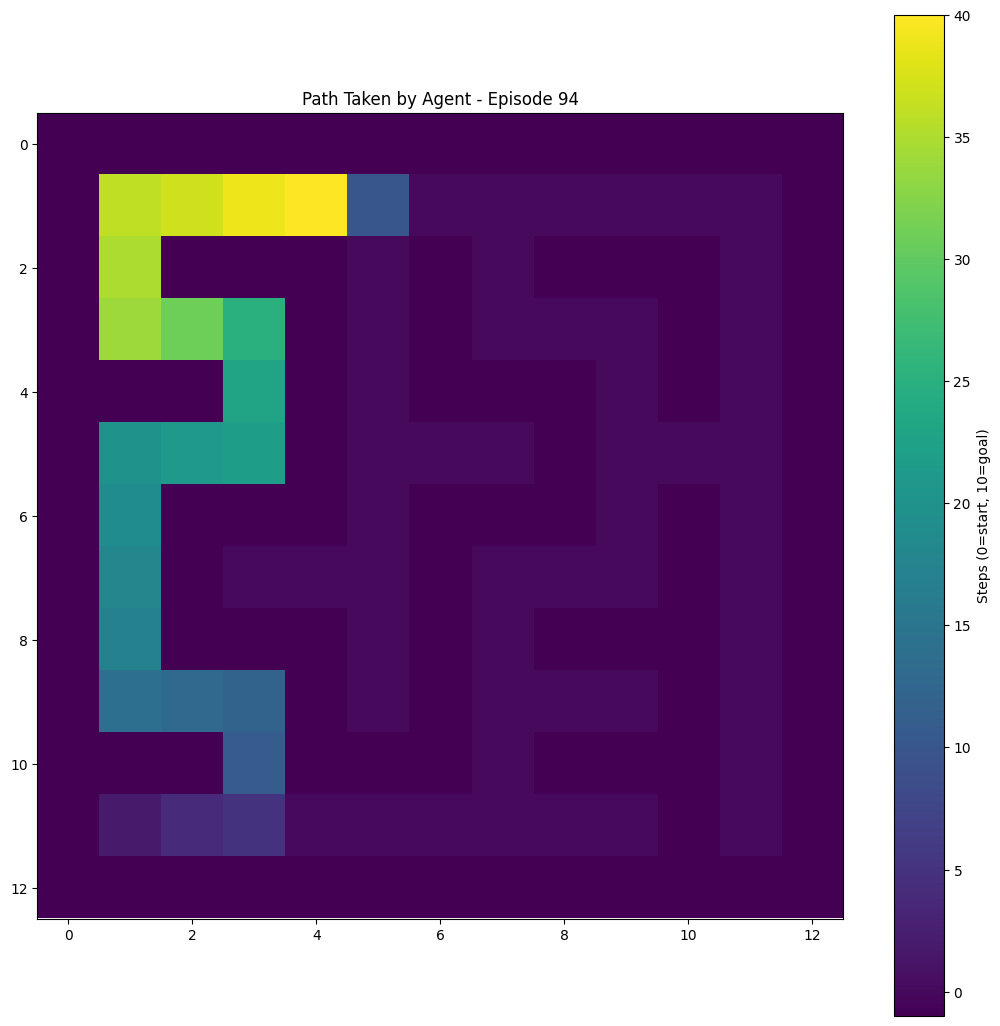

Episode 95 completed with 39 steps, average loss 1.061160229719602 and total reward 76.5


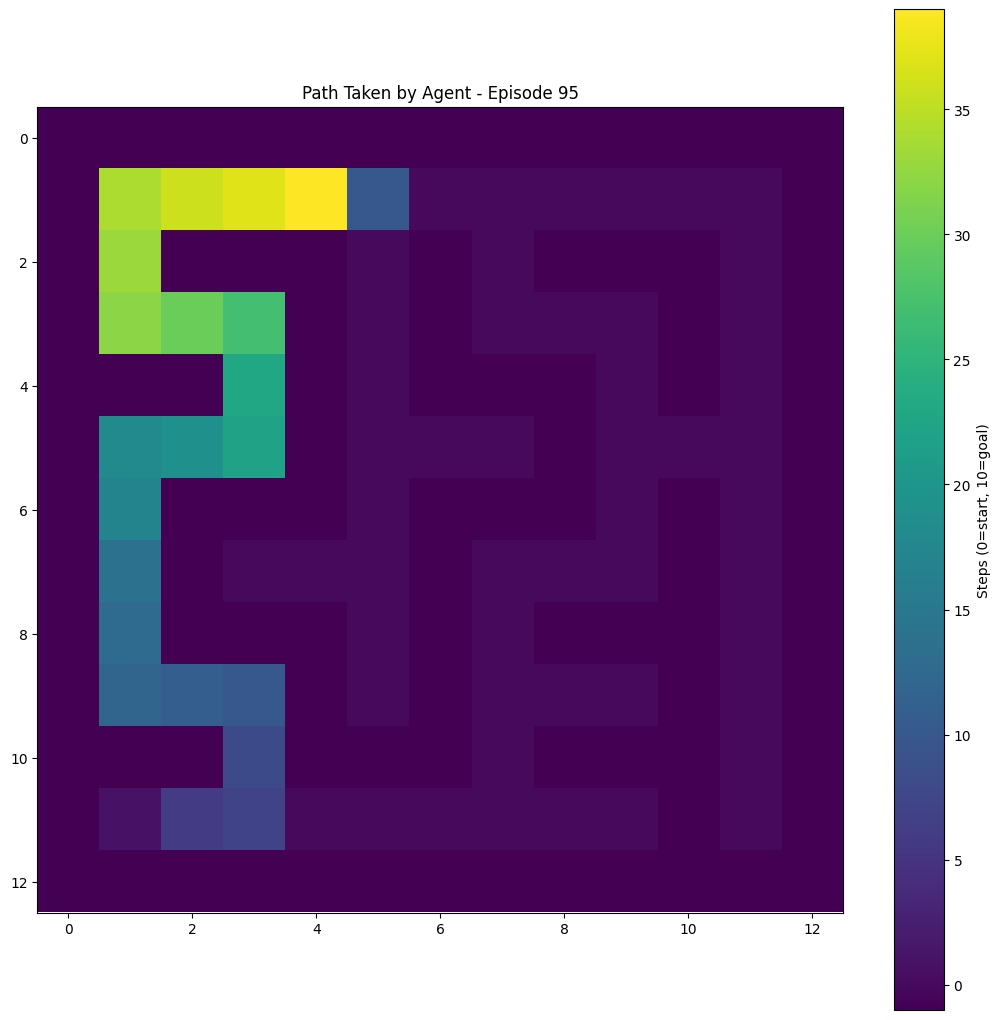

Episode 96 completed with 35 steps, average loss 0.8546781284468514 and total reward 79.5


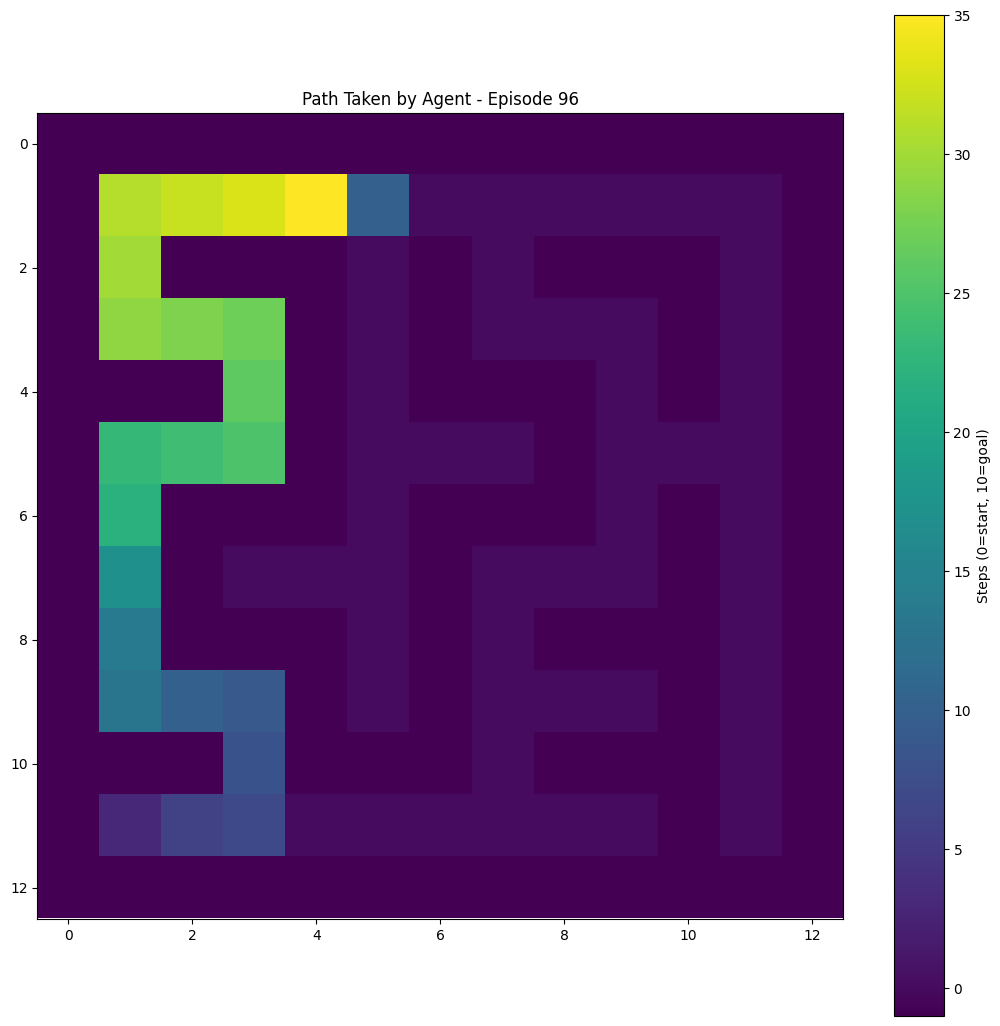

Episode 97 completed with 31 steps, average loss 0.7367574793677176 and total reward 80.5


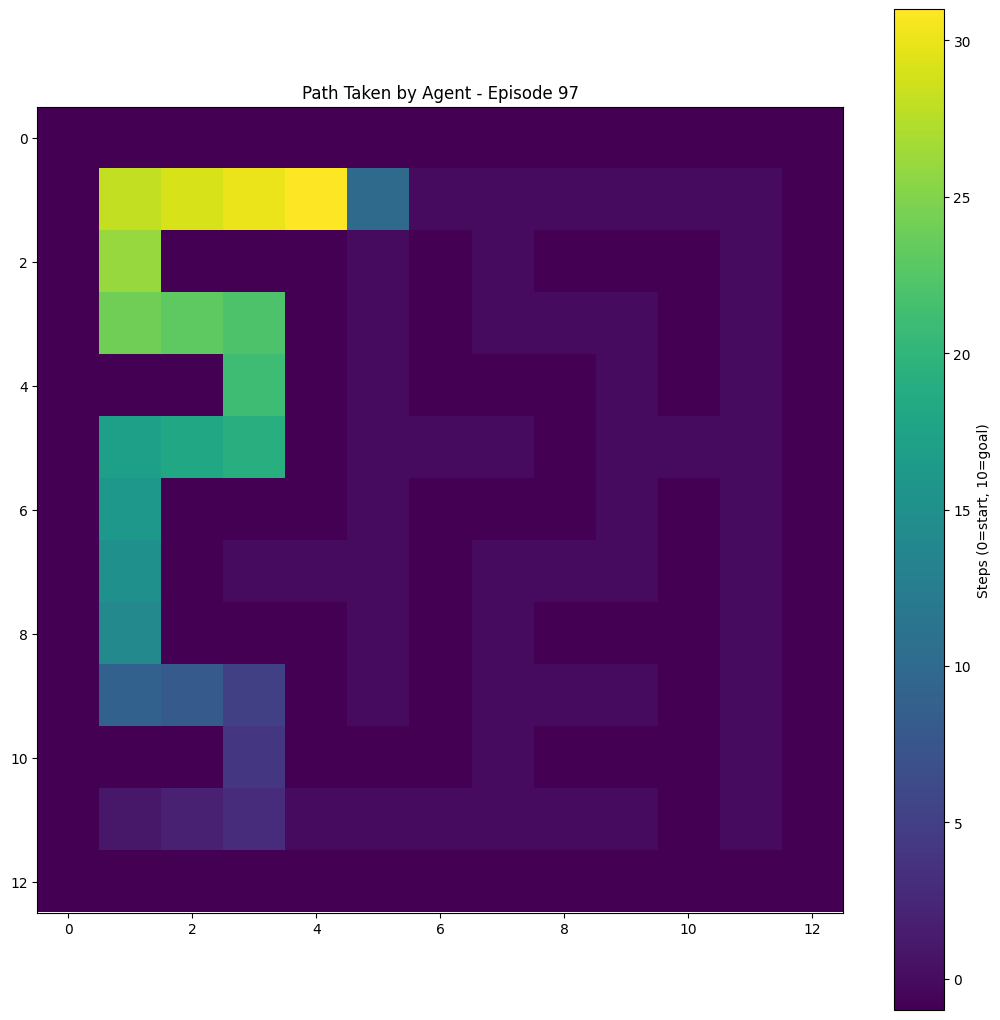

Episode 98 completed with 33 steps, average loss 0.7360850798361229 and total reward 79.5


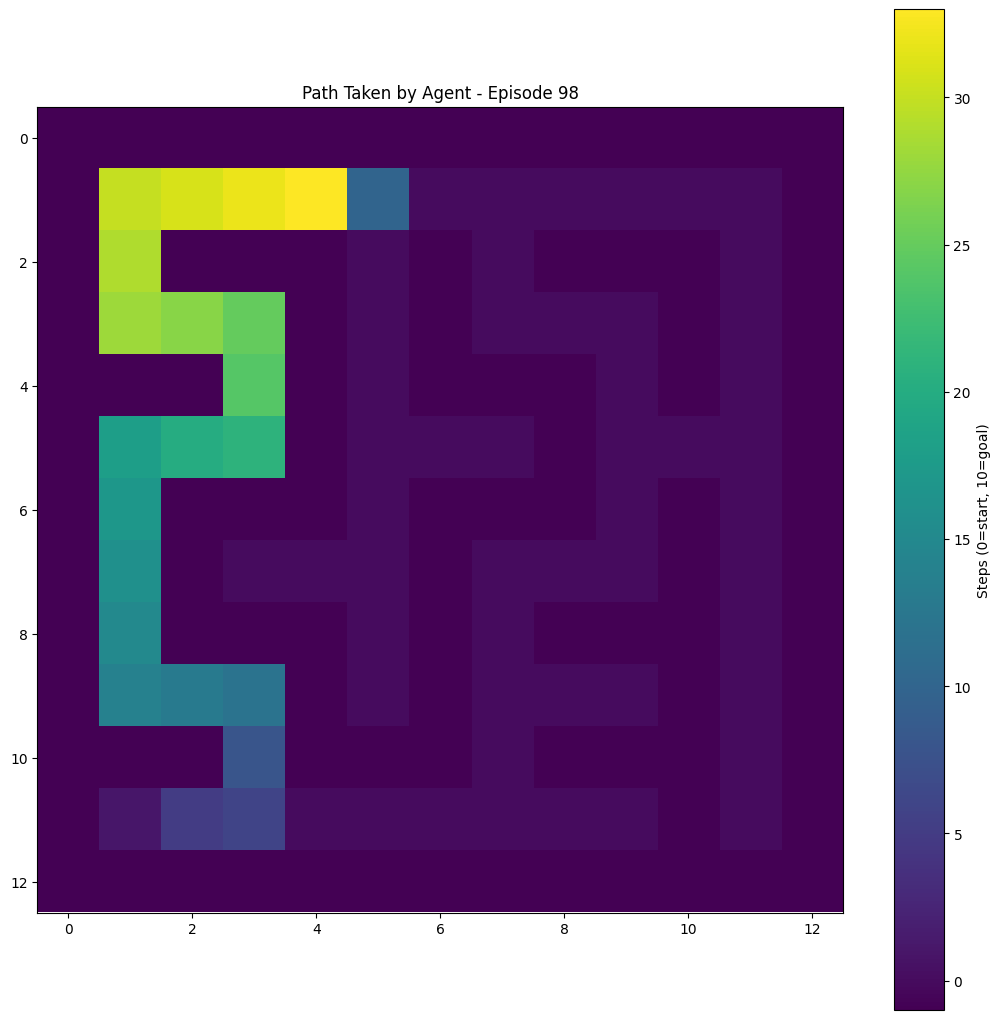

Episode 99 completed with 35 steps, average loss 0.8126763871737889 and total reward 77.5


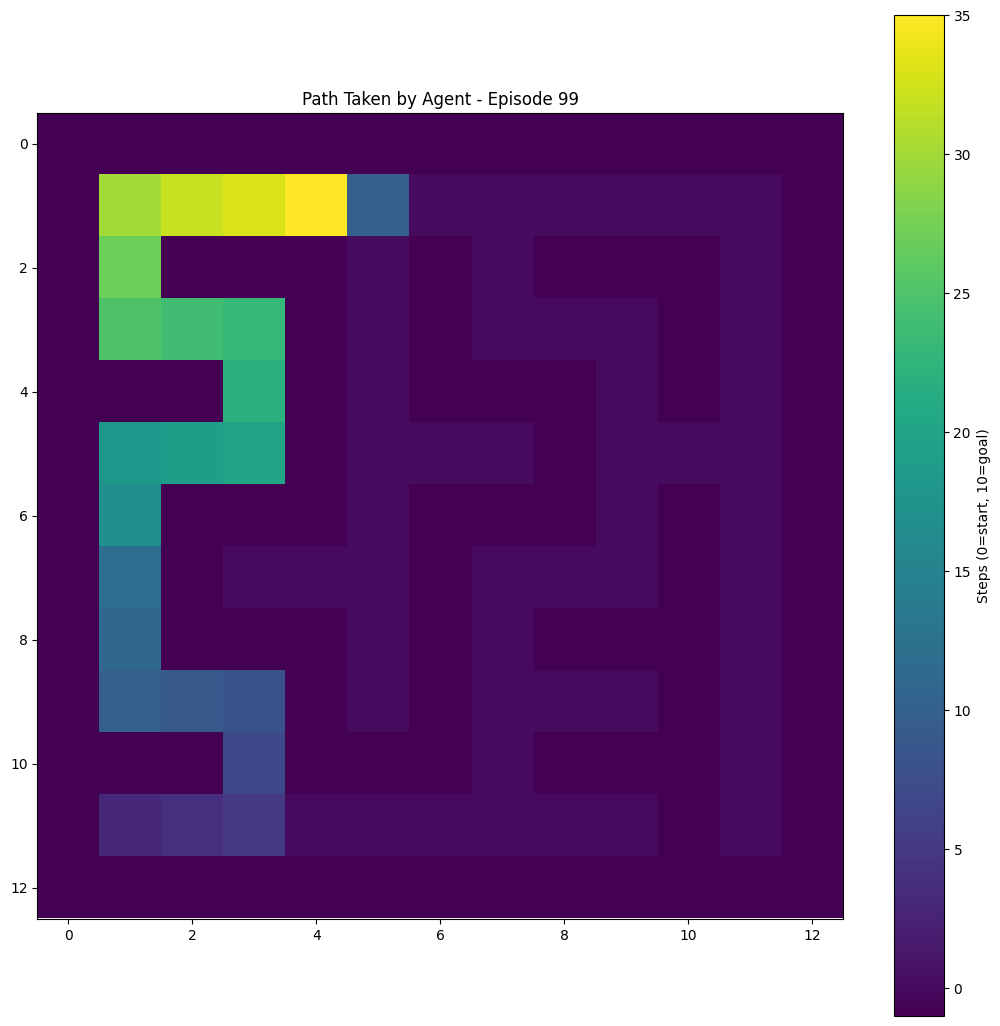

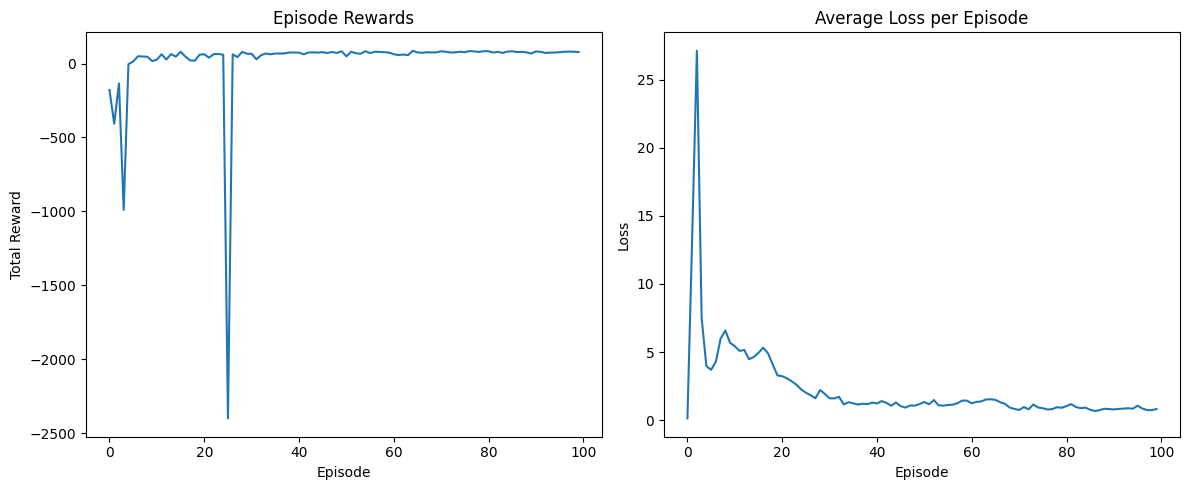

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  # Add this import
from maze import Maze
from DQNAgent import DQNAgent
from rl_evaluator import RLEvaluator, run_comparison  # Add this import
import torch

# Constants
GAME_HEIGHT = 125
GAME_WIDTH = 125
NUMBER_OF_TILES = 9
SCREEN_HEIGHT = 700
SCREEN_WIDTH = 700
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXX",
    "X           X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX X XXX X X",
    "X   X   X   X",
    "X XXX XXX X X",
    "X X   X   X X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX XXX XXX X",
    "XP        X X",
    "XXXXXXXXXXXXX",
]

env = Maze(level, goal_pos=(1, 5), MAZE_HEIGHT=GAME_HEIGHT, MAZE_WIDTH=GAME_WIDTH, SIZE=TILE_SIZE)

# Define state and action dimensions based on your environment's needs
state_dim = 2  # Assuming the state is a 2D coordinate (row, col)
action_dim = 4  # Four actions: left, up, right, down
agent = DQNAgent(state_dim, action_dim)

# Add evaluation function
def evaluate_agent(env, agent, num_runs=5):
    total_reward = 0
    for _ in range(num_runs):
        state = env.reset_state()
        done = False
        episode_reward = 0
        while not done:
            #action = agent.get_action(state, epsilon=0.0)  # No exploration
            action = agent.get_action(state, temperature=0.3)
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
        total_reward += episode_reward
    average_reward = total_reward / num_runs
    return average_reward


def plot_path(agent_path, episode, max_steps=100):
    grid = np.zeros((env.number_of_tiles, env.number_of_tiles))
    for (row, col) in env.walls:
        grid[row, col] = -1  # Represent walls with -1
    for step, (row, col) in enumerate(agent_path[:max_steps]):
        grid[row, col] = step + 1  # Mark path with step number
    grid[env.goal_pos] = 10  # Mark goal with 10
    plt.figure(figsize=(env.number_of_tiles, env.number_of_tiles))  # Adjust figure size to match maze size
    plt.imshow(grid, cmap="viridis", origin="upper")
    plt.colorbar(label="Steps (0=start, 10=goal)")
    plt.title(f"Path Taken by Agent - Episode {episode}")
    plt.show()

# Initialize lists to store rewards and losses
episode_rewards = []
episode_losses = []

# Training loop
num_episodes = 100
evaluation_interval = 50  # Evaluate every 50 episodes
for episode in range(num_episodes):
    state = env.reset_state()
    done = False
    steps = 0
    cumulative_loss = 0
    episode_reward = 0
    agent_path = [state]  # Track path for visualization

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        loss = agent.train()
        cumulative_loss += loss
        episode_reward += reward
        steps += 1
        state = next_state
        agent_path.append(state)  # Add to path

    avg_loss = cumulative_loss / steps if steps > 0 else 0
    episode_rewards.append(episode_reward)  # Store total reward
    episode_losses.append(avg_loss)         # Store average loss

    # Print episode details
    print(f"Episode {episode} completed with {steps} steps, average loss {avg_loss} and total reward {episode_reward}")
    
    # Evaluate the agent and plot path every 50 episodes
    #if episode % evaluation_interval == 0 and episode != 0:
        #avg_reward = evaluate_agent(env, agent)
        #print(f"Evaluation after episode {episode}: Average Reward = {avg_reward}")
    if episode_reward > 60:
        plot_path(agent_path, episode)

# After training, plot rewards and losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Average Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [3]:
print(agent_path)

[(11, 1), (11, 2), (11, 1), (11, 2), (11, 2), (11, 1), (11, 2), (11, 3), (10, 3), (9, 3), (9, 3), (9, 3), (9, 3), (10, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 3), (9, 2), (9, 1), (8, 1), (7, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (6, 1), (5, 1), (5, 2), (5, 3), (4, 3), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 4), (1, 4), (1, 5)]


In [ ]:
import pygame
import os
from moviepy import ImageSequenceClip

# Initialize pygame
pygame.init()

# Constants for pygame visualization
SCREEN_WIDTH = 700
SCREEN_HEIGHT = 700
TILE_SIZE = SCREEN_WIDTH // env.number_of_tiles
FPS = 5  # Frames per second for animation

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GRAY = (200, 200, 200)
BLUE = (0, 0, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)

# Create screen
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
pygame.display.set_caption("Agent Path Animation")

# Function to draw the maze
def draw_maze(env, agent_position, path=[]):
    screen.fill(BLACK)
    for row in range(env.number_of_tiles):
        for col in range(env.number_of_tiles):
            rect = pygame.Rect(col * TILE_SIZE, row * TILE_SIZE, TILE_SIZE, TILE_SIZE)
            if (row, col) in env.walls:
                pygame.draw.rect(screen, GRAY, rect)  # Walls
            elif (row, col) == env.goal_pos:
                pygame.draw.rect(screen, GREEN, rect)  # Goal
            elif (row, col) in path:
                pygame.draw.rect(screen, BLUE, rect)  # Path
            else:
                pygame.draw.rect(screen, WHITE, rect)  # Empty space
            pygame.draw.rect(screen, BLACK, rect, 1)  # Grid lines

    # Draw agent
    agent_rect = pygame.Rect(agent_position[1] * TILE_SIZE, agent_position[0] * TILE_SIZE, TILE_SIZE, TILE_SIZE)
    pygame.draw.rect(screen, RED, agent_rect)

# Export animation
def export_animation(agent_path, filename="episode_100boltz.mp4"):
    clock = pygame.time.Clock()
    running = True
    frame_count = 0
    frame_paths = []

    for step, position in enumerate(agent_path):
        if not running:
            break
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        draw_maze(env, position, path=agent_path[:step])
        pygame.display.flip()

        # Save frames for animation
        frame_count += 1
        frame_path = f"frame_{frame_count}.png"
        pygame.image.save(screen, frame_path)
        frame_paths.append(frame_path)

        clock.tick(FPS)

    pygame.quit()

    # Create video from frames using moviepy
    clip = ImageSequenceClip(frame_paths, fps=FPS)
    clip.write_videofile(filename, fps=FPS)

    # Clean up frame files
    for frame_path in frame_paths:
        os.remove(frame_path)

# Example usage: Export animation for episode 50
# Assuming agent_path_50 is the path of the agent in episode 50
export_animation(agent_path, filename="episode_50.mp4")


pygame 2.5.0 (SDL 2.28.0, Python 3.11.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
MoviePy - Building video episode_50.mp4.
MoviePy - Writing video episode_50.mp4



MoviePy - Done !
MoviePy - video ready episode_50.mp4


In [11]:
def boltzmann_action_probabilities(q_values, temperature):
    """
    Compute Boltzmann (softmax) probabilities for actions.

    Args:
        q_values (np.ndarray): Q-values for each action.
        temperature (float): Temperature parameter controlling exploration.

    Returns:
        np.ndarray: Softmax probabilities for each action.
    """
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Subtract max for numerical stability
    probabilities = exp_q / np.sum(exp_q)
    return probabilities

def plot_boltzmann_distribution(q_values, temperatures, action_labels):
    """
    Plot the Boltzmann distribution (action probabilities) for different temperatures.

    Args:
        q_values (np.ndarray): Q-values for each action.
        temperatures (list of float): List of temperature values.
        action_labels (list of str): Labels for the actions.
    """
    plt.figure(figsize=(10, 6))
    for T in temperatures:
        probabilities = boltzmann_action_probabilities(q_values, T)
        plt.plot(action_labels, probabilities, marker='o', label=f"T = {T:.2f}")

    plt.xlabel("Actions")
    plt.ylabel("Probability")
    plt.title("Boltzmann Distribution for Action Probabilities")
    plt.legend()
    plt.grid(True)
    plt.show()



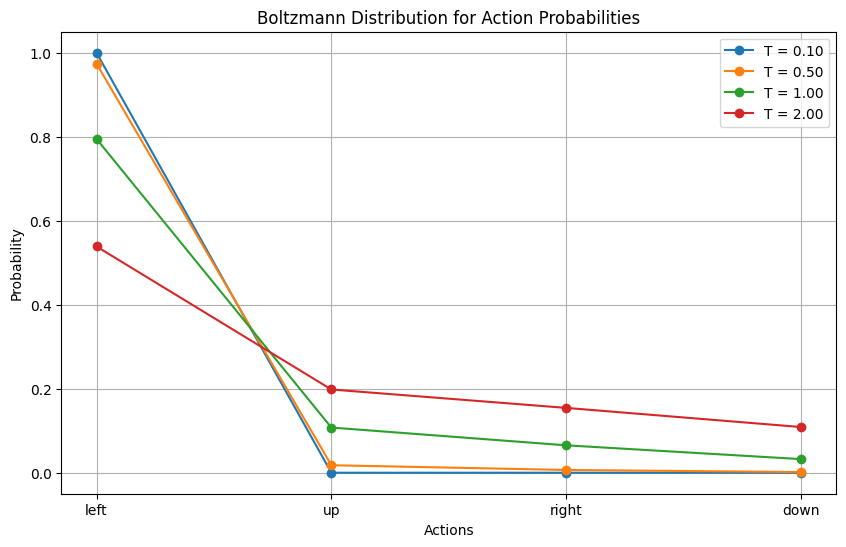

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def boltzmann_action_probabilities(q_values, temperature):
    """
    Compute Boltzmann (softmax) probabilities for actions.

    Args:
        q_values (np.ndarray): Q-values for each action.
        temperature (float): Temperature parameter controlling exploration.

    Returns:
        np.ndarray: Softmax probabilities for each action.
    """
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Subtract max for numerical stability
    probabilities = exp_q / np.sum(exp_q)
    return probabilities

def plot_boltzmann_distribution(q_values, temperatures, action_labels):
    """
    Plot the Boltzmann distribution (action probabilities) for different temperatures.

    Args:
        q_values (np.ndarray): Q-values for each action.
        temperatures (list of float): List of temperature values.
        action_labels (list of str): Labels for the actions.
    """
    plt.figure(figsize=(10, 6))
    for T in temperatures:
        probabilities = boltzmann_action_probabilities(q_values, T)
        plt.plot(action_labels, probabilities, marker='o', label=f"T = {T:.2f}")

    plt.xlabel("Actions")
    plt.ylabel("Probability")
    plt.title("Boltzmann Distribution for Action Probabilities")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Q-values from your agent (replace with real values)
q_values = np.array([3.0, 1.0, 0.5, -0.2])  # Example Q-values for actions
action_labels = ["left", "up", "right", "down"]  # Action labels
temperatures = [0.1, 0.5, 1.0, 2.0]  # Temperatures to explore

# Plot the Boltzmann distribution
plot_boltzmann_distribution(q_values, temperatures, action_labels)


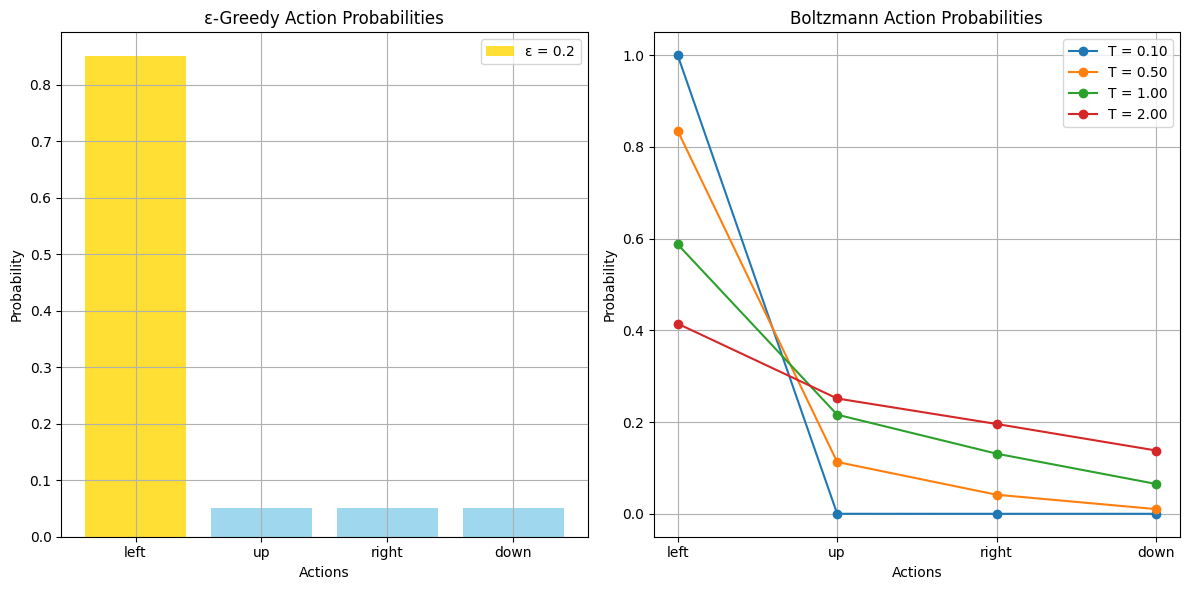

In [20]:
def plot_exploration_pdfs(q_values, epsilon, temperatures, action_labels):
    """
    Plots the action probabilities for ε-greedy and Boltzmann distribution.

    Args:
        q_values (list or np.ndarray): Q-values for each action.
        epsilon (float): Exploration rate for ε-greedy.
        temperatures (list of float): List of temperature values for Boltzmann distribution.
        action_labels (list of str): Labels for the actions.
    """
    q_values = np.array(q_values)  # Convert to NumPy array for mathematical operations
    num_actions = len(q_values)

    # ε-Greedy probabilities
    greedy_action = np.argmax(q_values)
    e_greedy_probs = [epsilon / num_actions if i != greedy_action else (1 - epsilon) + epsilon / num_actions 
                      for i in range(num_actions)]

    # Plot ε-greedy probabilities
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    colors = ["gold" if i == greedy_action else "skyblue" for i in range(num_actions)]
    plt.bar(action_labels, e_greedy_probs, color=colors, alpha=0.8, label=f"ε = {epsilon}")
    plt.xlabel("Actions")
    plt.ylabel("Probability")
    plt.title("ε-Greedy Action Probabilities")
    plt.legend()
    plt.grid(True)

    # Boltzmann probabilities for different temperatures
    plt.subplot(1, 2, 2)
    for T in temperatures:
        q_values_scaled = q_values / T
        exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
        boltzmann_probs = exp_q / np.sum(exp_q)
        plt.plot(action_labels, boltzmann_probs, marker='o', label=f"T = {T:.2f}")
    
    plt.xlabel("Actions")
    plt.ylabel("Probability")
    plt.title("Boltzmann Action Probabilities")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
q_values = [2.0, 1.0, 0.5, -0.2]  # Example Q-values
action_labels = ["left", "up", "right", "down"]  # Action labels
epsilon = 0.2  # Exploration rate for ε-greedy
temperatures = [0.1, 0.5, 1.0, 2.0]  # Temperatures for Boltzmann distribution

# Plot the PDFs
plot_exploration_pdfs(q_values, epsilon, temperatures, action_labels)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from maze import Maze
from DQNAgent import DQNAgent
import torch

# Constants
GAME_HEIGHT = 125
GAME_WIDTH = 125
NUMBER_OF_TILES = 9
TILE_SIZE = GAME_HEIGHT // NUMBER_OF_TILES

# Maze layout
level = [
    "XXXXXXXXXXXXX",
    "X           X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX X XXX X X",
    "X   X   X   X",
    "X XXX XXX X X",
    "X X   X   X X",
    "X XXX X XXX X",
    "X   X X   X X",
    "XXX XXX XXX X",
    "XP        X X",
    "XXXXXXXXXXXXX",
]

env = Maze(level, goal_pos=(1, 5), MAZE_HEIGHT=GAME_HEIGHT, MAZE_WIDTH=GAME_WIDTH, SIZE=TILE_SIZE)

# Define state and action dimensions based on your environment's needs
state_dim = 2  # Assuming the state is a 2D coordinate (row, col)
action_dim = 4  # Four actions: left, up, right, down
agent = DQNAgent(state_dim, action_dim)

# Function to calculate ε-greedy probabilities
def calculate_e_greedy_probs(q_values, epsilon):
    num_actions = len(q_values)
    greedy_action = np.argmax(q_values)
    return np.array([epsilon / num_actions if i != greedy_action 
                     else (1 - epsilon) + epsilon / num_actions 
                     for i in range(num_actions)])

# Function to calculate Boltzmann probabilities
def calculate_boltzmann_probs(q_values, temperature):
    q_values_scaled = q_values / temperature
    exp_q = np.exp(q_values_scaled - np.max(q_values_scaled))  # Numerical stability
    return exp_q / np.sum(exp_q)

# Logging Q-values and probabilities during training
q_values_over_time = []
epsilon_decay = np.linspace(1.0, 0.1, num_episodes)  # Decaying ε over episodes
temperature = 1.0  # Fixed temperature for Boltzmann

# Training loop
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset_state()
    done = False
    while not done:
        # Get Q-values from the agent
        q_values = agent.q_network(torch.FloatTensor(state).unsqueeze(0)).detach().numpy().flatten()
        epsilon = epsilon_decay[episode]
        q_values_over_time.append((q_values, epsilon))

        # Perform action selection and training
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        agent.train()
        state = next_state

# Create animation for action probabilities
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
action_labels = ["left", "up", "right", "down"]

bars_e_greedy = ax[0].bar(action_labels, [0, 0, 0, 0], color="skyblue", alpha=0.8, label="ε-Greedy")
bars_boltzmann = ax[1].bar(action_labels, [0, 0, 0, 0], color="gold", alpha=0.8, label="Boltzmann")

ax[0].set_ylim(0, 1)
ax[0].set_title("ε-Greedy Action Probabilities")
ax[0].set_ylabel("Probability")
ax[0].legend()
ax[0].grid(True)

ax[1].set_ylim(0, 1)
ax[1].set_title("Boltzmann Action Probabilities")
ax[1].set_ylabel("Probability")
ax[1].legend()
ax[1].grid(True)

# Update function for animation
def update(frame):
    q_values, epsilon = q_values_over_time[frame]
    e_greedy_probs = calculate_e_greedy_probs(q_values, epsilon)
    boltzmann_probs = calculate_boltzmann_probs(q_values, temperature)

    # Update bar heights
    for bar, prob in zip(bars_e_greedy, e_greedy_probs):
        bar.set_height(prob)
    for bar, prob in zip(bars_boltzmann, boltzmann_probs):
        bar.set_height(prob)

    # Update title
    fig.suptitle(f"Timestep: {frame + 1}, ε: {epsilon:.2f}", fontsize=16)

# Create the animation
ani = FuncAnimation(fig, update, frames=len(q_values_over_time), repeat=False, interval=200)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=5)
ani.save("policy_comparison.gif", writer=gif_writer)

print("Animation saved as 'policy_comparison.gif'")
